In [1]:
import wfdb
import os
import glob
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, find_peaks
from sklearn.decomposition import FastICA
from scipy.interpolate import RectBivariateSpline
from scipy import interpolate
from scipy.ndimage import gaussian_filter
from scipy.optimize import curve_fit
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
import matplotlib.animation as animation
import matplotlib.cm as cm
from IPython.display import HTML
# from google.colab import files
from pyclustering.cluster.gmeans import gmeans
from pyclustering.cluster.xmeans import xmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.utils.metric import type_metric, distance_metric
from sklearn.svm import SVC
import itertools
import warnings
np.warnings = warnings

# ここから

In [2]:
# ガウス関数定義
def gaussian_2d(coord, A, x0, y0, sigma_x, sigma_y, theta, offset):
    x, y = coord #coord[:, 0], coord[:, 1]
    a = (np.cos(theta)**2) / (2*sigma_x**2) + (np.sin(theta)**2) / (2*sigma_y**2)
    b = -(np.sin(2*theta)) / (4*sigma_x**2) + (np.sin(2*theta)) / (4*sigma_y**2)
    c = (np.sin(theta)**2) / (2*sigma_x**2) + (np.cos(theta)**2) / (2*sigma_y**2)
    return A * np.exp(-(a*(x - x0)**2 + 2*b*(x - x0)*(y - y0) + c*(y - y0)**2)) + offset

In [32]:
def waveform_length(signal):
    return np.sum(np.abs(np.diff(signal, axis=0)), axis=0)

def ptp(signal):
    return np.ptp(signal, axis=0)

def arv(signal):
    return np.mean(np.abs(signal), axis=0)

def rms(signal):
    return np.sqrt(np.mean(signal**2, axis=0))

def zc(signal):
    s = np.sign(signal)
    s_prev = s[:-1]
    s_next = s[1:]
    sign_change = (s_prev * s_next) < 0
    return np.sum(sign_change, axis=0)

In [4]:
def get_centers_directions(emg_data, curve, feature_func, fs=2000, window_ms=200, stride_ms=50):
    # --- データ読み込み ---
    emg_data = emg_data  # shape: (n_samples, n_channels)
    curve = curve  # 近似曲面
    feature_func = feature_func  # 特徴量抽出関数
    fs = fs  # サンプリング周波数
    window_ms = window_ms    # ウィンドウ幅 [ms]
    stride_ms = stride_ms    # スライド幅 [ms]
    window_size = int(fs * (window_ms / 1000))  # サンプル数に変換
    stride_size = int(fs * stride_ms / 1000)  # スライド数
    n_samples = emg_data.shape[0]
    # 座標グリッド
    x = np.arange(8)
    y = np.arange(8)
    xv, yv = np.meshgrid(x, y)
    coords = np.vstack((xv.ravel(), yv.ravel()))

    centers = []
    directions = []
    theta_1s = []
    mucle_activity_information_list = []
    for start in range(0, n_samples - window_size + 1, stride_size):
        end = start + window_size
        window_emg = emg_data[start:end, :]
        #特徴量抽出
        feature = feature_func(window_emg) # shape: (n_channels,)
        map_2d = feature.reshape(8, 8)  # 8x8のマップに変形
        # フィッティング
        max_index = np.unravel_index(np.argmax(map_2d), map_2d.shape)
        initial = [np.max(feature)-np.min(feature), max_index[0], max_index[1], 1, 1, 0, np.min(feature)]
        bounds = ([0, 0, 0, 0.1, 0.1, -np.pi/2, -np.inf],
                [np.inf, 7, 7, 5, 5, np.pi/2, np.inf])
        popt, _ = curve_fit(curve, coords, feature, p0=initial, bounds=bounds, maxfev=10000)
        A, x0, y0, sigma_x, sigma_y, theta, offset = popt #パラメータ取得
        center = (x0, y0)
        if sigma_x > sigma_y:
            theta_1 = theta
            # print('σx > σy')
        else:
            if theta >= 0:
                theta_1 = theta - np.pi/2
            else:
                theta_1 = theta + np.pi/2
            # print('σy >= σx')
        direction = (np.cos(theta_1), np.sin(theta_1))

        centers.append(center)
        directions.append(direction)
        theta_1s.append(np.degrees(theta_1))

        mucle_activity_information = []
        mucle_activity_information.append(center[0])
        mucle_activity_information.append(center[1])
        mucle_activity_information.append(np.degrees(theta_1))
        mucle_activity_information_list.append(mucle_activity_information)

    # print(centers)
    # print(directions)
    # print(theta_1s)
    # print(f'all centers:: ave:{np.mean(centers, axis=0)}, std:{np.std(centers, axis=0)}')
    # print(f'all theta_1:: ave:{np.mean(theta_1s, axis=0)}, std:{np.std(theta_1s, axis=0)}')

    return mucle_activity_information_list

In [5]:
def clustering(features, k1=4, k2=3):
    # 1. 特徴ベクトルを構築
    features = np.array(features)
    results_df = pd.DataFrame(data=features, columns=['center_x', 'center_y', 'theta_deg'])

    # --- 第1段階：中心座標でクラスタリング ---
    # 特徴量：center_x, center_y
    center_features = results_df[['center_x', 'center_y']].dropna()
    k1 = k1  # 中心クラスタ数（例）
    kmeans1 = KMeans(n_clusters=k1, random_state=0)
    center_labels = kmeans1.fit_predict(center_features)

    # 結果に追加
    results_df['center_cluster'] = -1
    results_df.loc[center_features.index, 'center_cluster'] = center_labels

    # # --- 第2段階：方向角でクラスタリング（各中心クラスタ内で） ---
    # # θの周期性を考慮 → sinθ, cosθでクラスタリング
    # results_df['theta_sin'] = np.sin(results_df['theta_rad'])
    # results_df['theta_cos'] = np.cos(results_df['theta_rad'])

    direction_cluster_labels = np.full(len(results_df), -1)  # 初期化

    k2 = k2  # 各中心クラスタ内の方向クラスタ数（例）

    for group_id in range(k1):
        group_df = results_df[results_df['center_cluster'] == group_id]
        idx = group_df.index
        if len(group_df) >= k2:  # クラスタ数以上あるか確認
            dir_features = group_df[['theta_deg']].values
            kmeans2 = KMeans(n_clusters=k2, random_state=0)  # 固定乱数
            sub_labels = kmeans2.fit_predict(dir_features)
            direction_cluster_labels[idx] = sub_labels + group_id * 10  # 固有ラベル化

    # 結果に追加
    results_df['direction_cluster'] = direction_cluster_labels


    # クラスタごとに平均・標準偏差を集計
    cluster_stats = results_df.groupby('direction_cluster').agg({
        'center_x': ['mean', 'std'],
        'center_y': ['mean', 'std'],
        'theta_deg': ['mean', 'std'],
        'direction_cluster': 'count'
    })

    # 結果をまとめ直す
    summary_df = pd.DataFrame({
        'cluster': cluster_stats.index,
        'center_x_mean': cluster_stats[('center_x', 'mean')],
        'center_x_std': cluster_stats[('center_x', 'std')],
        'center_y_mean': cluster_stats[('center_y', 'mean')],
        'center_y_std': cluster_stats[('center_y', 'std')],
        'theta_deg_mean': cluster_stats[('theta_deg', 'mean')],
        'theta_deg_std': cluster_stats[('theta_deg', 'std')],
        # 'count': results_df['cluster'].value_counts().sort_index(),
        'count': cluster_stats[('direction_cluster', 'count')]
    }).reset_index(drop=True)

    # 結果表示
    summary_df

    return results_df, summary_df

In [6]:
def get_cluster_colors(n_clusters, cmap_name='tab20'):
    cmap = cm.get_cmap(cmap_name, n_clusters)  # 'tab20', 'nipy_spectral', etc.
    return [cmap(i) for i in range(n_clusters)]

In [7]:
def plot_fiber(results_df, arrow_scale=0.5):
  arrow_scale = arrow_scale

  n_clusters = results_df['direction_cluster'].nunique()
  cluster_colors = get_cluster_colors(n_clusters)

  # プロット準備
  plt.figure(figsize=(7, 6))
  for n, center_cluster in enumerate(sorted(results_df['direction_cluster'].unique())):
    sub_df = results_df[results_df['direction_cluster'] == center_cluster]
    color = cluster_colors[n]

    for _, row in sub_df.iterrows():
          x, y = row['center_x'], row['center_y']
          theta = row['theta_deg']
          dx, dy = np.cos(np.radians(theta)) * arrow_scale, np.sin(np.radians(theta)) * arrow_scale

          # 色で中心クラスタを、マーカーサイズで方向クラスタを示す
          plt.arrow(x, y, dx, dy, head_width=0.15, color=color, alpha=0.8)
          plt.plot(x, y, 'o', color=color,
                  label=f"Center Cl {center_cluster}" if f"Center Cl {center_cluster}" not in plt.gca().get_legend_handles_labels()[1] else "")

  # ラベル・軸
  plt.xlabel("center_x")
  plt.ylabel("center_y")
  plt.title("2-Stage Clustering of Muscle Fiber Direction")
  plt.grid(True)
  plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
  plt.axis('equal')
  plt.tight_layout()
  plt.xlim(0, 7)
  plt.ylim(0, 7)
  plt.show()

In [8]:
def get_virtual_bipolars(results_df, ied=2, arrow_scale=0.5):
  #仮想双極電極の電極間距離（cm）
  a = ied

#   n_clusters = results_df['direction_cluster'].nunique()
#   cluster_colors = get_cluster_colors(n_clusters)

  virtual_bipolars = []
  labels = []
  center_direction = []
  n_virtual_bipolars_checker = []
  for n, direction_cluster in enumerate(sorted(results_df['direction_cluster'].unique())):
    sub_df = results_df[results_df['direction_cluster'] == direction_cluster]
    if sub_df['center_cluster'].count() >= 20 and sub_df['center_x'].std() < 1 and sub_df['center_y'].std() < 1 and sub_df['theta_deg'].std() < 20:
      x, y = sub_df['center_x'].mean(), sub_df['center_y'].mean()
      theta = sub_df['theta_deg'].mean()
      #dx, dy = np.cos(np.radians(theta)) * arrow_scale, np.sin(np.radians(theta)) * arrow_scale
      # print(f'cluster:{direction_cluster}, x={x}, y={y}, θ={theta}')
      x1 = x - a/2*np.cos(np.radians(theta))
      y1 = y - a/2*np.sin(np.radians(theta))
      x2 = x + a/2*np.cos(np.radians(theta))
      y2 = y + a/2*np.sin(np.radians(theta))
      virtual_bipolars.append([x1, y1, x2, y2])
      labels.append(direction_cluster)
      center_direction.append([x, y, theta])
      n_virtual_bipolars_checker.append(True)
  # if len(n_virtual_bipolars_checker) == 1:
  #   virtual_bipolars.append([0,0,0,0])
  #   labels.append(999)
  #   center_direction.append([0,0,0])

  return virtual_bipolars, labels, center_direction, len(n_virtual_bipolars_checker)

In [9]:
def extract_rms_features(windows):
    """
    各ウィンドウからチャネルごとのRMS特徴量を抽出
    入力: shape = (window_size, n_channels)
    出力: shape = (n_channels)
    """
    return np.sqrt(np.mean(np.square(windows), axis=0))

In [10]:
def get_virtual_emg(emg_data, virtual_bipolars):
  # --- データ読み込み ---
  emg_data = emg_data

  # === スライディングウィンドウ抽出 ===
  n_samples = emg_data.shape[0]
  segments = []
  time_stamps = []

  # 座標グリッド
  x = np.arange(8)
  y = np.arange(8)
  xv, yv = np.meshgrid(x, y)
  coords = np.vstack((xv.ravel(), yv.ravel()))
  # # パラメータ計算
  # f = RectBivariateSpline(x, y, map_2d)

  virtual_emg = []
  for i in range(n_samples):
    f = RectBivariateSpline(x, y, emg_data[i].reshape(8,8))
    z_list = []
    for bipolar in virtual_bipolars:
      x1=bipolar[0]
      y1=bipolar[1]
      x2=bipolar[2]
      y2=bipolar[3]
      z1 = f(x1, y1)
      z2 = f(x2, y2)
      z_diff = z1 - z2
      z_list.append(z_diff)
    virtual_emg.append(np.array(z_list).reshape(-1))
  virtual_emg = np.array(virtual_emg)

  # print(emg_data.shape)
  # print(virtual_emg.shape)

  return virtual_emg

In [11]:
def get_features(virtual_emg, labels, fs=2000, window_ms=50, stride_ms=20):
  # --- データ読み込み例（ここではダミーデータ） ---
  fs = fs  # サンプリング周波数
  window_ms = window_ms    # ウィンドウ幅 [ms]
  stride_ms = stride_ms    # スライド幅 [ms]
  window_size = int(fs * (window_ms / 1000))  # サンプル数に変換
  stride_size = int(fs * stride_ms / 1000)  # スライド数
  n_samples = virtual_emg.shape[0]
  X = []
  y = []
  for start in range(0, n_samples - window_size + 1, stride_size):
      end = start + window_size
      window_emg = virtual_emg[start:end, :]
      #特徴量抽出
      rms = extract_rms_features(window_emg) # shape: (virtual_bipolar_channels,)
      X.append(rms)
      y.append(labels)
  return X, y

In [12]:
#分類器
def SVC_classifier(X_session1, y_session1, X_session2, y_session2):

    X_train = np.array(X_session1).reshape(-1,1)
    y_train = np.array(y_session1).reshape(-1,1)
    X_test = np.array(X_session2).reshape(-1,1)
    y_test = np.array(y_session2).reshape(-1,1)

    # データ分割
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # SVMモデル学習
    model = SVC(kernel='rbf', probability=True, random_state=0)
    model.fit(X_train, y_train)

    prob_matrix = model.predict_proba(X_test) # shape: (n_test_samples, n_train_classes)
    # === 各テストラベルごとに学習クラスへの平均確率を出力 ===
    class_labels = model.classes_  # 学習クラス（例: [0, 1, 2]）

    result = []

    for test_label in np.unique(y_test):
        idx = y_test.reshape(-1) == test_label
        mean_prob = np.mean(prob_matrix[idx], axis=0)  # 学習クラスへの平均確率
        result.append([test_label] + list(mean_prob))

    # # === 表形式で表示 ===
    # columns = ['Test Label'] + [f"P(Train={cls})" for cls in class_labels]
    # df_result = pd.DataFrame(result, columns=columns)
    # print(df_result)
    
    return result, y_train, y_test

In [13]:
def calc_diff(train_idx, test_idx, center_direction_session1, center_direction_session2):
    center_direction_session1 = center_direction_session1
    center_direction_session2 = center_direction_session2
    #計算
    center_x_train = np.array(center_direction_session1)[train_idx, 0]
    center_y_train = np.array(center_direction_session1)[train_idx, 1]
    theta_train = np.array(center_direction_session1)[train_idx, 2]
    center_x_test = np.array(center_direction_session2)[test_idx, 0]
    center_y_test = np.array(center_direction_session2)[test_idx, 1]
    theta_test = np.array(center_direction_session2)[test_idx, 2]
    center_x_diff = center_x_train - center_x_test
    center_y_diff = center_y_train - center_y_test
    theta_diff = theta_train - theta_test
    return center_x_diff, center_y_diff, theta_diff

In [14]:
def diff_analyzer(result, y_train, y_test, center_direction_session1, center_direction_session2):
  max_train_idx = []
  for i in range(np.array(result).shape[0]):
    j = np.argmax(np.array(result)[i,1:])
    max_train_idx.append(j)
  # print(max_train_idx)
  diff =[]
  for k in set(max_train_idx):
    if max_train_idx.count(k) >=2:
      idx = max_train_idx == k
      l = np.argmax(np.array(result)[idx, k+1], axis=0)
      max_test_idx = [i for i, j in enumerate(idx) if j == True]
      # print(f'result[{max_test_idx[l]},{k+1}], train:{np.unique(y_train)[k]}, test:{np.unique(y_test)[max_test_idx[l]]}')
      center_x_diff, center_y_diff, theta_diff = calc_diff(k, max_test_idx[l], center_direction_session1, center_direction_session2)
      # print(f'x_diff={center_x_diff}, y_diff={center_y_diff}, theta_diff={theta_diff}')
      diff.append({"train": np.unique(y_train)[k], "test": np.unique(y_test)[max_test_idx[l]], "x_diff": center_x_diff, "y_diff": center_y_diff, "theta_diff": theta_diff})
    else:
      # print(f'result[{max_train_idx.index(k)},{k+1}], train:{np.unique(y_train)[k]}, test:{np.unique(y_test)[max_train_idx.index(k)]}')
      center_x_diff, center_y_diff, theta_diff = calc_diff(k, max_train_idx.index(k), center_direction_session1, center_direction_session2)
      # print(f'x_diff={center_x_diff}, y_diff={center_y_diff}, theta_diff={theta_diff}')
      diff.append({"train": np.unique(y_train)[k], "test": np.unique(y_test)[max_train_idx.index(k)], "x_diff": center_x_diff, "y_diff": center_y_diff, "theta_diff": theta_diff})

  return diff

# 分析

## 各sessionで得られたvpolarの位置

In [33]:
n_subjects = 2
n_sessions = 2

vpolars = []
for i in range(n_subjects):
    for j in range(n_sessions):
        lines = []
        gestures= open('pr_dataset/subject{:02}'.format(i+1) + '_session' + str(j+1) + '/label_maintenance.txt', 'r')
        line = gestures.read()
        for l in line.split(','):
            lines.append(l.strip())
        gestures.close()
        gesture = 0
        for k, line in enumerate(lines):
            if gesture == line:
                trial = 2
            else:
                trial = 1
            gesture = line
            record_name = 'pr_dataset/subject{:02}'.format(i+1) + '_session' + str(j+1) + '/maintenance_preprocess_sample'+str(k+1)
            # lists.append({'file_name': record_name, 'gesture': gesture, 'trial': trial, 'subject': i+1, 'session': j+1})
            print(record_name) # ファイル名
            try:
                record = wfdb.rdrecord(record_name)

                filtered_emg_ED = record.p_signal[:,:64] #Extensor Distal
                filtered_emg_EP = record.p_signal[:,64:128] #Extensor Proximal
                filtered_emg_FD = record.p_signal[:,128:192] #Flexor Distal
                filtered_emg_FP = record.p_signal[:,192:256] #Flexor Proximal

                electrode_places = [[filtered_emg_ED, 'ED'],
                                    [filtered_emg_EP, 'EP'],
                                    [filtered_emg_FD, 'FD'],
                                    [filtered_emg_FP, 'FP']]

                for electrode_place in electrode_places:
                    print(electrode_place[1]) #電極位置
                    
                    try:
                        emg_data = electrode_place[0]
                        features = get_centers_directions(emg_data, gaussian_2d, waveform_length, fs=2000, window_ms=200, stride_ms=50)
                        results_df, summary_df = clustering(features)
                        virtual_bipolars, labels, center_direction, n_virtual_bipolars = get_virtual_bipolars(results_df)
                        vpolars.append({'file_name': record_name, 'gesture': gesture, 'trial': trial, 'subject': i+1, 'session': j+1, 'electrode_place':electrode_place[1], 'emg_data':emg_data,'virtual_bipolars': virtual_bipolars, 'labels': labels, 'center_direction': center_direction, 'n_virtual_bipolars': n_virtual_bipolars})
                    except RuntimeError:
                        vpolars.append({'file_name': record_name, 'gesture': gesture, 'trial': trial, 'subject': i+1, 'session': j+1, 'electrode_place':electrode_place[1], 'emg_data': [], 'virtual_bipolars': [], 'labels': [], 'center_direction': [], 'n_virtual_bipolars': 0})
            except FileNotFoundError:
                pass

pr_dataset/subject01_session1/maintenance_preprocess_sample1
ED
EP
FD
FP
pr_dataset/subject01_session1/maintenance_preprocess_sample2
ED
EP
FD
FP
pr_dataset/subject01_session1/maintenance_preprocess_sample3
ED
EP
FD
FP
pr_dataset/subject01_session1/maintenance_preprocess_sample4
ED
EP
FD
FP
pr_dataset/subject01_session1/maintenance_preprocess_sample5
ED
EP
FD
FP
pr_dataset/subject01_session1/maintenance_preprocess_sample6
ED
EP
FD
FP
pr_dataset/subject01_session1/maintenance_preprocess_sample7
ED
EP
FD
FP
pr_dataset/subject01_session1/maintenance_preprocess_sample8
ED
EP
FD
FP
pr_dataset/subject01_session1/maintenance_preprocess_sample9
ED
EP
FD
FP
pr_dataset/subject01_session1/maintenance_preprocess_sample10
ED
EP
FD
FP
pr_dataset/subject01_session1/maintenance_preprocess_sample11
ED
EP
FD
FP
pr_dataset/subject01_session1/maintenance_preprocess_sample12
ED
EP
FD
FP
pr_dataset/subject01_session1/maintenance_preprocess_sample13
ED
EP
FD
FP
pr_dataset/subject01_session1/maintenance_prepr

c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


pr_dataset/subject01_session1/maintenance_preprocess_sample46
ED
EP
FD
FP
pr_dataset/subject01_session1/maintenance_preprocess_sample47
ED
EP
FD
FP
pr_dataset/subject01_session1/maintenance_preprocess_sample48
ED
EP
FD
FP
pr_dataset/subject01_session1/maintenance_preprocess_sample49
ED
EP
FD
FP
pr_dataset/subject01_session1/maintenance_preprocess_sample50
ED
EP
FD
FP
pr_dataset/subject01_session1/maintenance_preprocess_sample51
ED
EP
FD
FP
pr_dataset/subject01_session1/maintenance_preprocess_sample52
ED
EP
FD
FP
pr_dataset/subject01_session1/maintenance_preprocess_sample53
ED
EP
FD
FP
pr_dataset/subject01_session1/maintenance_preprocess_sample54
ED
EP
FD


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


FP
pr_dataset/subject01_session1/maintenance_preprocess_sample55
ED
EP
FD
FP
pr_dataset/subject01_session1/maintenance_preprocess_sample56
ED
EP
FD
FP
pr_dataset/subject01_session1/maintenance_preprocess_sample57
ED
EP
FD
FP
pr_dataset/subject01_session1/maintenance_preprocess_sample58
ED
EP
FD
FP
pr_dataset/subject01_session1/maintenance_preprocess_sample59
ED
EP
FD
FP
pr_dataset/subject01_session1/maintenance_preprocess_sample60
ED
EP
FD
FP
pr_dataset/subject01_session1/maintenance_preprocess_sample61
ED
EP
FD
FP
pr_dataset/subject01_session1/maintenance_preprocess_sample62
ED
EP
FD
FP
pr_dataset/subject01_session1/maintenance_preprocess_sample63
ED
EP
FD
FP
pr_dataset/subject01_session1/maintenance_preprocess_sample64
ED
EP
FD
FP
pr_dataset/subject01_session1/maintenance_preprocess_sample65
ED
EP
FD
FP
pr_dataset/subject01_session1/maintenance_preprocess_sample66
ED
EP
FD
FP
pr_dataset/subject01_session1/maintenance_preprocess_sample67
ED
EP
FD
FP
pr_dataset/subject01_session1/maint

c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


FD
FP
pr_dataset/subject01_session2/maintenance_preprocess_sample47
ED
EP
FD
FP
pr_dataset/subject01_session2/maintenance_preprocess_sample48
ED
EP
FD
FP
pr_dataset/subject01_session2/maintenance_preprocess_sample49
ED
EP
FD
FP
pr_dataset/subject01_session2/maintenance_preprocess_sample50
ED
EP
FD
FP
pr_dataset/subject01_session2/maintenance_preprocess_sample51
ED
EP
FD
FP
pr_dataset/subject01_session2/maintenance_preprocess_sample52
ED
EP
FD
FP
pr_dataset/subject01_session2/maintenance_preprocess_sample53
ED
EP
FD
FP
pr_dataset/subject01_session2/maintenance_preprocess_sample54
ED
EP
FD
FP
pr_dataset/subject01_session2/maintenance_preprocess_sample55
ED
EP
FD
FP
pr_dataset/subject01_session2/maintenance_preprocess_sample56
ED
EP
FD
FP
pr_dataset/subject01_session2/maintenance_preprocess_sample57
ED
EP
FD
FP
pr_dataset/subject01_session2/maintenance_preprocess_sample58
ED
EP
FD
FP
pr_dataset/subject01_session2/maintenance_preprocess_sample59
ED
EP
FD
FP
pr_dataset/subject01_session2/ma

c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


FD
FP
pr_dataset/subject02_session1/maintenance_preprocess_sample13
ED
EP
FD
FP
pr_dataset/subject02_session1/maintenance_preprocess_sample14
ED
EP
FD
FP
pr_dataset/subject02_session1/maintenance_preprocess_sample15
ED
EP
FD
FP
pr_dataset/subject02_session1/maintenance_preprocess_sample16
ED
EP
FD
FP
pr_dataset/subject02_session1/maintenance_preprocess_sample17
ED
EP
FD
FP
pr_dataset/subject02_session1/maintenance_preprocess_sample18
ED


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


EP
FD
FP
pr_dataset/subject02_session1/maintenance_preprocess_sample19
ED
EP
FD
FP
pr_dataset/subject02_session1/maintenance_preprocess_sample20
ED
EP
FD
FP
pr_dataset/subject02_session1/maintenance_preprocess_sample21
ED
EP
FD
FP
pr_dataset/subject02_session1/maintenance_preprocess_sample22
ED
EP


c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


FD
FP
pr_dataset/subject02_session1/maintenance_preprocess_sample23
ED
EP
FD
FP
pr_dataset/subject02_session1/maintenance_preprocess_sample24
ED
EP
FD
FP
pr_dataset/subject02_session1/maintenance_preprocess_sample25
ED
EP
FD
FP
pr_dataset/subject02_session1/maintenance_preprocess_sample26
ED
EP
FD
FP
pr_dataset/subject02_session1/maintenance_preprocess_sample27
ED
EP
FD
FP
pr_dataset/subject02_session1/maintenance_preprocess_sample28
ED
EP
FD
FP
pr_dataset/subject02_session1/maintenance_preprocess_sample29
ED
EP
FD
FP
pr_dataset/subject02_session1/maintenance_preprocess_sample30
ED
EP
FD
FP
pr_dataset/subject02_session1/maintenance_preprocess_sample31
ED
EP
FD
FP
pr_dataset/subject02_session1/maintenance_preprocess_sample32
ED
EP
FD
FP
pr_dataset/subject02_session1/maintenance_preprocess_sample33
ED
EP
FD
FP
pr_dataset/subject02_session1/maintenance_preprocess_sample34
ED
EP
FD
FP
pr_dataset/subject02_session1/maintenance_preprocess_sample35
ED
EP
FD
FP
pr_dataset/subject02_session1/ma

c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


EP
FD
FP
pr_dataset/subject02_session2/maintenance_preprocess_sample18
ED
EP
FD
FP
pr_dataset/subject02_session2/maintenance_preprocess_sample19
ED
EP
FD
FP
pr_dataset/subject02_session2/maintenance_preprocess_sample20
ED
EP
FD
FP
pr_dataset/subject02_session2/maintenance_preprocess_sample21
ED
EP
FD
FP
pr_dataset/subject02_session2/maintenance_preprocess_sample22
ED
EP
FD
FP
pr_dataset/subject02_session2/maintenance_preprocess_sample23
ED
EP
FD
FP
pr_dataset/subject02_session2/maintenance_preprocess_sample24
ED
EP
FD
FP
pr_dataset/subject02_session2/maintenance_preprocess_sample25
ED
EP
FD
FP
pr_dataset/subject02_session2/maintenance_preprocess_sample26
ED
EP
FD
FP
pr_dataset/subject02_session2/maintenance_preprocess_sample27
ED
EP
FD
FP
pr_dataset/subject02_session2/maintenance_preprocess_sample28
ED
EP
FD
FP
pr_dataset/subject02_session2/maintenance_preprocess_sample29
ED
EP
FD
FP
pr_dataset/subject02_session2/maintenance_preprocess_sample30
ED
EP
FD
FP
pr_dataset/subject02_session2

c:\Users\takeu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


FP
pr_dataset/subject02_session2/maintenance_preprocess_sample58
ED
EP
FD
FP
pr_dataset/subject02_session2/maintenance_preprocess_sample59
ED
EP
FD
FP
pr_dataset/subject02_session2/maintenance_preprocess_sample60
ED
EP
FD
FP
pr_dataset/subject02_session2/maintenance_preprocess_sample61
ED
EP
FD
FP
pr_dataset/subject02_session2/maintenance_preprocess_sample62
ED
EP
FD
FP
pr_dataset/subject02_session2/maintenance_preprocess_sample63
ED
EP
FD
FP
pr_dataset/subject02_session2/maintenance_preprocess_sample64
ED
EP
FD
FP
pr_dataset/subject02_session2/maintenance_preprocess_sample65
ED
EP
FD
FP
pr_dataset/subject02_session2/maintenance_preprocess_sample66
ED
EP
FD
FP
pr_dataset/subject02_session2/maintenance_preprocess_sample67
ED
EP
FD
FP
pr_dataset/subject02_session2/maintenance_preprocess_sample68
ED
EP
FD
FP


In [42]:
vpolars

[{'file_name': 'pr_dataset/subject01_session1/maintenance_preprocess_sample1',
  'gesture': '1',
  'trial': 1,
  'subject': 1,
  'session': 1,
  'electrode_place': 'ED',
  'emg_data': array([[-4.49443823e-05,  1.70236183e-03,  1.19062582e-03, ...,
           3.56369646e-03, -4.05394361e-03, -6.39837896e-04],
         [-2.89891266e-03, -1.88516579e-03,  2.08666380e-04, ...,
          -1.37688272e-03, -4.88466976e-03, -1.13748959e-03],
         [-4.37084118e-03, -2.68493309e-03,  1.03105741e-03, ...,
          -4.80559068e-03, -2.89092700e-03,  1.84842059e-03],
         ...,
         [ 3.57532561e-02,  3.21049446e-02,  3.04407426e-02, ...,
          -1.14200273e-02, -1.65148358e-02, -1.69912508e-02],
         [ 1.65844771e-02,  1.56525887e-02,  1.39438240e-02, ...,
          -2.40279534e-02, -2.90421862e-02, -2.88637984e-02],
         [-1.15731785e-03, -2.05654450e-04,  1.96391888e-03, ...,
          -2.85365694e-02, -3.31625879e-02, -2.98946484e-02]]),
  'virtual_bipolars': [[5.79038576

In [43]:
distances = []
for list_session1 in vpolars:
    for list_session2 in vpolars:
        if list_session1['subject'] == list_session2['subject'] and list_session1['session'] == 1 and list_session2['session'] == 2 and list_session1['gesture'] == list_session2['gesture'] and list_session1['trial'] == list_session2['trial'] and list_session1['electrode_place'] == list_session2['electrode_place']:
            print(f'file_name: {list_session1["file_name"]}, gesture: {list_session1["gesture"]}, trial: {list_session1["trial"]}, subject: {list_session1["subject"]}, session: {list_session1["session"]}')
            print(f'file_name: {list_session2["file_name"]}, gesture: {list_session2["gesture"]}, trial: {list_session2["trial"]}, subject: {list_session2["subject"]}, session: {list_session2["session"]}')
            x_distance = {}
            y_distance = {}
            theta_distance = {}
            result_distance = []
            if list_session1['n_virtual_bipolars'] > 0 and list_session2['n_virtual_bipolars'] > 0:
                for i in range(len(list_session1['center_direction'])):
                    x_distance[i] = []
                    y_distance[i] = []
                    theta_distance[i] = []
                    for j in range(len(list_session2['center_direction'])):
                        x_distance[i].append(list_session2['center_direction'][j][0] - list_session1['center_direction'][i][0])
                        y_distance[i].append(list_session2['center_direction'][j][1] - list_session1['center_direction'][i][1])
                        theta_distance[i].append(list_session2['center_direction'][j][2] - list_session1['center_direction'][i][2])
                    print(f'j={j},x_distance[{i}]: {x_distance[i]}, y_distance[{i}]: {y_distance[i]}, theta_distance[{i}]: {theta_distance[i]}')
                    xy_distance = np.sqrt(np.array(x_distance[i])**2 + np.array(y_distance[i])**2)
                    session2_id = np.argmin(xy_distance) #最小値のインデックス
                    result_distance.append({
                        'session1_cluster': list_session1['labels'][i],
                        'session2_cluster': list_session2['labels'][session2_id],
                        'x_distance': x_distance[i][session2_id],
                        'y_distance': y_distance[i][session2_id],
                        'theta_distance': theta_distance[i][session2_id]
                    })
                    print(f"subject={list_session1['subject']}, gesture={list_session1['gesture']}, trial={list_session1['trial']}, electrode_place={list_session1['electrode_place']},session1_id={i}, session2_id={session2_id}: session1_cluster={list_session1['labels'][i]}, session2_cluster={list_session2['labels'][session2_id]},x_distance={x_distance[i][session2_id]}, y_distance={y_distance[i][session2_id]}, theta_distance={theta_distance[i][session2_id]}")
            else:
                result_distance.append(None)
            distances.append({'subject': list_session1['subject'], 'gesture': list_session1['gesture'], 'trial': list_session1['trial'], 'electrode_place': list_session1['electrode_place'], 'result_distance': result_distance})
            

file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample1, gesture: 1, trial: 1, subject: 1, session: 1
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample1, gesture: 1, trial: 1, subject: 1, session: 2
j=0,x_distance[0]: [0.04006794023298177], y_distance[0]: [1.126529183987607], theta_distance[0]: [-6.445998477061465]
subject=1, gesture=1, trial=1, electrode_place=ED,session1_id=0, session2_id=0: session1_cluster=0, session2_cluster=10,x_distance=0.04006794023298177, y_distance=1.126529183987607, theta_distance=-6.445998477061465
file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample1, gesture: 1, trial: 1, subject: 1, session: 1
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample1, gesture: 1, trial: 1, subject: 1, session: 2
file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample1, gesture: 1, trial: 1, subject: 1, session: 1
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample1, ges

In [44]:
distances

[{'subject': 1,
  'gesture': '1',
  'trial': 1,
  'electrode_place': 'ED',
  'result_distance': [{'session1_cluster': 0,
    'session2_cluster': 10,
    'x_distance': 0.04006794023298177,
    'y_distance': 1.126529183987607,
    'theta_distance': -6.445998477061465}]},
 {'subject': 1,
  'gesture': '1',
  'trial': 1,
  'electrode_place': 'EP',
  'result_distance': [None]},
 {'subject': 1,
  'gesture': '1',
  'trial': 1,
  'electrode_place': 'FD',
  'result_distance': [{'session1_cluster': 20,
    'session2_cluster': 0,
    'x_distance': 2.4236722073525145,
    'y_distance': -1.6043683127963981,
    'theta_distance': 16.99427437131255}]},
 {'subject': 1,
  'gesture': '1',
  'trial': 1,
  'electrode_place': 'FP',
  'result_distance': [None]},
 {'subject': 1,
  'gesture': '1',
  'trial': 2,
  'electrode_place': 'ED',
  'result_distance': [{'session1_cluster': 0,
    'session2_cluster': 0,
    'x_distance': -0.8231131609875808,
    'y_distance': -0.323744425910923,
    'theta_distance': -1.

## 各subjectでの分析

In [75]:
n_sessions_list = []
for distance in distances:
    n_sessions_list.append(distance['subject'])
subjects = set(n_sessions_list)

x_ED_gesture = {}
y_ED_gesture = {}
theta_ED_gesture = {}
x_EP_gesture = {}
y_EP_gesture = {}
theta_EP_gesture = {}
x_FD_gesture = {}
y_FD_gesture = {}
theta_FD_gesture = {}
x_FP_gesture = {}
y_FP_gesture = {}
theta_FP_gesture = {}
n_gestures = 34
for subject in subjects:
    x_ED_gesture[subject] = {}
    y_ED_gesture[subject] = {}
    theta_ED_gesture[subject] = {}
    x_EP_gesture[subject] = {}
    y_EP_gesture[subject] = {}
    theta_EP_gesture[subject] = {}
    x_FD_gesture[subject] = {}
    y_FD_gesture[subject] = {}
    theta_FD_gesture[subject] = {}
    x_FP_gesture[subject] = {}
    y_FP_gesture[subject] = {}
    theta_FP_gesture[subject] = {}
    for i in range(n_gestures):
        x_ED_gesture[subject][i+1] = []
        y_ED_gesture[subject][i+1] = []
        theta_ED_gesture[subject][i+1] = []
        x_EP_gesture[subject][i+1] = []
        y_EP_gesture[subject][i+1] = []
        theta_EP_gesture[subject][i+1] = []
        x_FD_gesture[subject][i+1] = []
        y_FD_gesture[subject][i+1] = []
        theta_FD_gesture[subject][i+1] = []
        x_FP_gesture[subject][i+1] = []
        y_FP_gesture[subject][i+1] = []
        theta_FP_gesture[subject][i+1] = []

In [76]:
for diff_list in distances:
    print(diff_list)
    if diff_list['result_distance'] != [None]:
        subject = diff_list['subject']
        gesture = int(diff_list['gesture'])
        electrode_place = diff_list['electrode_place']
        if electrode_place == 'ED':
            for diff in diff_list['result_distance']:
                x_ED_gesture[subject][gesture].append(diff['x_distance'])
                y_ED_gesture[subject][gesture].append(diff['y_distance'])
                theta_ED_gesture[subject][gesture].append(diff['theta_distance'])
        elif electrode_place == 'EP':
            for diff in diff_list['result_distance']:
                x_EP_gesture[subject][gesture].append(diff['x_distance'])
                y_EP_gesture[subject][gesture].append(diff['y_distance'])
                theta_EP_gesture[subject][gesture].append(diff['theta_distance'])
        elif electrode_place == 'FD':
            for diff in diff_list['result_distance']:
                x_FD_gesture[subject][gesture].append(diff['x_distance'])
                y_FD_gesture[subject][gesture].append(diff['y_distance'])
                theta_FD_gesture[subject][gesture].append(diff['theta_distance'])
        elif electrode_place == 'FP':
            for diff in diff_list['result_distance']:
                x_FP_gesture[subject][gesture].append(diff['x_distance'])
                y_FP_gesture[subject][gesture].append(diff['y_distance'])
                theta_FP_gesture[subject][gesture].append(diff['theta_distance'])

{'subject': 1, 'gesture': '1', 'trial': 1, 'electrode_place': 'ED', 'result_distance': [{'session1_cluster': 0, 'session2_cluster': 10, 'x_distance': 0.04006794023298177, 'y_distance': 1.126529183987607, 'theta_distance': -6.445998477061465}]}
{'subject': 1, 'gesture': '1', 'trial': 1, 'electrode_place': 'EP', 'result_distance': [None]}
{'subject': 1, 'gesture': '1', 'trial': 1, 'electrode_place': 'FD', 'result_distance': [{'session1_cluster': 20, 'session2_cluster': 0, 'x_distance': 2.4236722073525145, 'y_distance': -1.6043683127963981, 'theta_distance': 16.99427437131255}]}
{'subject': 1, 'gesture': '1', 'trial': 1, 'electrode_place': 'FP', 'result_distance': [None]}
{'subject': 1, 'gesture': '1', 'trial': 2, 'electrode_place': 'ED', 'result_distance': [{'session1_cluster': 0, 'session2_cluster': 0, 'x_distance': -0.8231131609875808, 'y_distance': -0.323744425910923, 'theta_distance': -1.3362237976709324}]}
{'subject': 1, 'gesture': '1', 'trial': 2, 'electrode_place': 'EP', 'result_d

In [77]:
ED_xy_list = {}
EP_xy_list = {}
FD_xy_list = {}
FP_xy_list = {}
for subject in subjects:
    ED_xy_list[subject] = []
    EP_xy_list[subject] = []
    FD_xy_list[subject] = []
    FP_xy_list[subject] = []
    for i in range(n_gestures):
        # ED
        ED_xy_list[subject].append(x_ED_gesture[subject][i+1])
        ED_xy_list[subject].append(y_ED_gesture[subject][i+1])
        # EP
        EP_xy_list[subject].append(x_EP_gesture[subject][i+1])
        EP_xy_list[subject].append(y_EP_gesture[subject][i+1])
        # FD
        FD_xy_list[subject].append(x_FD_gesture[subject][i+1])
        FD_xy_list[subject].append(y_FD_gesture[subject][i+1])
        # FP
        FP_xy_list[subject].append(x_FP_gesture[subject][i+1])
        FP_xy_list[subject].append(y_FP_gesture[subject][i+1])

ED_theta_list = {}
EP_theta_list = {}
FD_theta_list = {}
FP_theta_list = {}
for subject in subjects:
    ED_theta_list[subject] = []
    EP_theta_list[subject] = []
    FD_theta_list[subject] = []
    FP_theta_list[subject] = []
    for i in range(n_gestures):
        # ED
        ED_theta_list[subject].append(theta_ED_gesture[subject][i+1])
        # EP
        EP_theta_list[subject].append(theta_EP_gesture[subject][i+1])
        # FD
        FD_theta_list[subject].append(theta_FD_gesture[subject][i+1])
        # FP
        FP_theta_list[subject].append(theta_FP_gesture[subject][i+1])

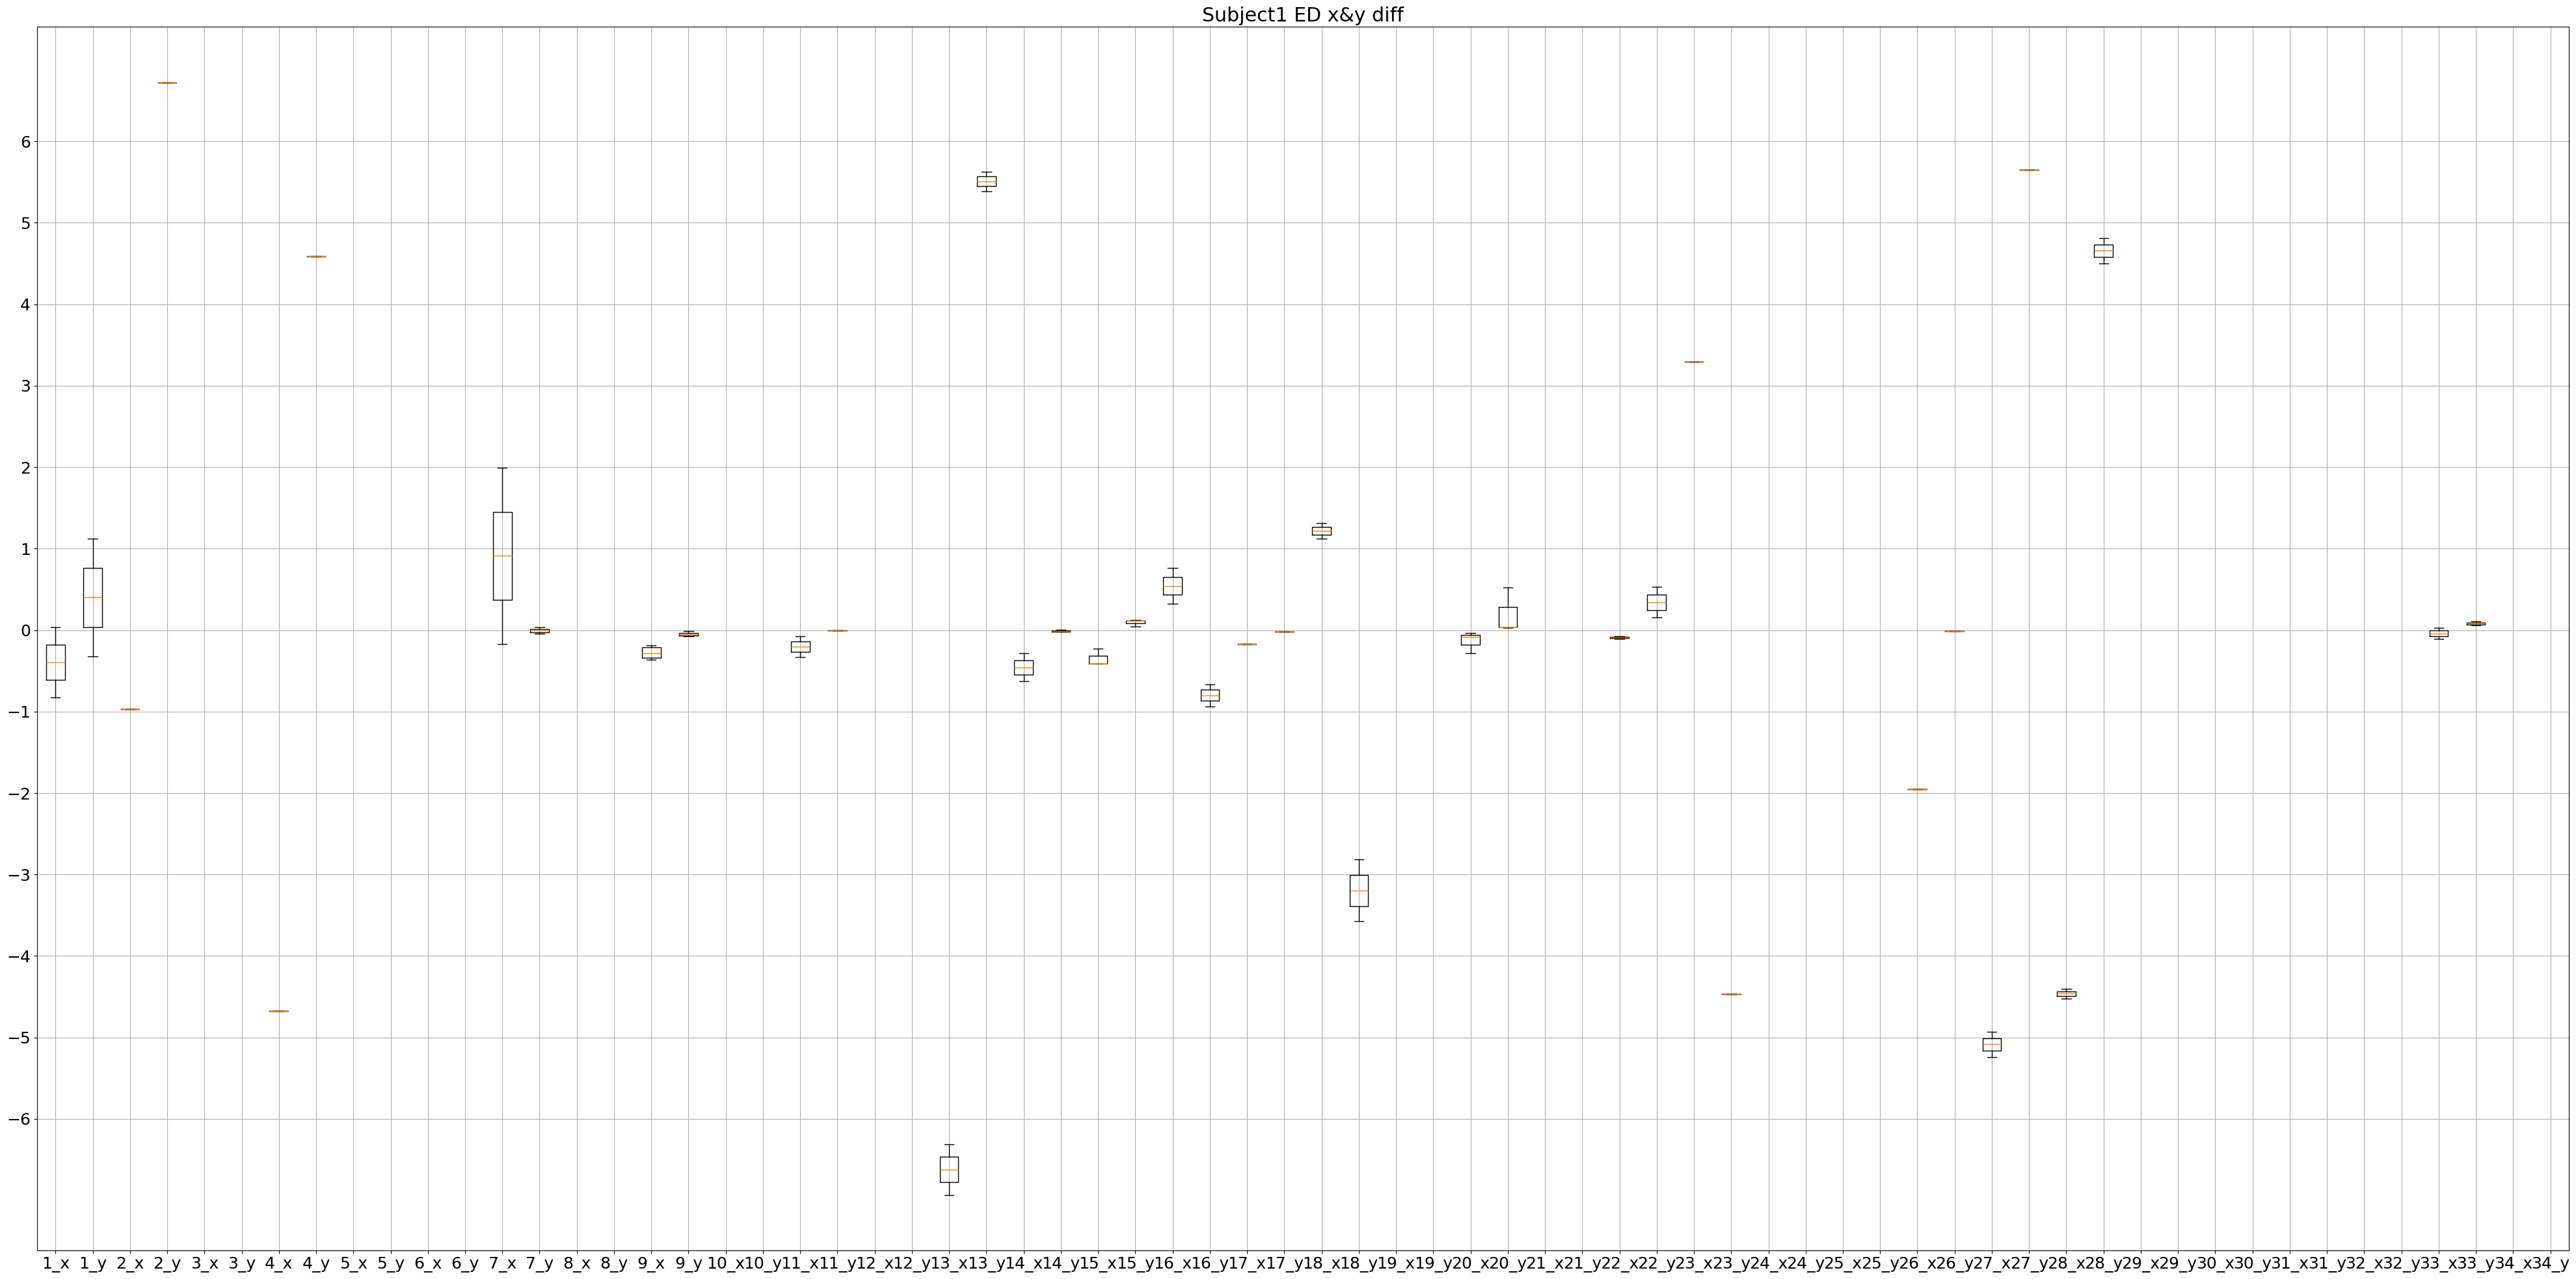

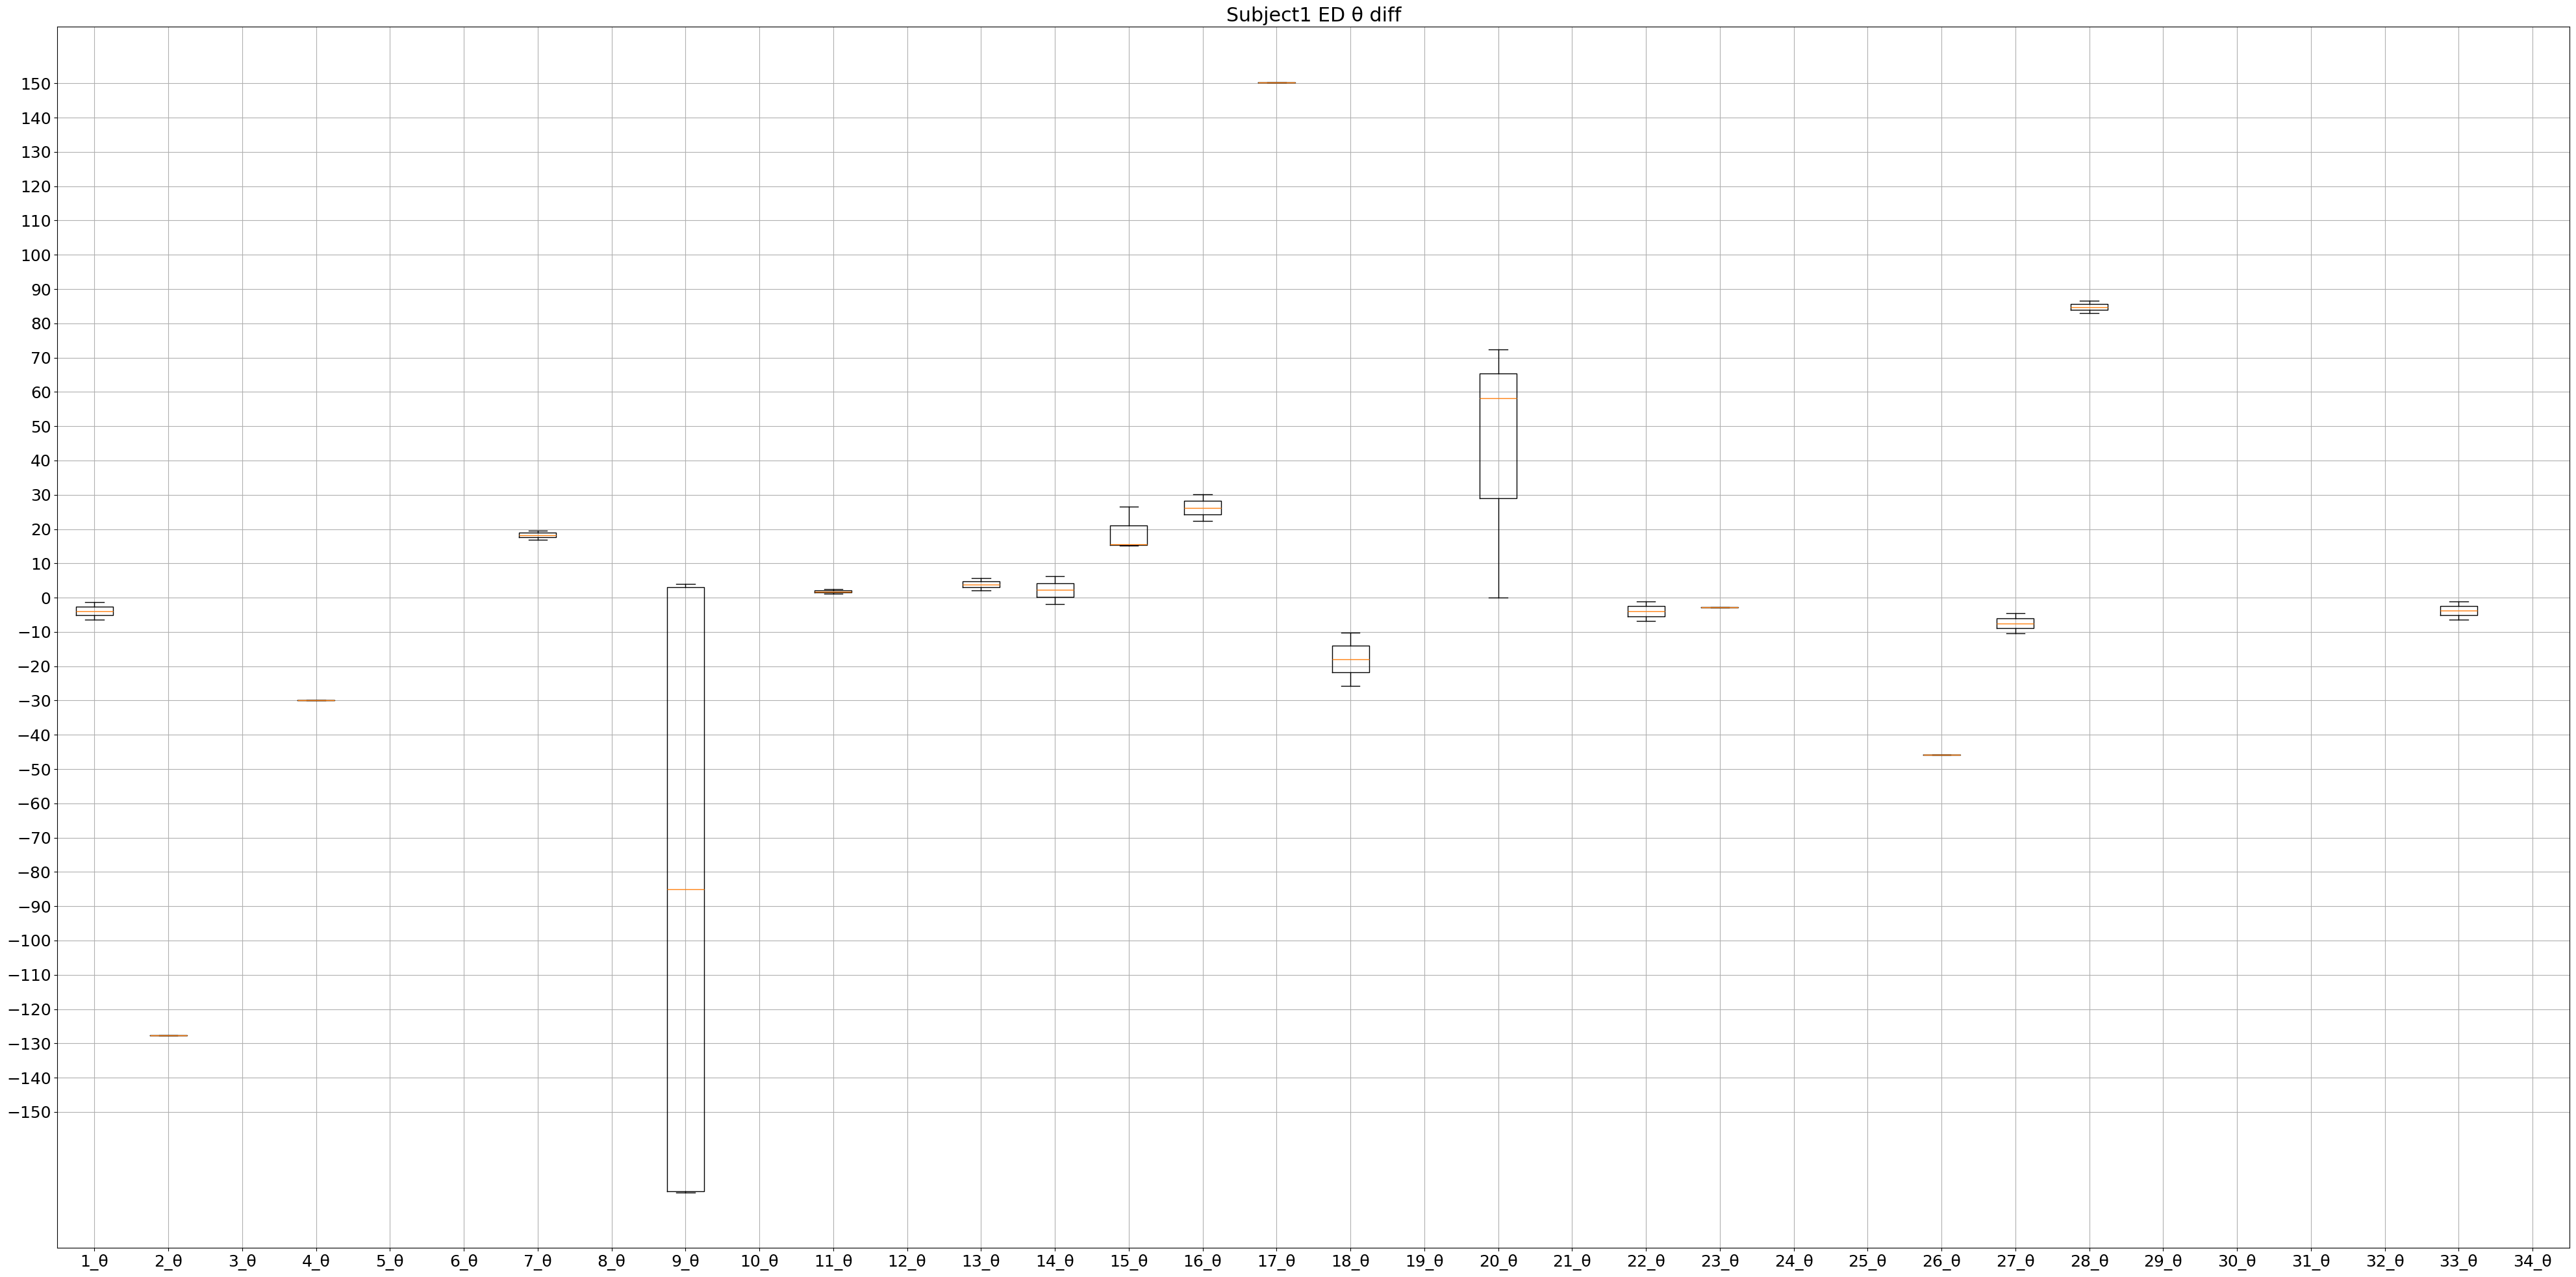

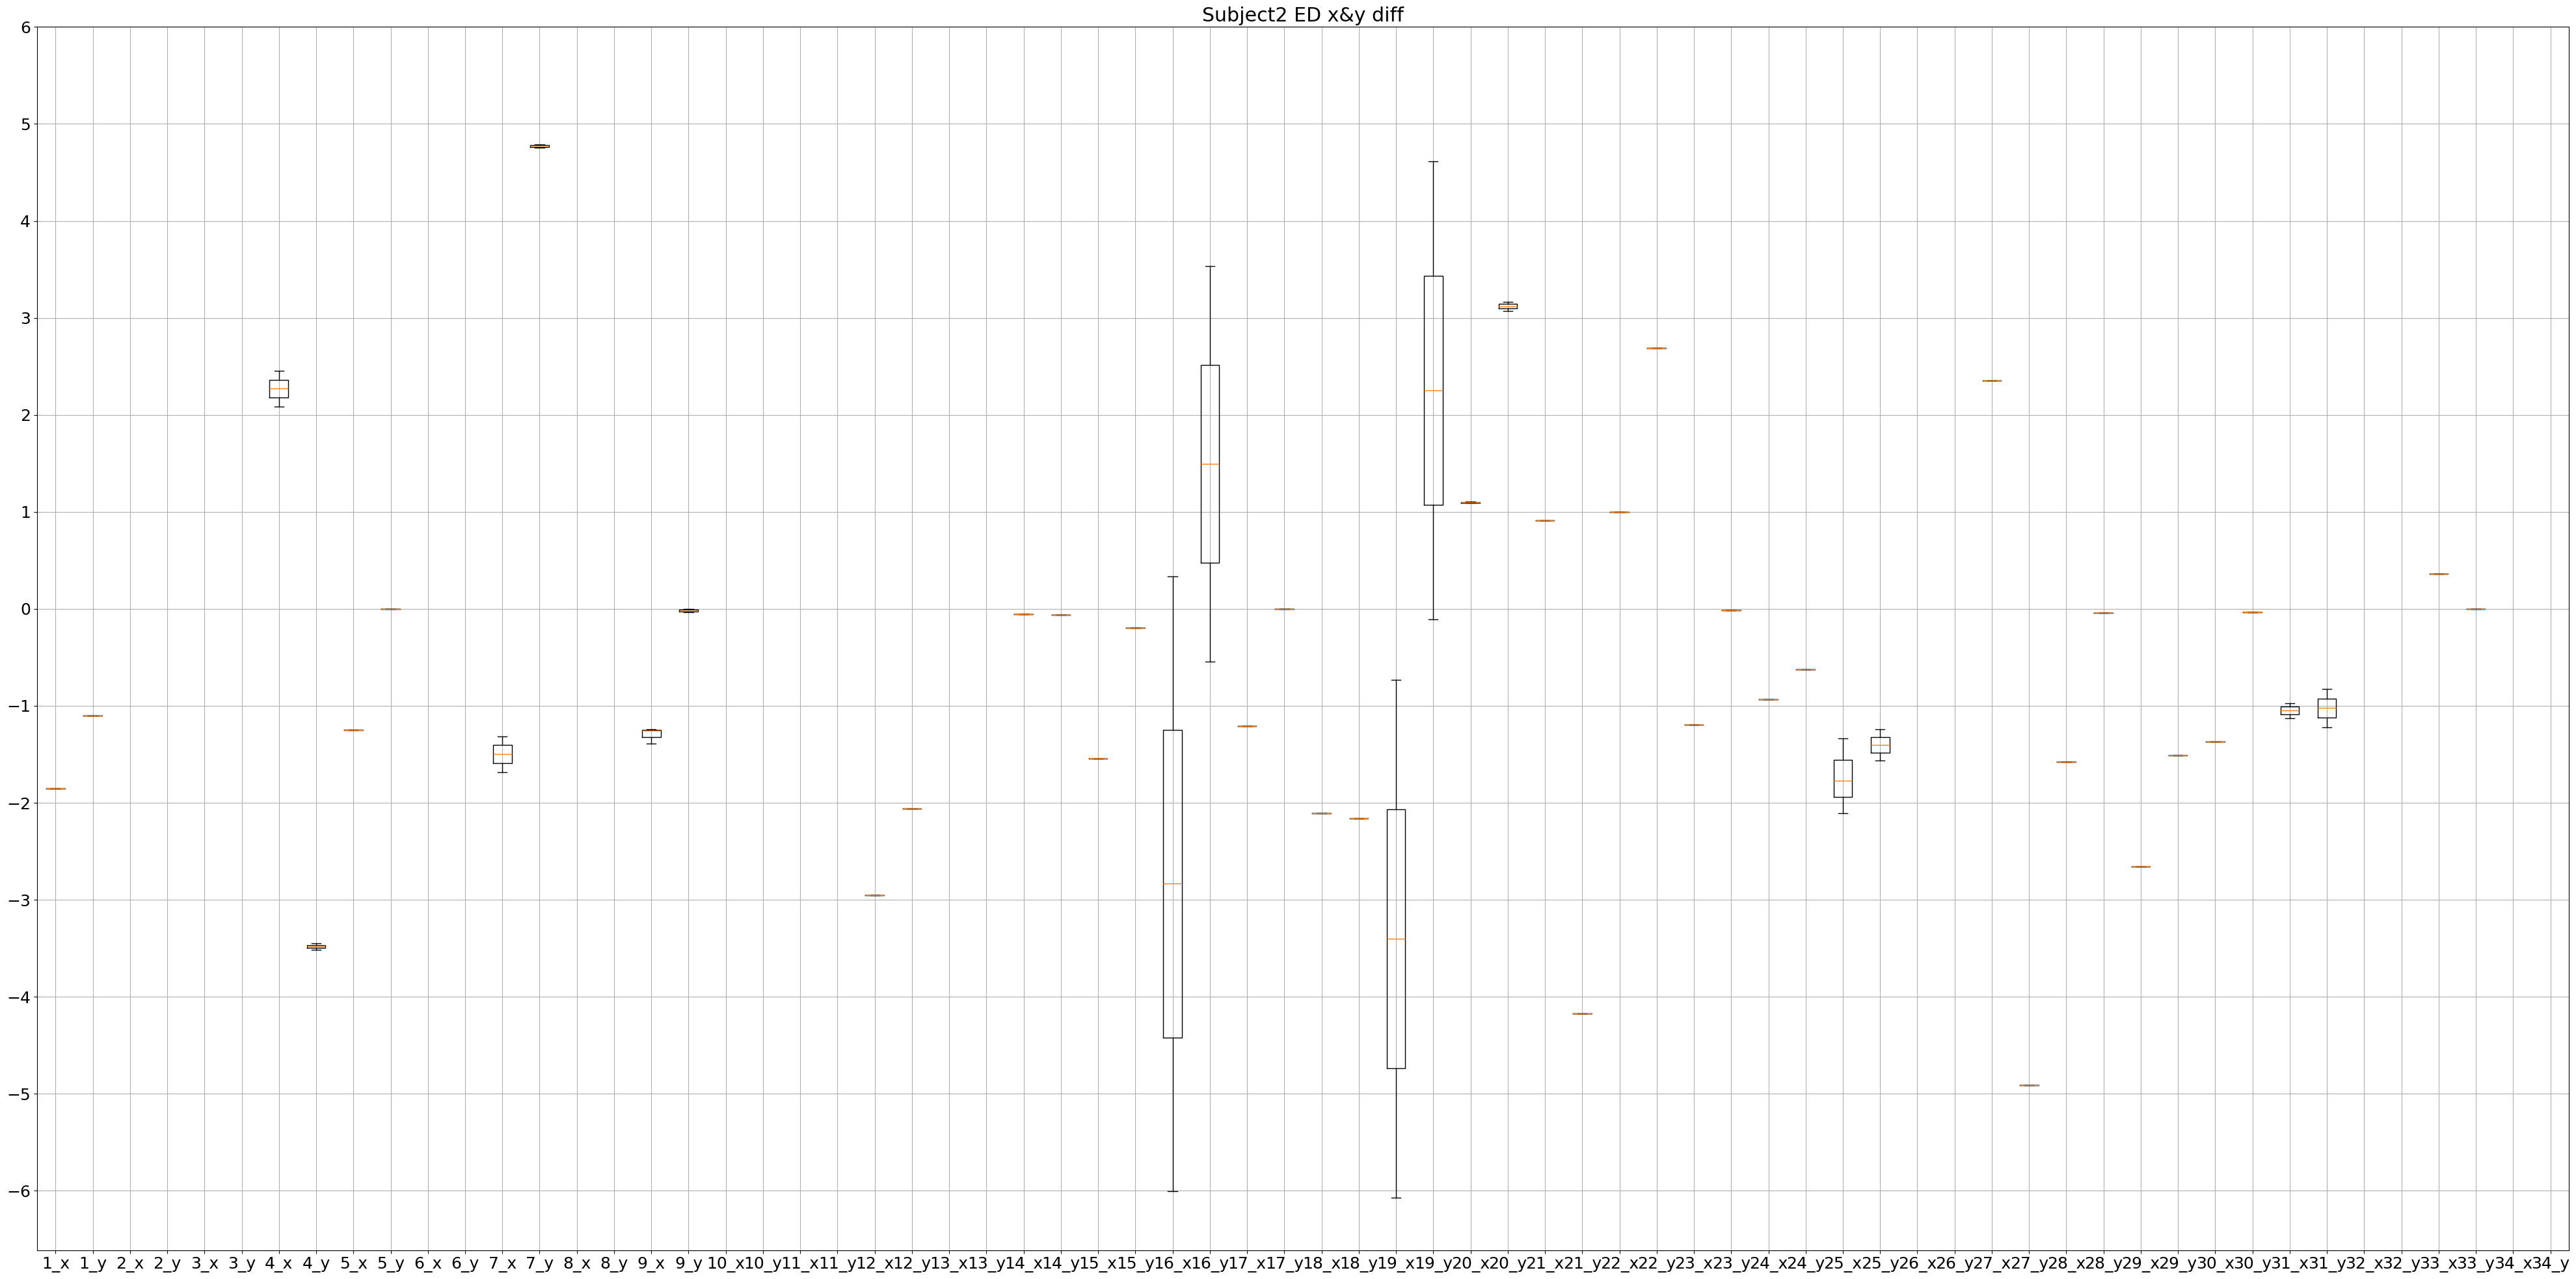

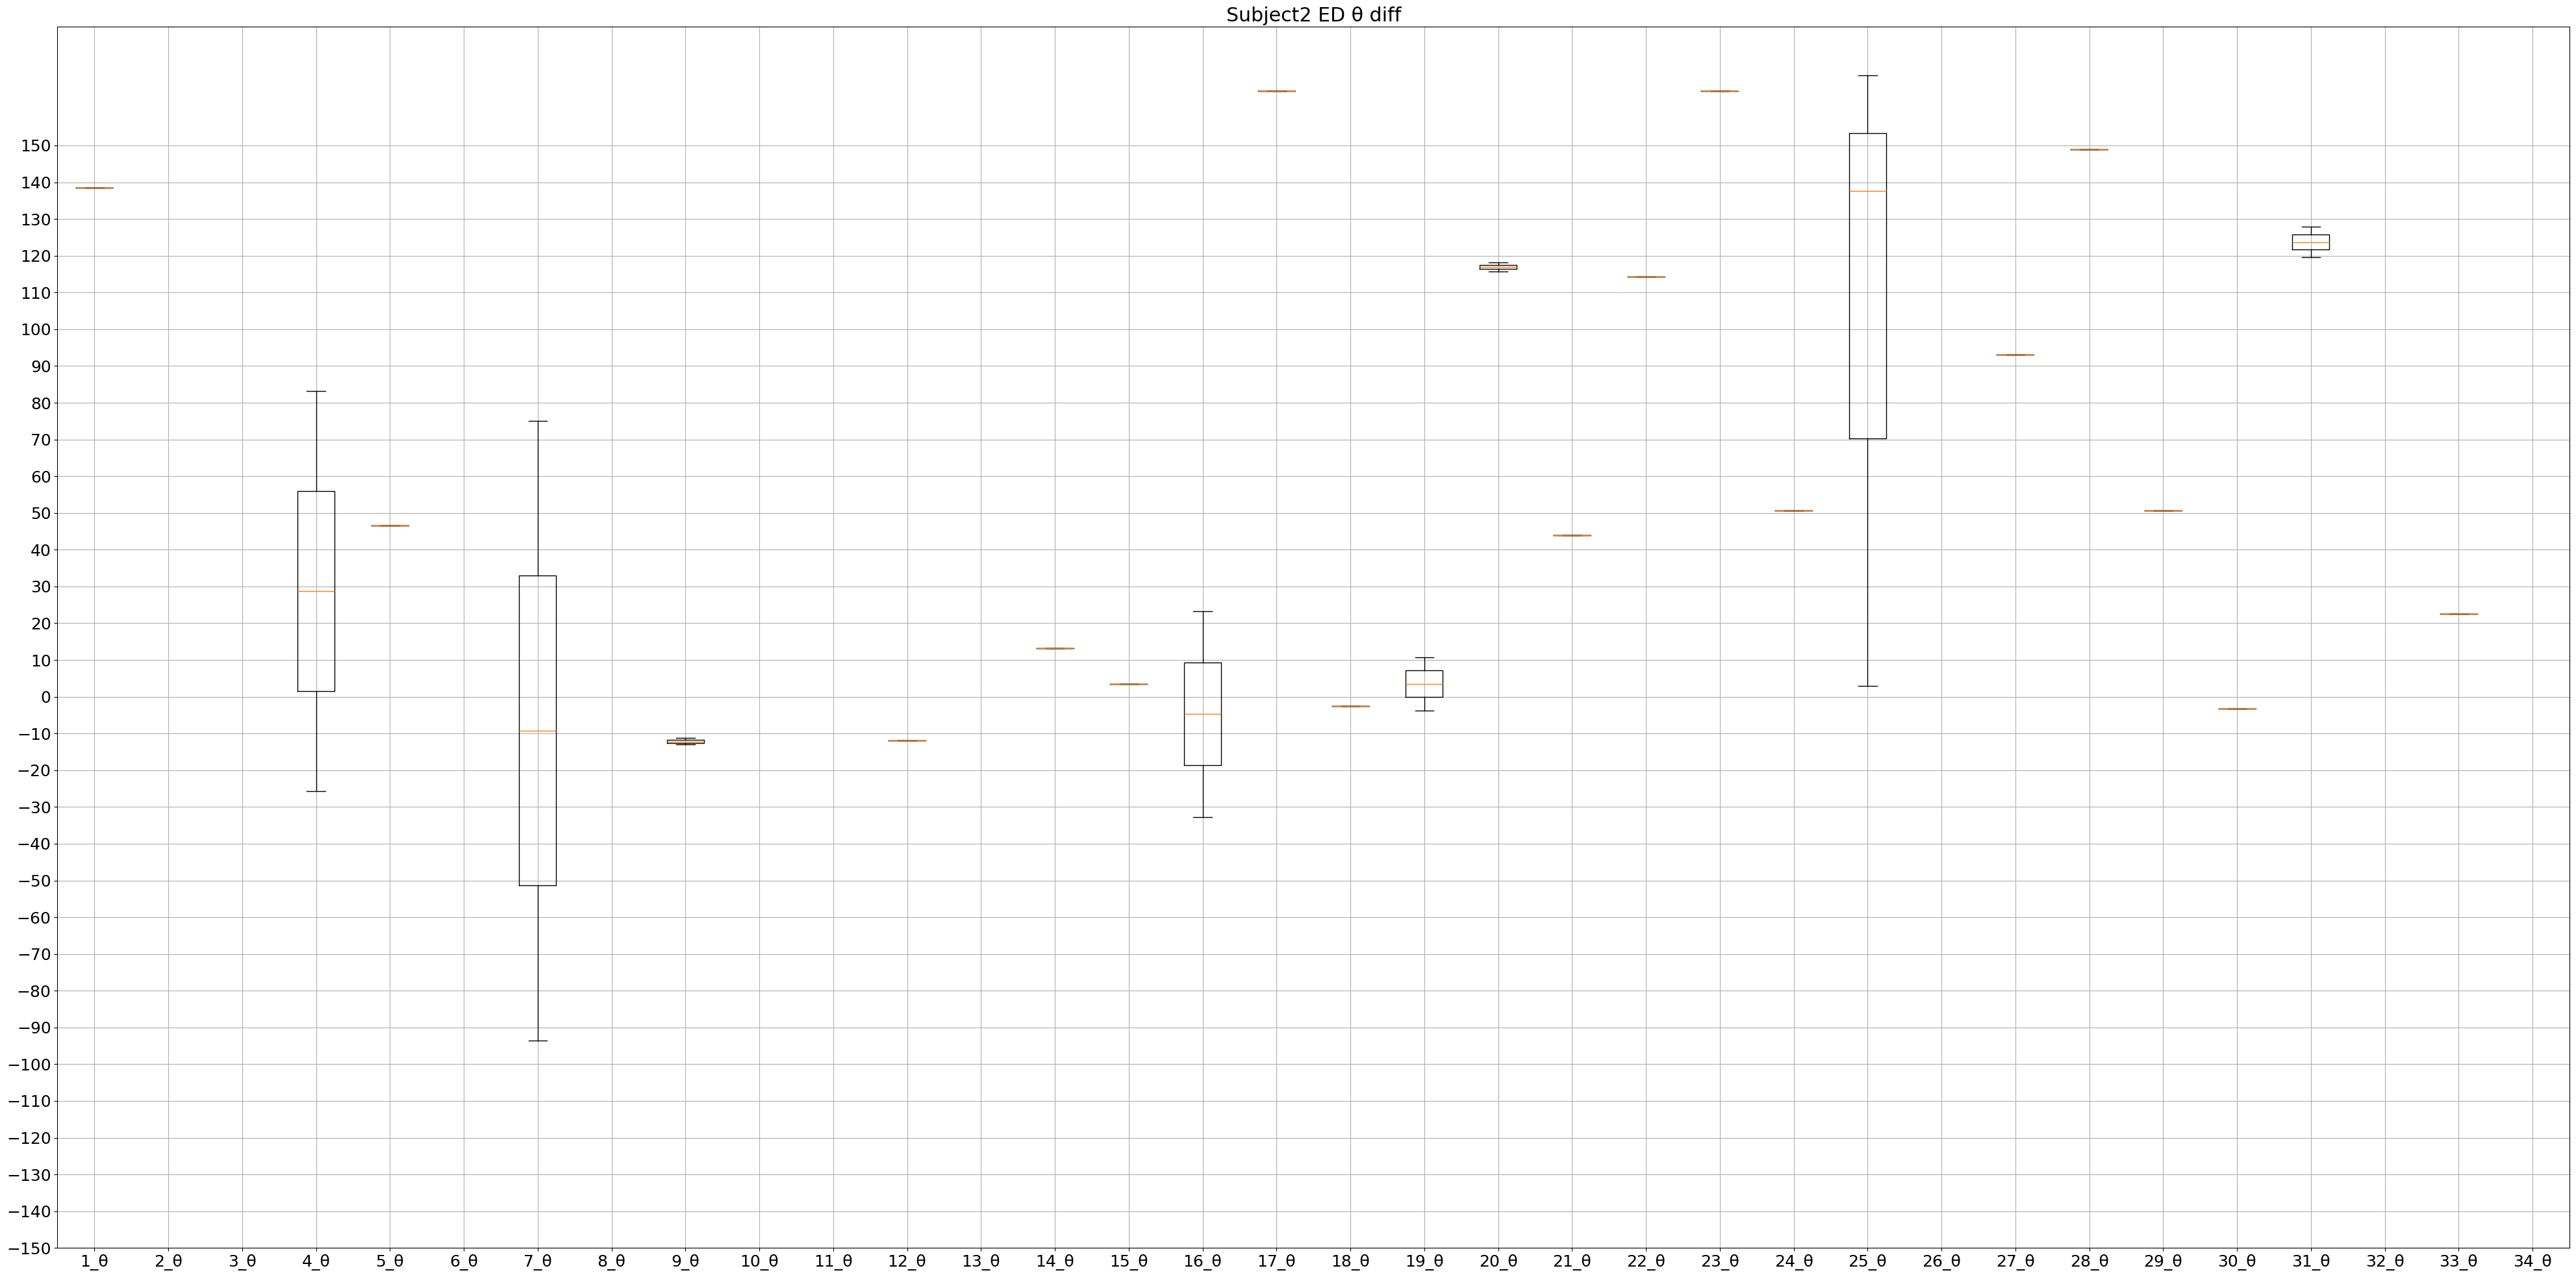

In [78]:
for subject in subjects:
    fig, ax = plt.subplots(figsize=(40,20), tight_layout=True)
    ax.boxplot(ED_xy_list[subject])
    ax.set_xticklabels(['1_x','1_y','2_x','2_y','3_x','3_y','4_x','4_y','5_x','5_y','6_x','6_y','7_x','7_y','8_x','8_y','9_x','9_y','10_x','10_y','11_x','11_y','12_x','12_y','13_x','13_y','14_x','14_y','15_x','15_y','16_x','16_y','17_x','17_y','18_x','18_y','19_x','19_y','20_x','20_y','21_x','21_y','22_x','22_y','23_x','23_y','24_x','24_y','25_x','25_y','26_x','26_y','27_x','27_y','28_x','28_y','29_x','29_y','30_x','30_y','31_x','31_y','32_x','32_y','33_x','33_y','34_x','34_y'])
    plt.title('Subject'+str(subject)+' ED x&y diff')
    plt.rcParams['font.size'] = 18
    plt.grid()
    plt.yticks(range(-6, 7, 1))
    plt.show()

    fig, ax = plt.subplots(figsize=(40,20), tight_layout=True)
    bp = ax.boxplot(ED_theta_list[subject])
    ax.set_xticklabels(['1_θ','2_θ','3_θ','4_θ','5_θ','6_θ','7_θ','8_θ','9_θ','10_θ','11_θ','12_θ','13_θ','14_θ','15_θ','16_θ','17_θ','18_θ','19_θ','20_θ','21_θ','22_θ','23_θ','24_θ','25_θ','26_θ','27_θ','28_θ','29_θ','30_θ','31_θ','32_θ','33_θ','34_θ'])
    plt.title('Subject'+str(subject)+' ED θ diff')
    plt.rcParams['font.size'] = 18
    plt.grid()
    plt.yticks(range(-150, 151, 10))
    plt.show()

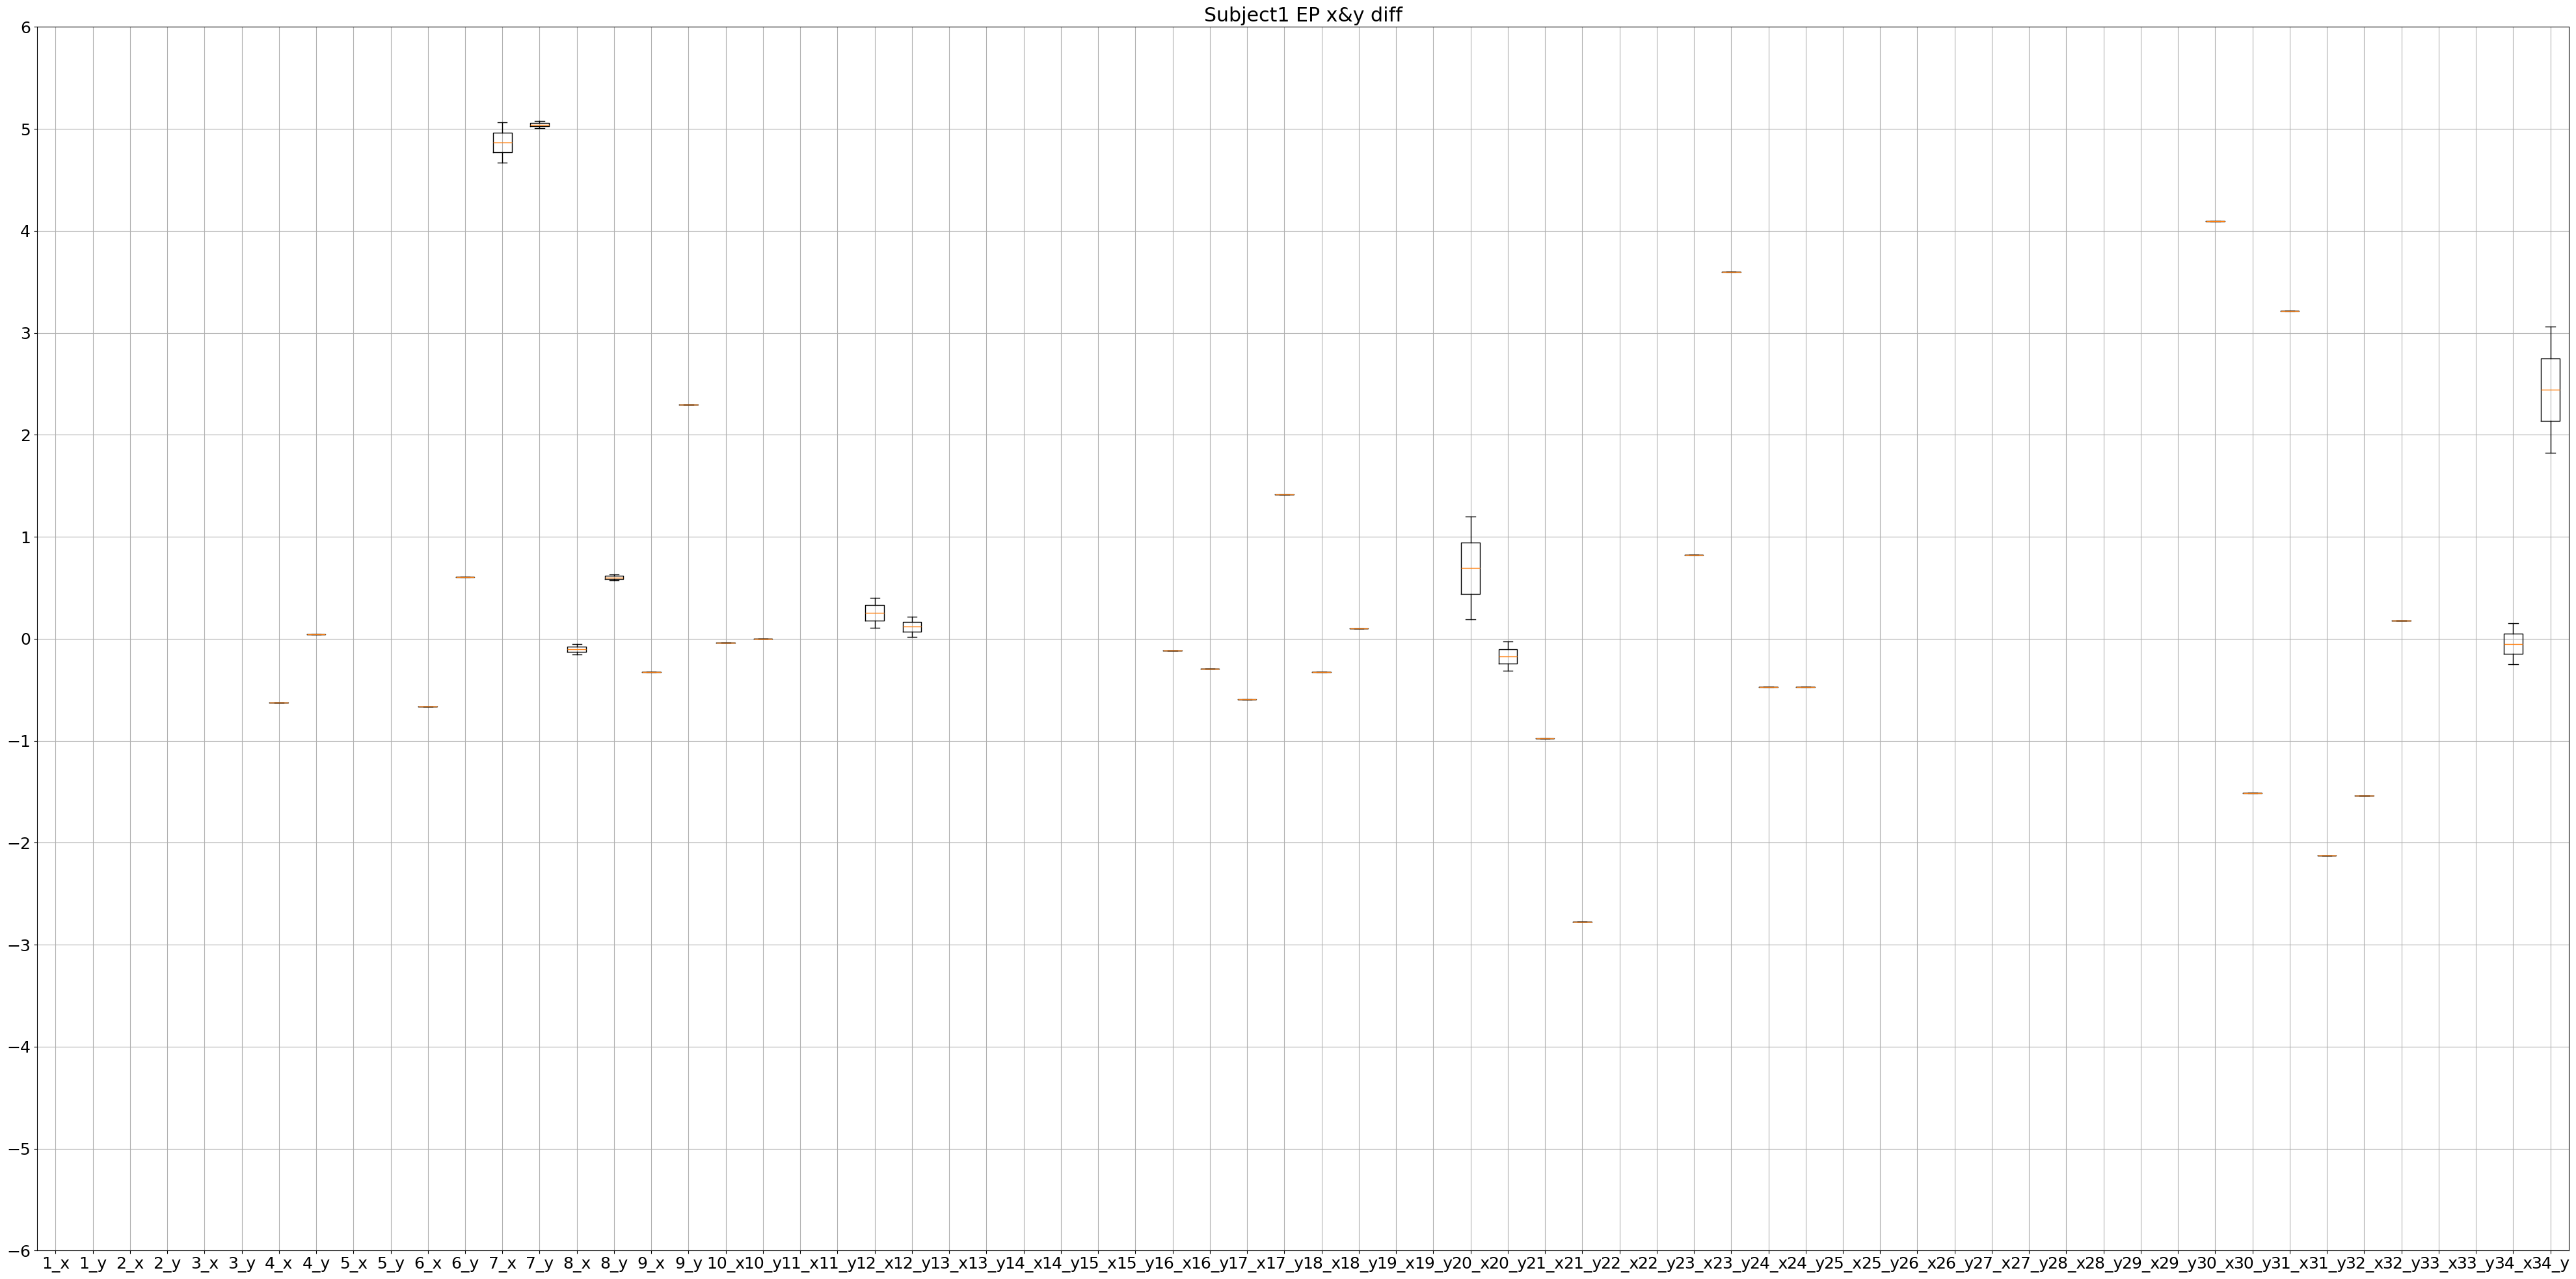

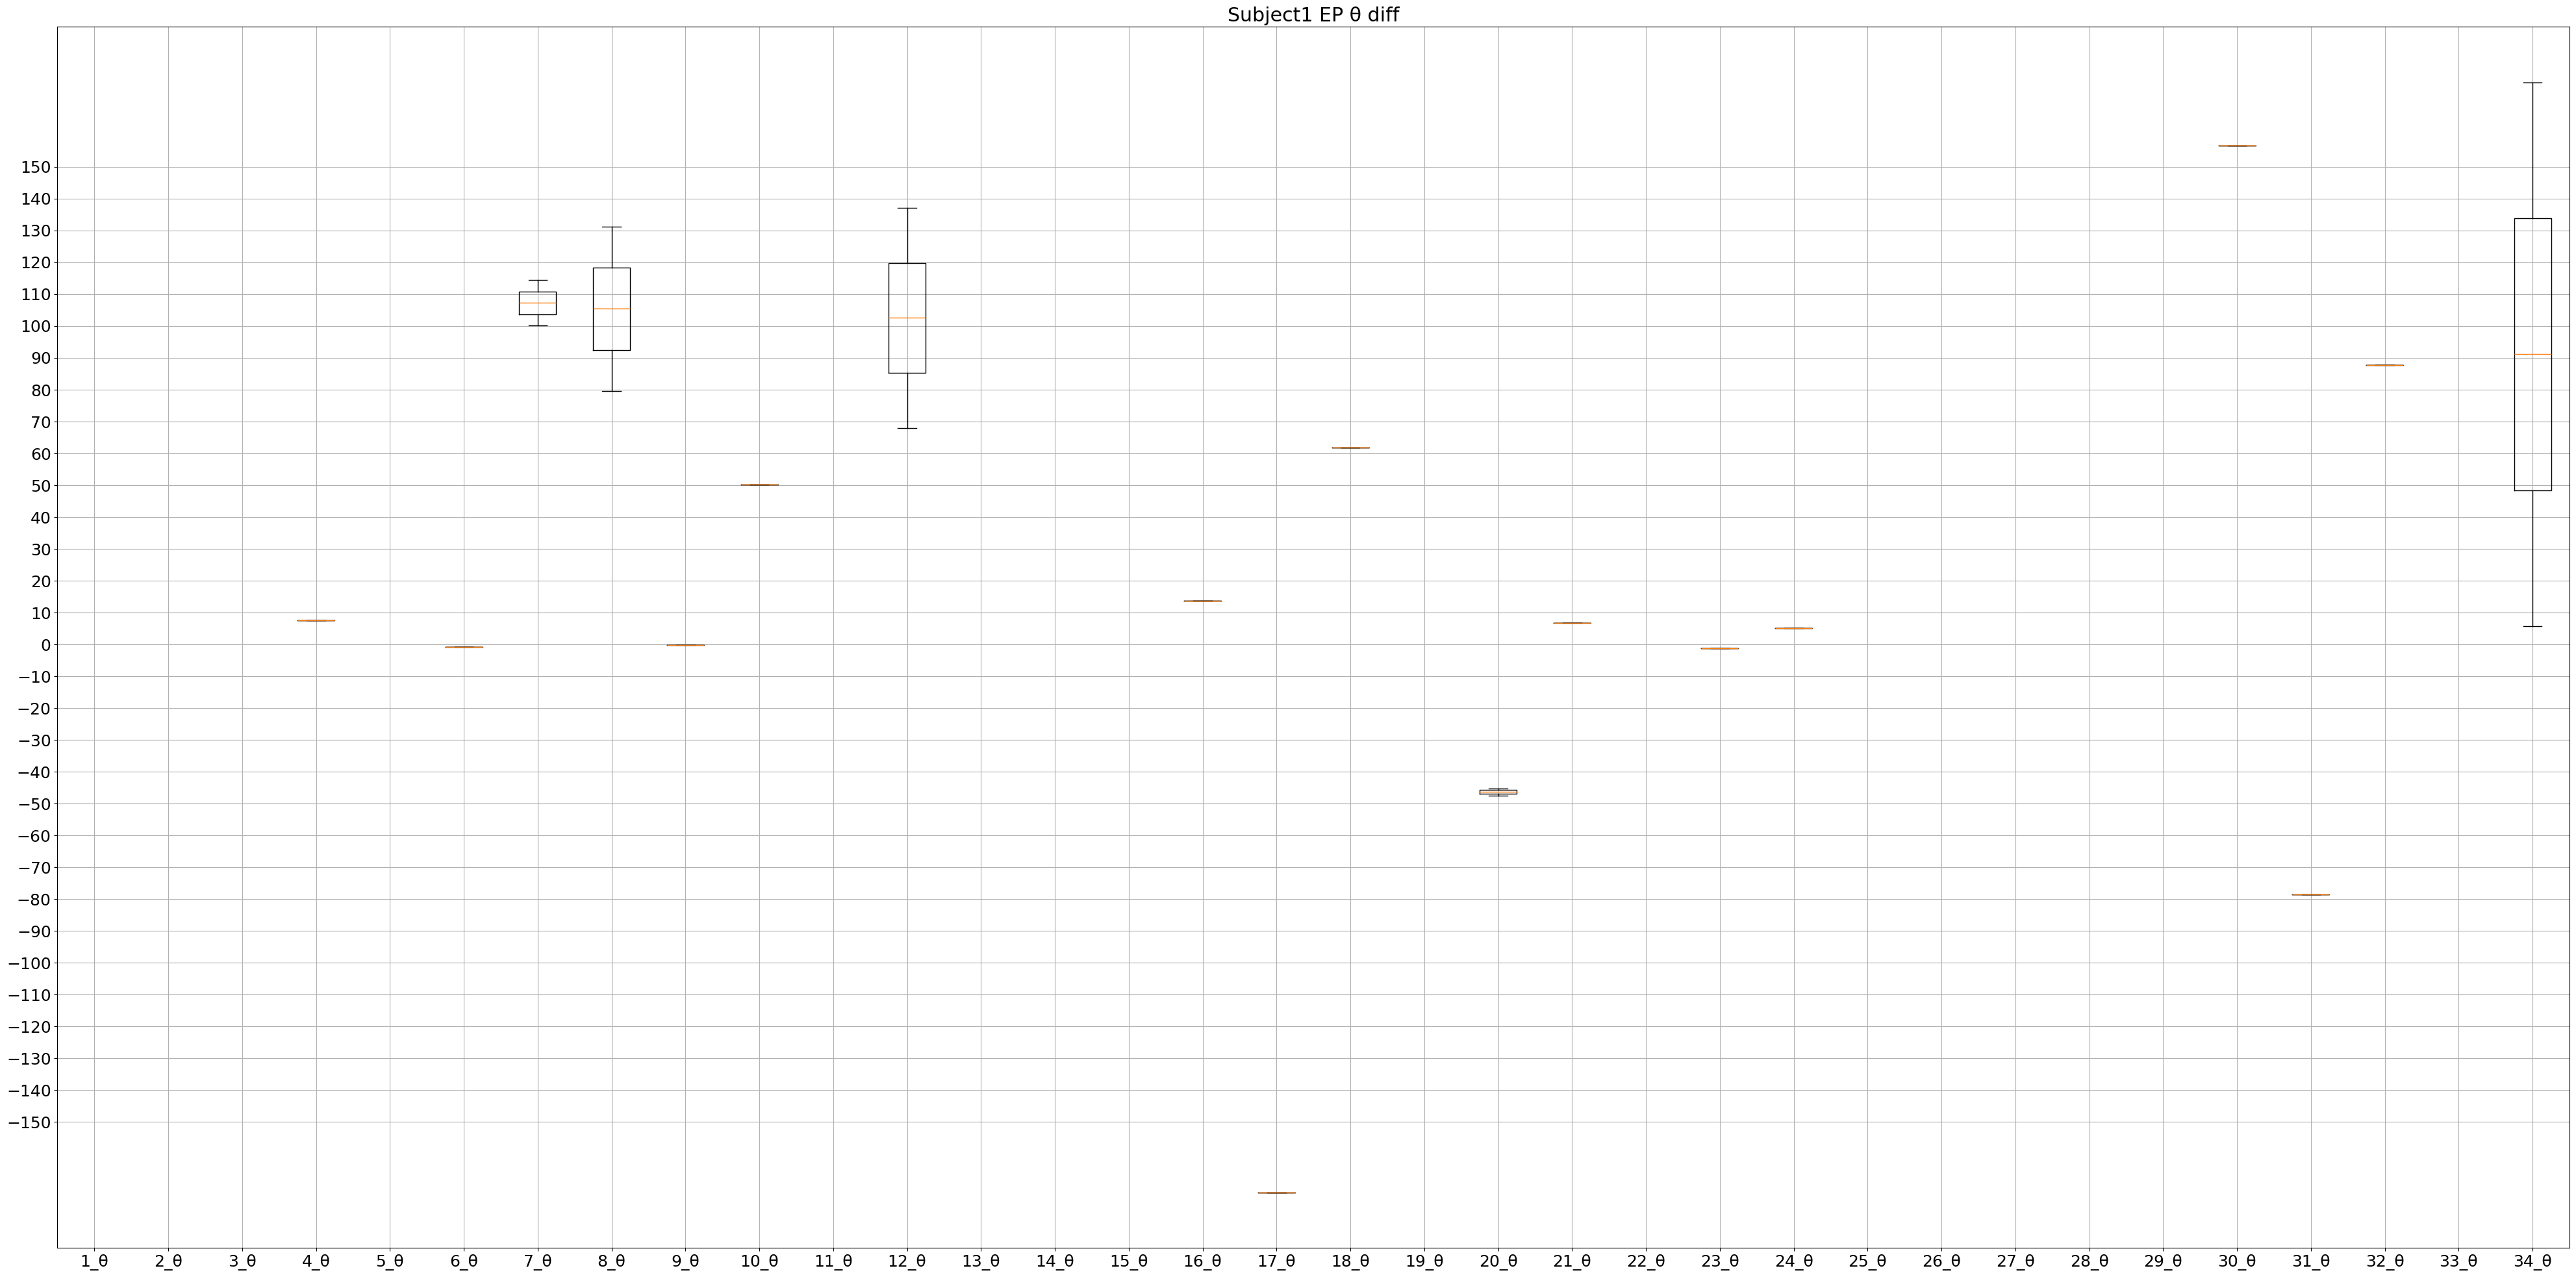

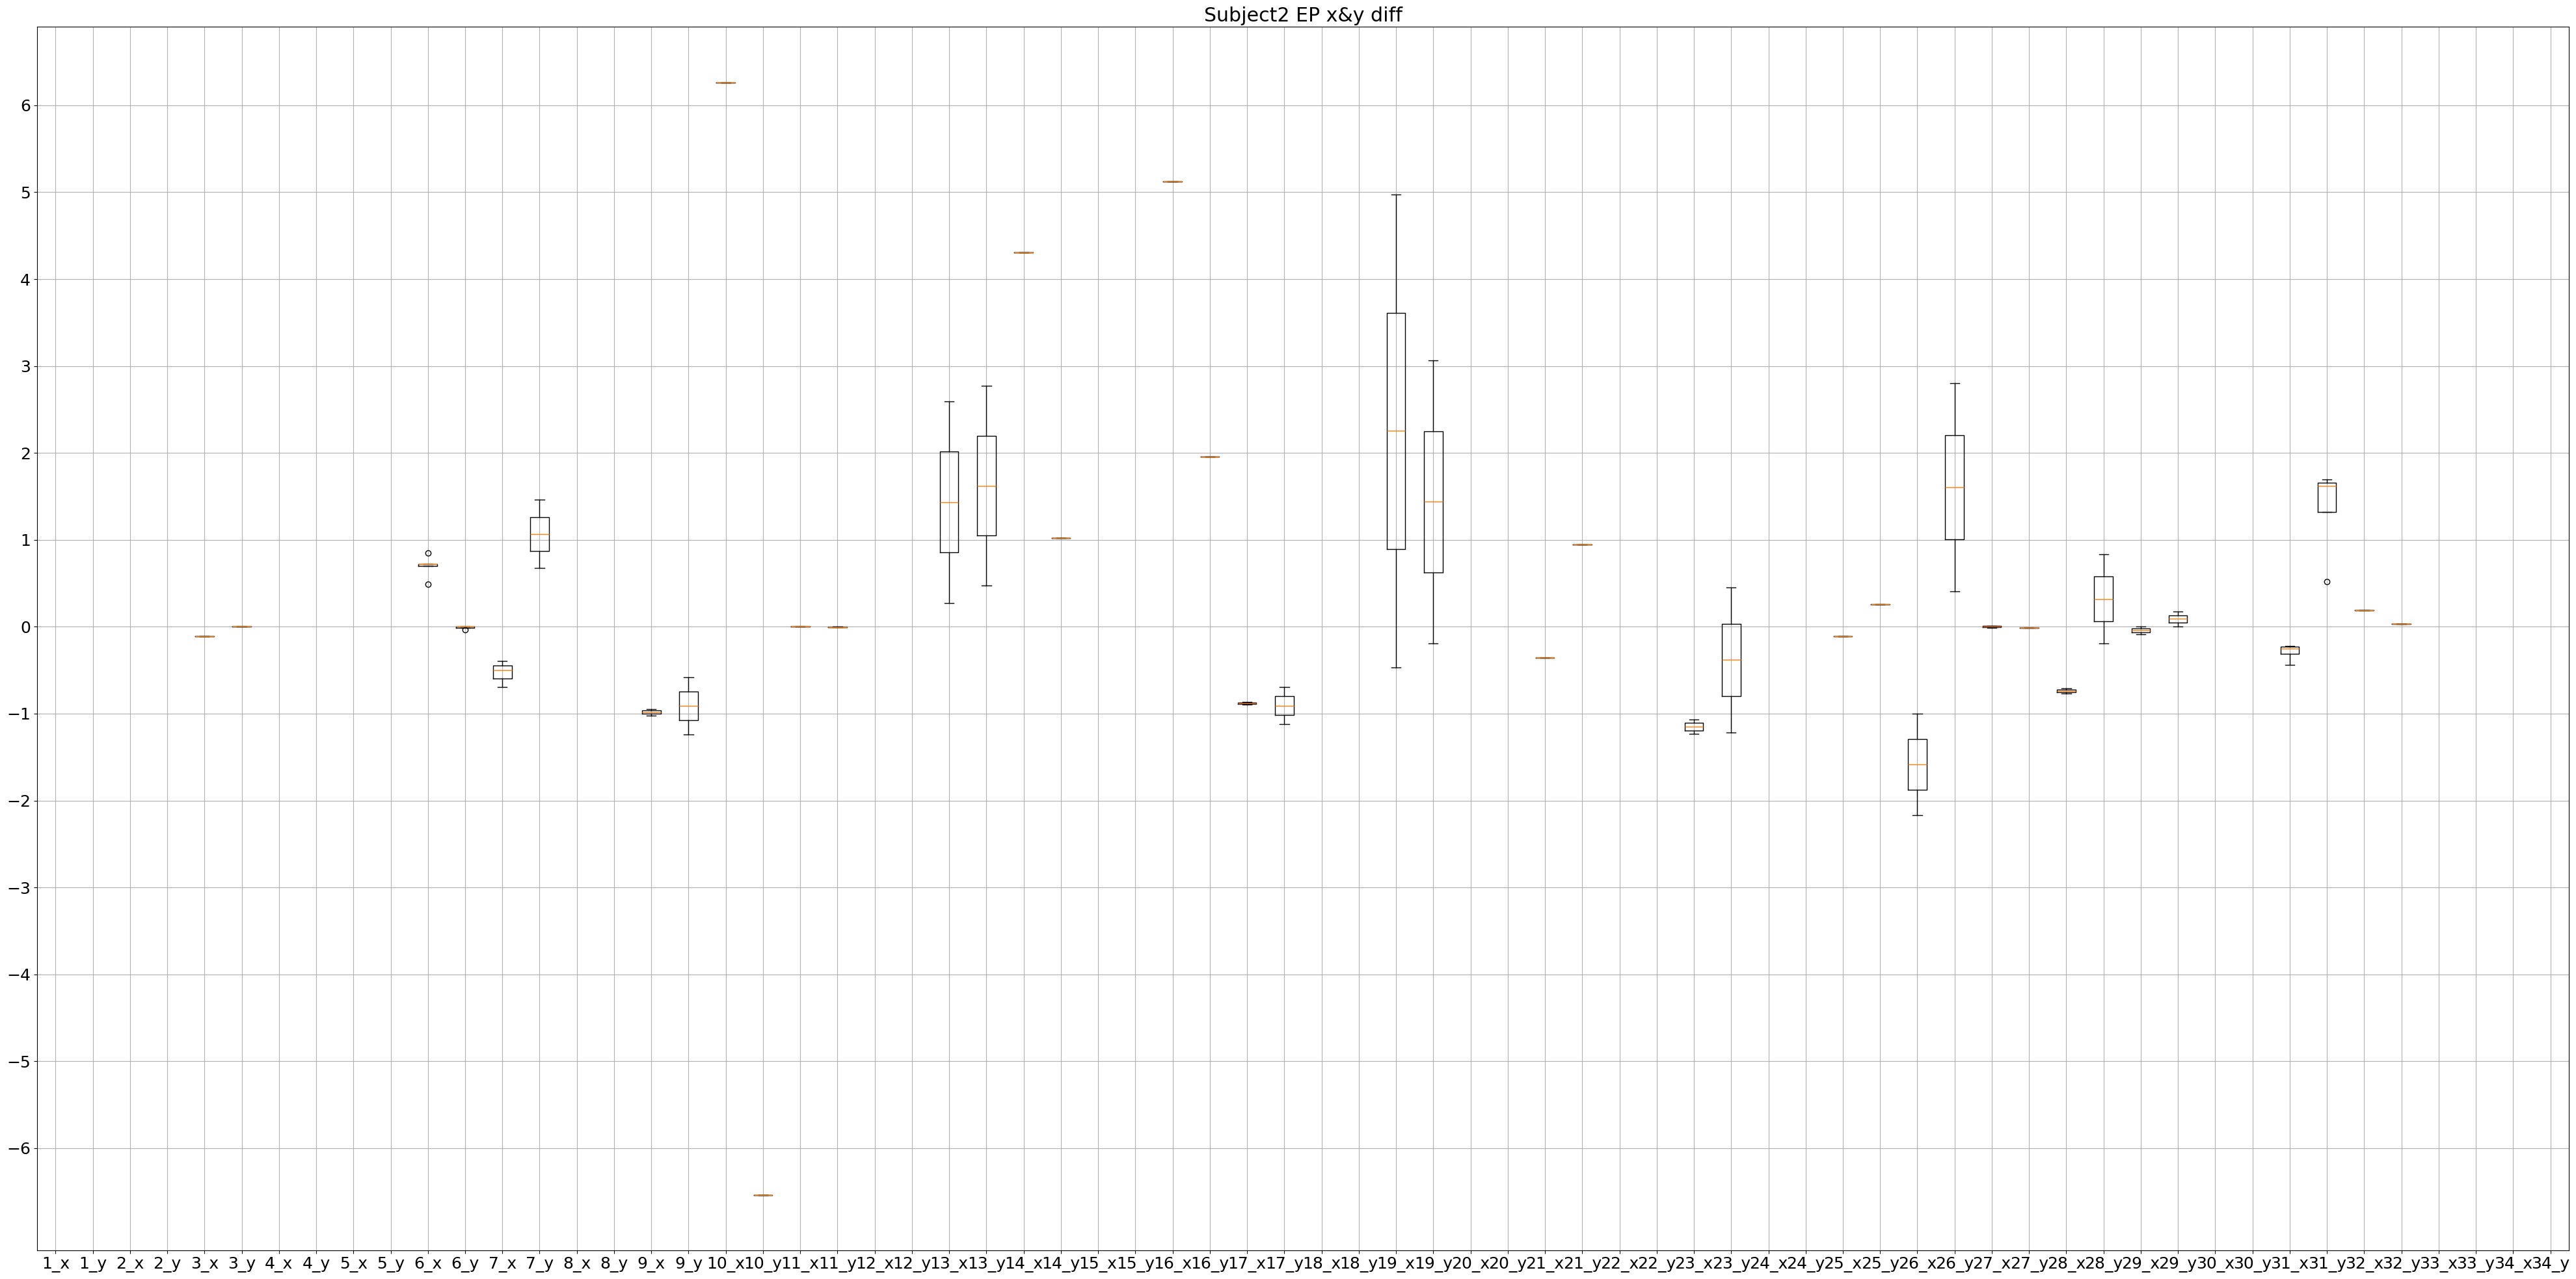

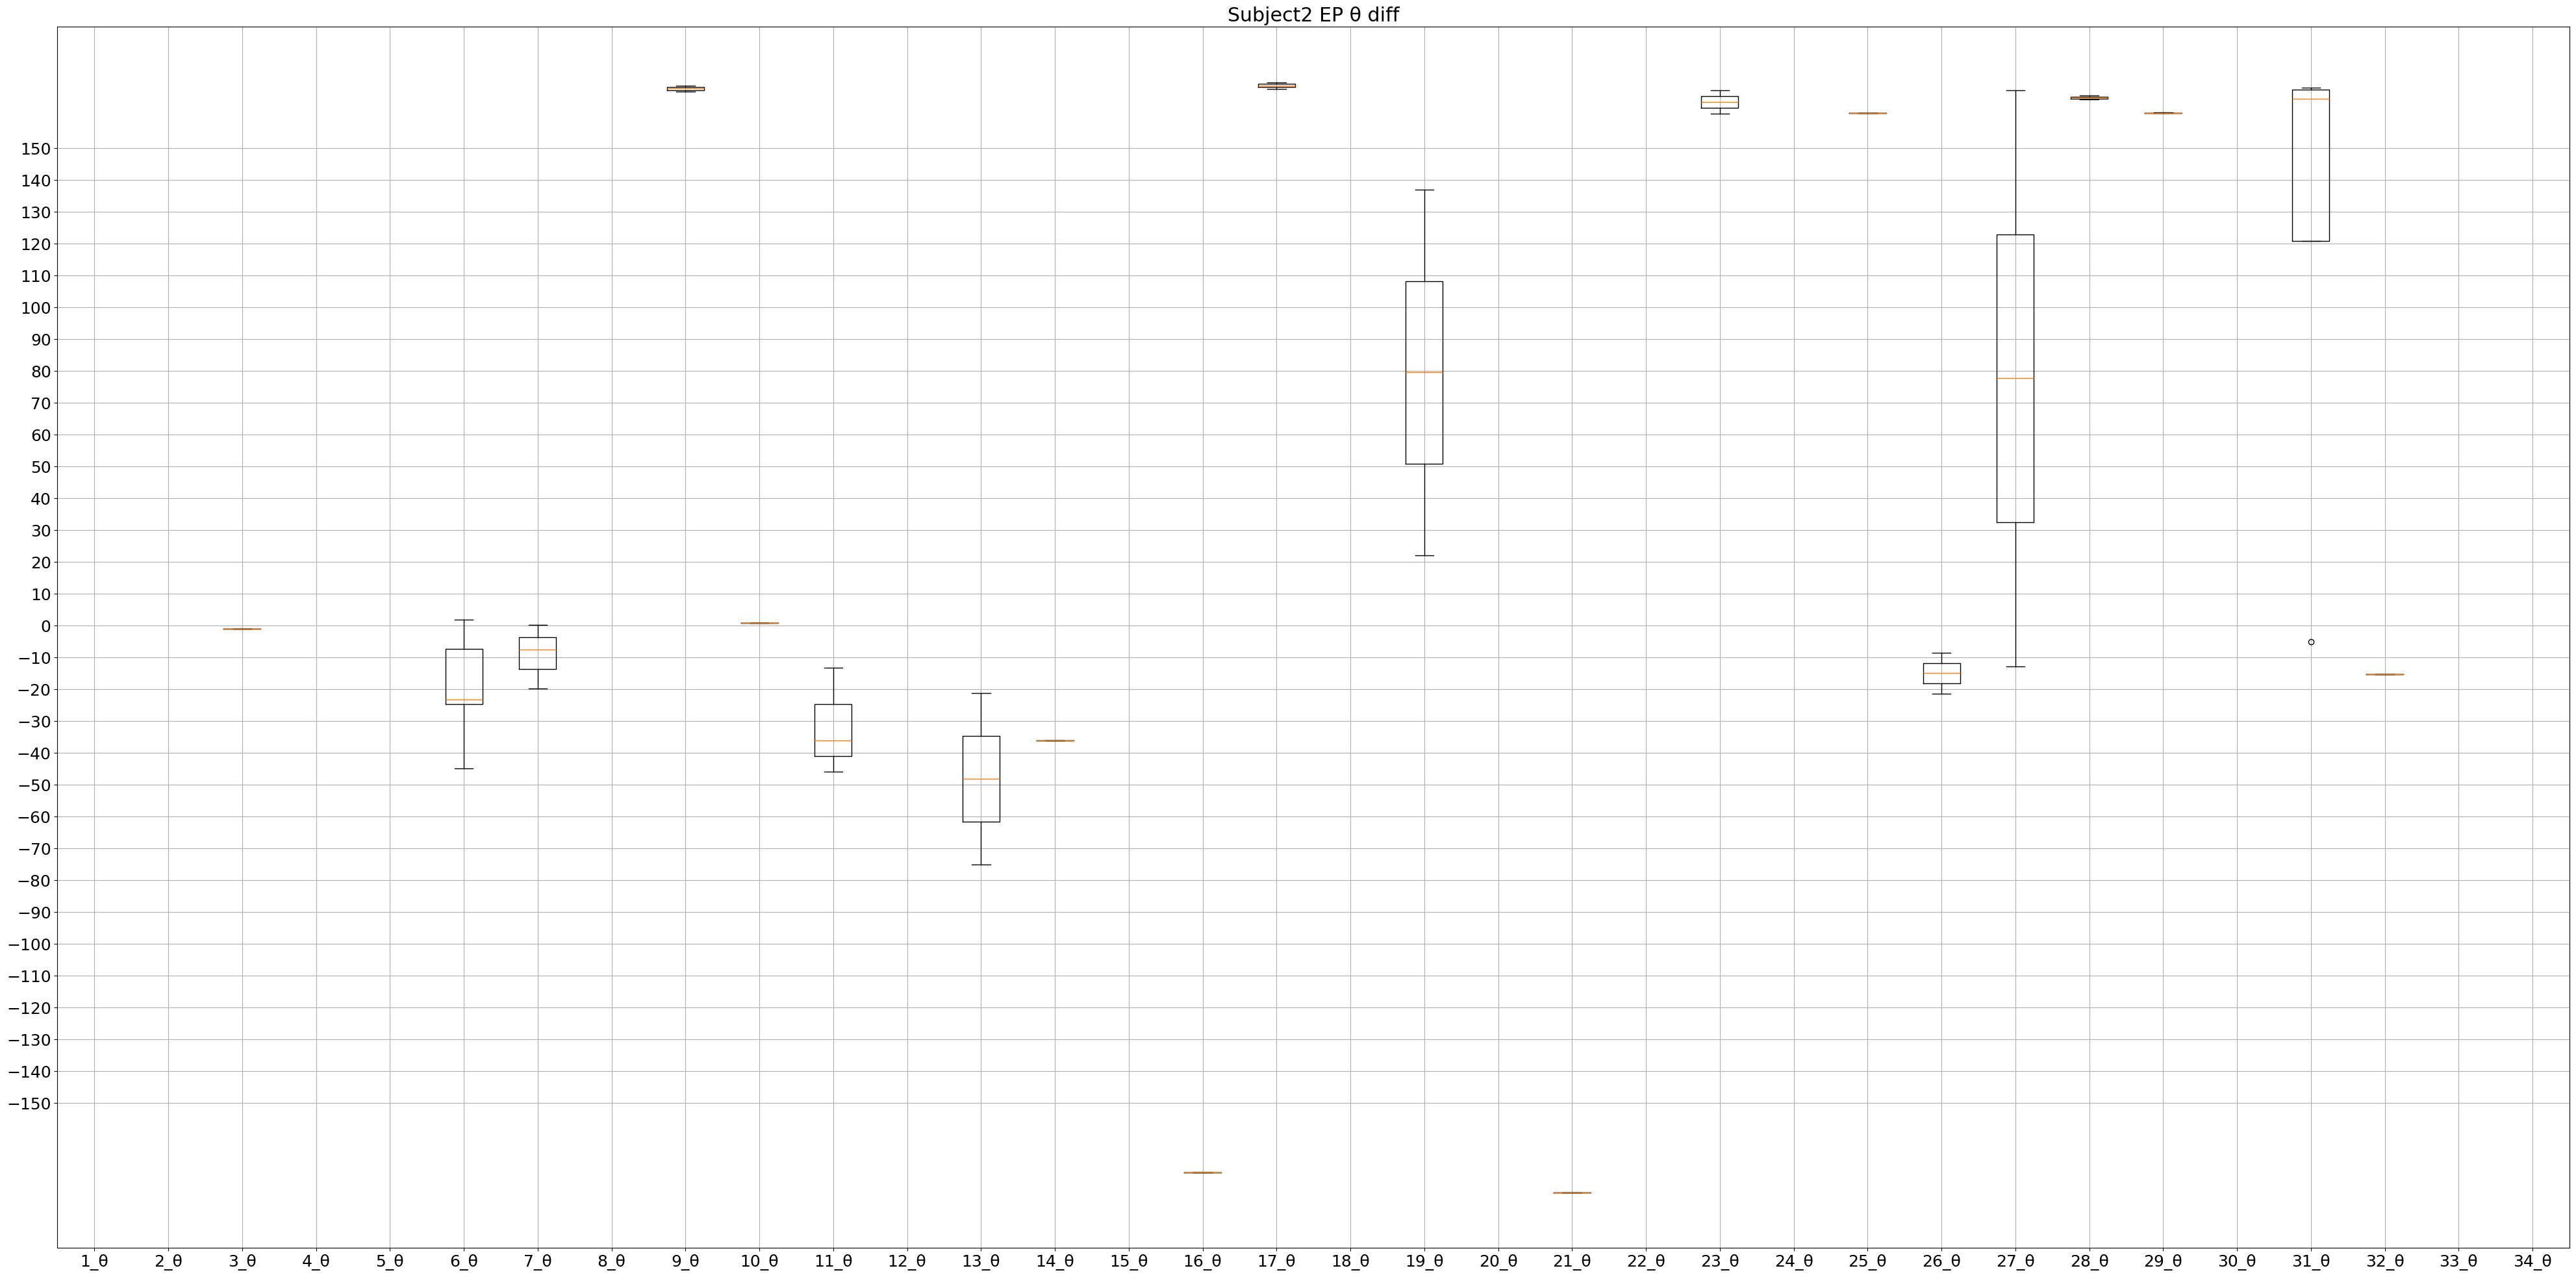

In [79]:
for subject in subjects:
    fig, ax = plt.subplots(figsize=(40,20), tight_layout=True)
    ax.boxplot(EP_xy_list[subject])
    ax.set_xticklabels(['1_x','1_y','2_x','2_y','3_x','3_y','4_x','4_y','5_x','5_y','6_x','6_y','7_x','7_y','8_x','8_y','9_x','9_y','10_x','10_y','11_x','11_y','12_x','12_y','13_x','13_y','14_x','14_y','15_x','15_y','16_x','16_y','17_x','17_y','18_x','18_y','19_x','19_y','20_x','20_y','21_x','21_y','22_x','22_y','23_x','23_y','24_x','24_y','25_x','25_y','26_x','26_y','27_x','27_y','28_x','28_y','29_x','29_y','30_x','30_y','31_x','31_y','32_x','32_y','33_x','33_y','34_x','34_y'])
    plt.title('Subject'+str(subject)+' EP x&y diff')
    plt.rcParams['font.size'] = 18
    plt.grid()
    plt.yticks(range(-6, 7, 1))
    plt.show()

    fig, ax = plt.subplots(figsize=(40,20), tight_layout=True)
    bp = ax.boxplot(EP_theta_list[subject])
    ax.set_xticklabels(['1_θ','2_θ','3_θ','4_θ','5_θ','6_θ','7_θ','8_θ','9_θ','10_θ','11_θ','12_θ','13_θ','14_θ','15_θ','16_θ','17_θ','18_θ','19_θ','20_θ','21_θ','22_θ','23_θ','24_θ','25_θ','26_θ','27_θ','28_θ','29_θ','30_θ','31_θ','32_θ','33_θ','34_θ'])
    plt.title('Subject'+str(subject)+' EP θ diff')
    plt.rcParams['font.size'] = 18
    plt.grid()
    plt.yticks(range(-150, 151, 10))
    plt.show()

## 各subjectでの全ジェスチャーの平均値

In [80]:
x_ED_gesture_mean = {}
y_ED_gesture_mean = {}
theta_ED_gesture_mean = {}
x_EP_gesture_mean = {}
y_EP_gesture_mean = {}
theta_EP_gesture_mean = {}
x_FD_gesture_mean = {}
y_FD_gesture_mean = {}
theta_FD_gesture_mean = {}
x_FP_gesture_mean = {}
y_FP_gesture_mean = {}
theta_FP_gesture_mean = {}
for subject in subjects:
    x_ED_gesture_mean[subject] = {'value':[], 'mean':0, 'std':0}
    y_ED_gesture_mean[subject] = {'value':[], 'mean':0, 'std':0}
    theta_ED_gesture_mean[subject] = {'value':[], 'mean':0, 'std':0}
    x_EP_gesture_mean[subject] = {'value':[], 'mean':0, 'std':0}
    y_EP_gesture_mean[subject] = {'value':[], 'mean':0, 'std':0}
    theta_EP_gesture_mean[subject] = {'value':[], 'mean':0, 'std':0}
    x_FD_gesture_mean[subject] = {'value':[], 'mean':0, 'std':0}
    y_FD_gesture_mean[subject] = {'value':[], 'mean':0, 'std':0}
    theta_FD_gesture_mean[subject] = {'value':[], 'mean':0, 'std':0}
    x_FP_gesture_mean[subject] = {'value':[], 'mean':0, 'std':0}
    y_FP_gesture_mean[subject] = {'value':[], 'mean':0, 'std':0}
    theta_FP_gesture_mean[subject] = {'value':[], 'mean':0, 'std':0}
    for i in range(n_gestures):
        for l in range(len(x_ED_gesture[subject][i+1])):
            x_ED_gesture_mean[subject]['value'].append(x_ED_gesture[subject][i+1][l])
            y_ED_gesture_mean[subject]['value'].append(y_ED_gesture[subject][i+1][l])
            theta_ED_gesture_mean[subject]['value'].append(theta_ED_gesture[subject][i+1][l])
        for l in range(len(x_EP_gesture[subject][i+1])):
            x_EP_gesture_mean[subject]['value'].append(x_EP_gesture[subject][i+1][l])
            y_EP_gesture_mean[subject]['value'].append(y_EP_gesture[subject][i+1][l])
            theta_EP_gesture_mean[subject]['value'].append(theta_EP_gesture[subject][i+1][l])
        for l in range(len(x_FD_gesture[subject][i+1])):
            x_FD_gesture_mean[subject]['value'].append(x_FD_gesture[subject][i+1][l])
            y_FD_gesture_mean[subject]['value'].append(y_FD_gesture[subject][i+1][l])
            theta_FD_gesture_mean[subject]['value'].append(theta_FD_gesture[subject][i+1][l])
        for l in range(len(x_FP_gesture[subject][i+1])):
            x_FP_gesture_mean[subject]['value'].append(x_FP_gesture[subject][i+1][l])
            y_FP_gesture_mean[subject]['value'].append(y_FP_gesture[subject][i+1][l])
            theta_FP_gesture_mean[subject]['value'].append(theta_FP_gesture[subject][i+1][l])
    x_ED_gesture_mean[subject]['mean'] = np.mean(x_ED_gesture_mean[subject]['value'])
    x_ED_gesture_mean[subject]['std'] = np.std(x_ED_gesture_mean[subject]['value'])
    y_ED_gesture_mean[subject]['mean'] = np.mean(y_ED_gesture_mean[subject]['value'])
    y_ED_gesture_mean[subject]['std'] = np.std(y_ED_gesture_mean[subject]['value'])
    theta_ED_gesture_mean[subject]['mean'] = np.mean(theta_ED_gesture_mean[subject]['value'])
    theta_ED_gesture_mean[subject]['std'] = np.std(theta_ED_gesture_mean[subject]['value'])
    x_EP_gesture_mean[subject]['mean'] = np.mean(x_EP_gesture_mean[subject]['value'])
    x_EP_gesture_mean[subject]['std'] = np.std(x_EP_gesture_mean[subject]['value'])
    y_EP_gesture_mean[subject]['mean'] = np.mean(y_EP_gesture_mean[subject]['value'])
    y_EP_gesture_mean[subject]['std'] = np.std(y_EP_gesture_mean[subject]['value'])
    theta_EP_gesture_mean[subject]['mean'] = np.mean(theta_EP_gesture_mean[subject]['value'])
    theta_EP_gesture_mean[subject]['std'] = np.std(theta_EP_gesture_mean[subject]['value'])
    x_FD_gesture_mean[subject]['mean'] = np.mean(x_FD_gesture_mean[subject]['value'])
    x_FD_gesture_mean[subject]['std'] = np.std(x_FD_gesture_mean[subject]['value'])
    y_FD_gesture_mean[subject]['mean'] = np.mean(y_FD_gesture_mean[subject]['value'])
    y_FD_gesture_mean[subject]['std'] = np.std(y_FD_gesture_mean[subject]['value'])
    theta_FD_gesture_mean[subject]['mean'] = np.mean(theta_FD_gesture_mean[subject]['value'])
    theta_FD_gesture_mean[subject]['std'] = np.std(theta_FD_gesture_mean[subject]['value'])
    x_FP_gesture_mean[subject]['mean'] = np.mean(x_FP_gesture_mean[subject]['value'])
    x_FP_gesture_mean[subject]['std'] = np.std(x_FP_gesture_mean[subject]['value'])
    y_FP_gesture_mean[subject]['mean'] = np.mean(y_FP_gesture_mean[subject]['value'])
    y_FP_gesture_mean[subject]['std'] = np.std(y_FP_gesture_mean[subject]['value'])
    theta_FP_gesture_mean[subject]['mean'] = np.mean(theta_FP_gesture_mean[subject]['value'])
    theta_FP_gesture_mean[subject]['std'] = np.std(theta_FP_gesture_mean[subject]['value'])

In [81]:
# 表の作成
rows = []
for subject in subjects:
    rows.append([subject, 
                 x_ED_gesture_mean[subject]['mean'], x_ED_gesture_mean[subject]['std'],
                 y_ED_gesture_mean[subject]['mean'], y_ED_gesture_mean[subject]['std'],
                 theta_ED_gesture_mean[subject]['mean'], theta_ED_gesture_mean[subject]['std']])
ED_df = pd.DataFrame(rows, columns=['Subject', 
                                    'x_mean', 'x_std', 'y_mean', 'y_std',
                                    'theta_mean', 'theta_std'])
rows = []
for subject in subjects:
    rows.append([subject, 
                 x_EP_gesture_mean[subject]['mean'], x_EP_gesture_mean[subject]['std'],
                 y_EP_gesture_mean[subject]['mean'], y_EP_gesture_mean[subject]['std'],
                 theta_EP_gesture_mean[subject]['mean'], theta_EP_gesture_mean[subject]['std']])
EP_df = pd.DataFrame(rows, columns=['Subject', 
                                    'x_mean', 'x_std', 'y_mean', 'y_std',
                                    'theta_mean', 'theta_std'])
rows = []
for subject in subjects:
    rows.append([subject, 
                 x_FD_gesture_mean[subject]['mean'], x_FD_gesture_mean[subject]['std'],
                 y_FD_gesture_mean[subject]['mean'], y_FD_gesture_mean[subject]['std'],
                 theta_FD_gesture_mean[subject]['mean'], theta_FD_gesture_mean[subject]['std']])
FD_df = pd.DataFrame(rows, columns=['Subject', 
                                    'x_mean', 'x_std', 'y_mean', 'y_std',
                                    'theta_mean', 'theta_std'])
rows = []
for subject in subjects:
    rows.append([subject, 
                 x_FP_gesture_mean[subject]['mean'], x_FP_gesture_mean[subject]['std'],
                 y_FP_gesture_mean[subject]['mean'], y_FP_gesture_mean[subject]['std'],
                 theta_FP_gesture_mean[subject]['mean'], theta_FP_gesture_mean[subject]['std']])
FP_df = pd.DataFrame(rows, columns=['Subject', 
                                    'x_mean', 'x_std', 'y_mean', 'y_std',
                                    'theta_mean', 'theta_std'])

In [82]:
ED_df

Subject    x_mean     x_std    y_mean     y_std  theta_mean  theta_std
0        1 -0.983011  2.272096  0.885591  2.595269   -0.192762  59.112368
1        2 -1.000676  1.853015 -0.123326  2.379833   53.807615  68.354704

In [83]:
EP_df

Subject    x_mean     x_std    y_mean     y_std  theta_mean   theta_std
0        1  0.598507  1.790268  0.743560  1.945770   37.258591   80.332294
1        2  0.316613  1.793559  0.300454  1.487802   47.056587  102.532283

In [84]:
FD_df

Subject    x_mean     x_std    y_mean     y_std  theta_mean  theta_std
0        1  1.054951  1.841544 -0.626217  0.819844   10.502898  41.600278
1        2  0.550615  2.664025  0.228537  2.246569    5.827645  58.305140

In [85]:
FP_df

Subject    x_mean     x_std    y_mean     y_std  theta_mean  theta_std
0        1  0.313573  1.009504  0.316333  0.702964  -20.330169  60.212588
1        2 -0.880671  4.472610 -0.103266  3.752413   28.160654  56.144615

## 各被験者の全ジェスチャー・全電極位置の平均値

In [86]:
x_gesture_mean = {}
y_gesture_mean = {}
theta_gesture_mean = {}
for subject in subjects:
    x_gesture_mean[subject] = {'value':[], 'mean':0, 'std':0}
    y_gesture_mean[subject] = {'value':[], 'mean':0, 'std':0}
    theta_gesture_mean[subject] = {'value':[], 'mean':0, 'std':0}
    for i in range(n_gestures):
        for l in range(len(x_ED_gesture[subject][i+1])):
            x_gesture_mean[subject]['value'].append(x_ED_gesture[subject][i+1][l])
            y_gesture_mean[subject]['value'].append(y_ED_gesture[subject][i+1][l])
            theta_gesture_mean[subject]['value'].append(theta_ED_gesture[subject][i+1][l])
        for l in range(len(x_EP_gesture[subject][i+1])):
            x_gesture_mean[subject]['value'].append(x_EP_gesture[subject][i+1][l])
            y_gesture_mean[subject]['value'].append(y_EP_gesture[subject][i+1][l])
            theta_gesture_mean[subject]['value'].append(theta_EP_gesture[subject][i+1][l])
        for l in range(len(x_FD_gesture[subject][i+1])):
            x_gesture_mean[subject]['value'].append(x_FD_gesture[subject][i+1][l])
            y_gesture_mean[subject]['value'].append(y_FD_gesture[subject][i+1][l])
            theta_gesture_mean[subject]['value'].append(theta_FD_gesture[subject][i+1][l])
        for l in range(len(x_FP_gesture[subject][i+1])):
            x_gesture_mean[subject]['value'].append(x_FP_gesture[subject][i+1][l])
            y_gesture_mean[subject]['value'].append(y_FP_gesture[subject][i+1][l])
            theta_gesture_mean[subject]['value'].append(theta_FP_gesture[subject][i+1][l])
    x_gesture_mean[subject]['mean'] = np.mean(x_gesture_mean[subject]['value'])
    x_gesture_mean[subject]['std'] = np.std(x_gesture_mean[subject]['value'])
    y_gesture_mean[subject]['mean'] = np.mean(y_gesture_mean[subject]['value'])
    y_gesture_mean[subject]['std'] = np.std(y_gesture_mean[subject]['value'])
    theta_gesture_mean[subject]['mean'] = np.mean(theta_gesture_mean[subject]['value'])
    theta_gesture_mean[subject]['std'] = np.std(theta_gesture_mean[subject]['value'])

In [87]:
# 表の作成
rows = []
for subject in subjects:
    rows.append([subject, 
                 x_gesture_mean[subject]['mean'], x_gesture_mean[subject]['std'],
                 y_gesture_mean[subject]['mean'], y_gesture_mean[subject]['std'],
                 theta_gesture_mean[subject]['mean'], theta_gesture_mean[subject]['std']])
mean_std_df = pd.DataFrame(rows, columns=['Subject', 
                                    'x_mean', 'x_std', 'y_mean', 'y_std',
                                    'theta_mean', 'theta_std'])
mean_std_df

Subject    x_mean     x_std    y_mean     y_std  theta_mean  theta_std
0        1  0.242900  1.981753  0.244919  1.794446    4.821294  61.758656
1        2 -0.188787  2.900101  0.094005  2.527161   33.416533  77.360727

## 差分の絶対値

In [88]:
x_gesture_mean = {}
y_gesture_mean = {}
theta_gesture_mean = {}
for subject in subjects:
    x_gesture_mean[subject] = {'value':[], 'mean':0, 'std':0}
    y_gesture_mean[subject] = {'value':[], 'mean':0, 'std':0}
    theta_gesture_mean[subject] = {'value':[], 'mean':0, 'std':0}
    for i in range(n_gestures):
        for l in range(len(x_ED_gesture[subject][i+1])):
            x_gesture_mean[subject]['value'].append(np.abs(x_ED_gesture[subject][i+1][l]))
            y_gesture_mean[subject]['value'].append(np.abs(y_ED_gesture[subject][i+1][l]))
            theta_gesture_mean[subject]['value'].append(np.abs(theta_ED_gesture[subject][i+1][l]))
        for l in range(len(x_EP_gesture[subject][i+1])):
            x_gesture_mean[subject]['value'].append(np.abs(x_EP_gesture[subject][i+1][l]))
            y_gesture_mean[subject]['value'].append(np.abs(y_EP_gesture[subject][i+1][l]))
            theta_gesture_mean[subject]['value'].append(np.abs(theta_EP_gesture[subject][i+1][l]))
        for l in range(len(x_FD_gesture[subject][i+1])):
            x_gesture_mean[subject]['value'].append(np.abs(x_FD_gesture[subject][i+1][l]))
            y_gesture_mean[subject]['value'].append(np.abs(y_FD_gesture[subject][i+1][l]))
            theta_gesture_mean[subject]['value'].append(np.abs(theta_FD_gesture[subject][i+1][l]))
        for l in range(len(x_FP_gesture[subject][i+1])):
            x_gesture_mean[subject]['value'].append(np.abs(x_FP_gesture[subject][i+1][l]))
            y_gesture_mean[subject]['value'].append(np.abs(y_FP_gesture[subject][i+1][l]))
            theta_gesture_mean[subject]['value'].append(np.abs(theta_FP_gesture[subject][i+1][l]))
    x_gesture_mean[subject]['mean'] = np.mean(x_gesture_mean[subject]['value'])
    x_gesture_mean[subject]['std'] = np.std(x_gesture_mean[subject]['value'])
    y_gesture_mean[subject]['mean'] = np.mean(y_gesture_mean[subject]['value'])
    y_gesture_mean[subject]['std'] = np.std(y_gesture_mean[subject]['value'])
    theta_gesture_mean[subject]['mean'] = np.mean(theta_gesture_mean[subject]['value'])
    theta_gesture_mean[subject]['std'] = np.std(theta_gesture_mean[subject]['value'])

In [89]:
# 表の作成
rows = []
for subject in subjects:
    rows.append([subject, 
                 x_gesture_mean[subject]['mean'], x_gesture_mean[subject]['std'],
                 y_gesture_mean[subject]['mean'], y_gesture_mean[subject]['std'],
                 theta_gesture_mean[subject]['mean'], theta_gesture_mean[subject]['std']])
mean_std_df = pd.DataFrame(rows, columns=['Subject', 
                                    'x_mean', 'x_std', 'y_mean', 'y_std',
                                    'theta_mean', 'theta_std'])
mean_std_df

Subject    x_mean     x_std    y_mean     y_std  theta_mean  theta_std
0        1  1.106017  1.662249  1.044782  1.479342   39.616181  47.622837
1        2  2.035311  2.074545  1.586584  1.969297   61.318359  57.804893

### ジェスチャーごとの差分

In [90]:
n_gestures_list = []
for distance in distances:
    n_gestures_list.append(int(distance['gesture']))
gestures = set(n_gestures_list)

x_gesture_mean = {}
y_gesture_mean = {}
theta_gesture_mean = {}
for gesture in gestures:
    x_gesture_mean[gesture] = {'value':[], 'mean':0, 'std':0}
    y_gesture_mean[gesture] = {'value':[], 'mean':0, 'std':0}
    theta_gesture_mean[gesture] = {'value':[], 'mean':0, 'std':0}
    for subject in subjects:
        for l in range(len(x_ED_gesture[subject][gesture])):
            x_gesture_mean[gesture]['value'].append(np.abs(x_ED_gesture[subject][gesture][l]))
            y_gesture_mean[gesture]['value'].append(np.abs(y_ED_gesture[subject][gesture][l]))
            theta_gesture_mean[gesture]['value'].append(np.abs(theta_ED_gesture[subject][gesture][l]))
        for l in range(len(x_EP_gesture[subject][gesture])):
            x_gesture_mean[gesture]['value'].append(np.abs(x_EP_gesture[subject][gesture][l]))
            y_gesture_mean[gesture]['value'].append(np.abs(y_EP_gesture[subject][gesture][l]))
            theta_gesture_mean[gesture]['value'].append(np.abs(theta_EP_gesture[subject][gesture][l]))
        for l in range(len(x_FD_gesture[subject][gesture])):
            x_gesture_mean[gesture]['value'].append(np.abs(x_FD_gesture[subject][gesture][l]))
            y_gesture_mean[gesture]['value'].append(np.abs(y_FD_gesture[subject][gesture][l]))
            theta_gesture_mean[gesture]['value'].append(np.abs(theta_FD_gesture[subject][gesture][l]))
        for l in range(len(x_FP_gesture[subject][gesture])):
            x_gesture_mean[gesture]['value'].append(np.abs(x_FP_gesture[subject][gesture][l]))
            y_gesture_mean[gesture]['value'].append(np.abs(y_FP_gesture[subject][gesture][l]))
            theta_gesture_mean[gesture]['value'].append(np.abs(theta_FP_gesture[subject][gesture][l]))
    x_gesture_mean[gesture]['mean'] = np.mean(x_gesture_mean[gesture]['value'])
    x_gesture_mean[gesture]['std'] = np.std(x_gesture_mean[gesture]['value'])
    y_gesture_mean[gesture]['mean'] = np.mean(y_gesture_mean[gesture]['value'])
    y_gesture_mean[gesture]['std'] = np.std(y_gesture_mean[gesture]['value'])
    theta_gesture_mean[gesture]['mean'] = np.mean(theta_gesture_mean[gesture]['value'])
    theta_gesture_mean[gesture]['std'] = np.std(theta_gesture_mean[gesture]['value'])

In [91]:
# 表の作成
rows = []
for gesture in gestures:
    rows.append([gesture, 
                 x_gesture_mean[gesture]['mean'], x_gesture_mean[gesture]['std'],
                 y_gesture_mean[gesture]['mean'], y_gesture_mean[gesture]['std'],
                 theta_gesture_mean[gesture]['mean'], theta_gesture_mean[gesture]['std']])
mean_std_df = pd.DataFrame(rows, columns=['Gesture', 
                                    'x_mean', 'x_std', 'y_mean', 'y_std',
                                    'theta_mean', 'theta_std'])
mean_std_df

Gesture    x_mean     x_std    y_mean     y_std  theta_mean  theta_std
0         1  1.912425  2.141856  1.561748  1.718818   28.743330  49.354016
1         2  3.372841  2.488591  2.864316  2.924567   30.806176  40.271962
2         3  2.931207  2.534978  3.571458  2.528056   25.205048  24.407248
3         4  1.446655  1.429725  1.486847  1.640662   32.783755  26.600806
4         5  0.308753  0.430854  0.220022  0.251263   32.076700   9.173104
5         6  0.674335  0.218813  0.202083  0.382614   39.957286  45.891945
6         7  2.243179  1.870796  1.857534  2.071818   55.987354  37.823438
7         8  2.198178  2.106250  0.715487  0.585527   50.087216  42.903729
8         9  0.948098  0.994665  0.419131  0.673094   62.193241  77.012573
9        10  2.823678  3.105181  2.771387  2.537721   19.055374  19.781446
10       11  0.437390  0.897774  0.046445  0.086234   14.113220  15.515437
11       12  1.594248  2.281406  0.959502  1.640313   55.589374  57.030525
12       13  3.237070  2.707663  2.457093  2.036358   18.519103  22.254459
13       14  1.990883  2.300688  0.969517  1.690071   32.321282  30.912918
14       15  1.528156  2.213781  0.400848  0.365630   26.880869  17.651922
15       16  1.810303  2.209405  1.271525  0.955737   47.143712  46.937357
16       17  0.810530  0.539395  0.461794  0.465085   86.361447  75.977399
17       18  1.742147  1.894748  1.644438  1.153925   17.674945  19.560783
18       19  1.611336  2.288430  1.220703  1.608143   29.784188  40.868721
19       20  1.208989  1.772458  1.740173  2.091668   64.116671  36.627580
20       21  1.598667  1.529614  1.826689  1.444310   65.257692  61.608470
21       22  2.618804  2.747545  3.152184  2.630608   27.822617  43.391210
22       23  0.901778  0.964686  1.429683  1.465575   82.394349  76.777439
23       24  1.168781  2.042474  2.457893  2.676374   44.249175  23.796349
24       25  1.331666  0.757797  1.115237  0.509634  117.675950  67.252147
25       26  1.007662  1.223707  0.710224  0.783171   20.061649  20.615252
26       27  2.734684  2.464943  2.174089  2.495683   47.330603  50.852211
27       28  1.786564  1.494615  1.379010  1.819602  100.207531  46.871551
28       29  1.349130  1.667599  1.236796  1.765532  112.993457  36.776762
29       30  2.193333  1.262536  0.882881  0.512238   56.653903  59.070035
30       31  0.872014  0.940444  1.319687  0.502224  104.498503  64.069030
31       32  1.559232  1.127355  0.722428  0.839251   72.544400  67.540467
32       33  0.482522  0.368990  1.613568  1.782850   40.737597  47.246396
33       34  1.586490  1.545530  1.463777  1.122128   56.906464  56.119649

## trial間の差分

In [60]:
distances_between_trials = []
for list_1 in vpolars:
    for list_2 in vpolars:
        if list_1['subject'] == list_2['subject'] and list_1['session'] == list_2['session']  and list_1['gesture'] == list_2['gesture'] and list_1['trial'] == 1 and list_2['trial'] == 2 and list_1['electrode_place'] == list_2['electrode_place']:
            print(f'file_name: {list_1["file_name"]}, gesture: {list_1["gesture"]}, trial: {list_1["trial"]}, subject: {list_1["subject"]}, session: {list_1["session"]}')
            print(f'file_name: {list_2["file_name"]}, gesture: {list_2["gesture"]}, trial: {list_2["trial"]}, subject: {list_2["subject"]}, session: {list_2["session"]}')
            x_distance = {}
            y_distance = {}
            theta_distance = {}
            result_distance = []
            if list_1['n_virtual_bipolars'] > 0 and list_2['n_virtual_bipolars'] > 0:
                for i in range(len(list_1['center_direction'])):
                    x_distance[i] = []
                    y_distance[i] = []
                    theta_distance[i] = []
                    for j in range(len(list_2['center_direction'])):
                        x_distance[i].append(list_2['center_direction'][j][0] - list_1['center_direction'][i][0])
                        y_distance[i].append(list_2['center_direction'][j][1] - list_1['center_direction'][i][1])
                        theta_distance[i].append(list_2['center_direction'][j][2] - list_1['center_direction'][i][2])
                    print(f'j={j},x_distance[{i}]: {x_distance[i]}, y_distance[{i}]: {y_distance[i]}, theta_distance[{i}]: {theta_distance[i]}')
                    xy_distance = np.sqrt(np.array(x_distance[i])**2 + np.array(y_distance[i])**2)
                    session2_id = np.argmin(xy_distance) #最小値のインデックス
                    result_distance.append({
                        'session1_cluster': list_1['labels'][i],
                        'session2_cluster': list_2['labels'][session2_id],
                        'x_distance': x_distance[i][session2_id],
                        'y_distance': y_distance[i][session2_id],
                        'theta_distance': theta_distance[i][session2_id]
                    })
                    print(f"subject={list_1['subject']}, gesture={list_1['gesture']}, trial={list_1['trial']}, electrode_place={list_1['electrode_place']},session1_id={i}, session2_id={session2_id}: session1_cluster={list_1['labels'][i]}, session2_cluster={list_2['labels'][session2_id]},x_distance={x_distance[i][session2_id]}, y_distance={y_distance[i][session2_id]}, theta_distance={theta_distance[i][session2_id]}")
            else:
                result_distance.append(None)
            distances_between_trials.append({'subject': list_1['subject'], 'gesture': list_1['gesture'], 'session': list_1['session'], 'electrode_place': list_1['electrode_place'], 'result_distance': result_distance})

file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample1, gesture: 1, trial: 1, subject: 1, session: 1
file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample2, gesture: 1, trial: 2, subject: 1, session: 1
j=0,x_distance[0]: [0.29695805504379713], y_distance[0]: [0.6386655310717915], theta_distance[0]: [-4.511595067505766]
subject=1, gesture=1, trial=1, electrode_place=ED,session1_id=0, session2_id=0: session1_cluster=0, session2_cluster=0,x_distance=0.29695805504379713, y_distance=0.6386655310717915, theta_distance=-4.511595067505766
file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample1, gesture: 1, trial: 1, subject: 1, session: 1
file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample2, gesture: 1, trial: 2, subject: 1, session: 1
file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample1, gesture: 1, trial: 1, subject: 1, session: 1
file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample2, ge

In [61]:
n_sessions_list = []
for distance in distances_between_trials:
    n_sessions_list.append(distance['subject'])
subjects = set(n_sessions_list)

x_ED_gesture = {}
y_ED_gesture = {}
theta_ED_gesture = {}
x_EP_gesture = {}
y_EP_gesture = {}
theta_EP_gesture = {}
x_FD_gesture = {}
y_FD_gesture = {}
theta_FD_gesture = {}
x_FP_gesture = {}
y_FP_gesture = {}
theta_FP_gesture = {}
n_gestures = 34
for subject in subjects:
    x_ED_gesture[subject] = {}
    y_ED_gesture[subject] = {}
    theta_ED_gesture[subject] = {}
    x_EP_gesture[subject] = {}
    y_EP_gesture[subject] = {}
    theta_EP_gesture[subject] = {}
    x_FD_gesture[subject] = {}
    y_FD_gesture[subject] = {}
    theta_FD_gesture[subject] = {}
    x_FP_gesture[subject] = {}
    y_FP_gesture[subject] = {}
    theta_FP_gesture[subject] = {}
    for i in range(n_gestures):
        x_ED_gesture[subject][i+1] = []
        y_ED_gesture[subject][i+1] = []
        theta_ED_gesture[subject][i+1] = []
        x_EP_gesture[subject][i+1] = []
        y_EP_gesture[subject][i+1] = []
        theta_EP_gesture[subject][i+1] = []
        x_FD_gesture[subject][i+1] = []
        y_FD_gesture[subject][i+1] = []
        theta_FD_gesture[subject][i+1] = []
        x_FP_gesture[subject][i+1] = []
        y_FP_gesture[subject][i+1] = []
        theta_FP_gesture[subject][i+1] = []

In [62]:
for diff_list in distances_between_trials:
    print(diff_list)
    if diff_list['result_distance'] != [None]:
        subject = diff_list['subject']
        gesture = int(diff_list['gesture'])
        electrode_place = diff_list['electrode_place']
        if electrode_place == 'ED':
            for diff in diff_list['result_distance']:
                x_ED_gesture[subject][gesture].append(diff['x_distance'])
                y_ED_gesture[subject][gesture].append(diff['y_distance'])
                theta_ED_gesture[subject][gesture].append(diff['theta_distance'])
        elif electrode_place == 'EP':
            for diff in diff_list['result_distance']:
                x_EP_gesture[subject][gesture].append(diff['x_distance'])
                y_EP_gesture[subject][gesture].append(diff['y_distance'])
                theta_EP_gesture[subject][gesture].append(diff['theta_distance'])
        elif electrode_place == 'FD':
            for diff in diff_list['result_distance']:
                x_FD_gesture[subject][gesture].append(diff['x_distance'])
                y_FD_gesture[subject][gesture].append(diff['y_distance'])
                theta_FD_gesture[subject][gesture].append(diff['theta_distance'])
        elif electrode_place == 'FP':
            for diff in diff_list['result_distance']:
                x_FP_gesture[subject][gesture].append(diff['x_distance'])
                y_FP_gesture[subject][gesture].append(diff['y_distance'])
                theta_FP_gesture[subject][gesture].append(diff['theta_distance'])

{'subject': 1, 'gesture': '1', 'session': 1, 'electrode_place': 'ED', 'result_distance': [{'session1_cluster': 0, 'session2_cluster': 0, 'x_distance': 0.29695805504379713, 'y_distance': 0.6386655310717915, 'theta_distance': -4.511595067505766}]}
{'subject': 1, 'gesture': '1', 'session': 1, 'electrode_place': 'EP', 'result_distance': [None]}
{'subject': 1, 'gesture': '1', 'session': 1, 'electrode_place': 'FD', 'result_distance': [{'session1_cluster': 20, 'session2_cluster': 0, 'x_distance': 2.3999296436756277, 'y_distance': -1.6124712995231252, 'theta_distance': 20.13155057536106}]}
{'subject': 1, 'gesture': '1', 'session': 1, 'electrode_place': 'FP', 'result_distance': [{'session1_cluster': 1, 'session2_cluster': 0, 'x_distance': -0.07284500846758402, 'y_distance': -0.16800139330729014, 'theta_distance': -2.2954295398767925}, {'session1_cluster': 2, 'session2_cluster': 0, 'x_distance': 0.02355078492948781, 'y_distance': -0.11517336369214348, 'theta_distance': 166.15162527346473}]}
{'su

In [63]:
x_gesture_mean = {}
y_gesture_mean = {}
theta_gesture_mean = {}
for subject in subjects:
    x_gesture_mean[subject] = {'value':[], 'mean':0, 'std':0}
    y_gesture_mean[subject] = {'value':[], 'mean':0, 'std':0}
    theta_gesture_mean[subject] = {'value':[], 'mean':0, 'std':0}
    for i in range(n_gestures):
        for l in range(len(x_ED_gesture[subject][i+1])):
            x_gesture_mean[subject]['value'].append(np.abs(x_ED_gesture[subject][i+1][l]))
            y_gesture_mean[subject]['value'].append(np.abs(y_ED_gesture[subject][i+1][l]))
            theta_gesture_mean[subject]['value'].append(np.abs(theta_ED_gesture[subject][i+1][l]))
        for l in range(len(x_EP_gesture[subject][i+1])):
            x_gesture_mean[subject]['value'].append(np.abs(x_EP_gesture[subject][i+1][l]))
            y_gesture_mean[subject]['value'].append(np.abs(y_EP_gesture[subject][i+1][l]))
            theta_gesture_mean[subject]['value'].append(np.abs(theta_EP_gesture[subject][i+1][l]))
        for l in range(len(x_FD_gesture[subject][i+1])):
            x_gesture_mean[subject]['value'].append(np.abs(x_FD_gesture[subject][i+1][l]))
            y_gesture_mean[subject]['value'].append(np.abs(y_FD_gesture[subject][i+1][l]))
            theta_gesture_mean[subject]['value'].append(np.abs(theta_FD_gesture[subject][i+1][l]))
        for l in range(len(x_FP_gesture[subject][i+1])):
            x_gesture_mean[subject]['value'].append(np.abs(x_FP_gesture[subject][i+1][l]))
            y_gesture_mean[subject]['value'].append(np.abs(y_FP_gesture[subject][i+1][l]))
            theta_gesture_mean[subject]['value'].append(np.abs(theta_FP_gesture[subject][i+1][l]))
    x_gesture_mean[subject]['mean'] = np.mean(x_gesture_mean[subject]['value'])
    x_gesture_mean[subject]['std'] = np.std(x_gesture_mean[subject]['value'])
    y_gesture_mean[subject]['mean'] = np.mean(y_gesture_mean[subject]['value'])
    y_gesture_mean[subject]['std'] = np.std(y_gesture_mean[subject]['value'])
    theta_gesture_mean[subject]['mean'] = np.mean(theta_gesture_mean[subject]['value'])
    theta_gesture_mean[subject]['std'] = np.std(theta_gesture_mean[subject]['value'])

In [64]:
# 表の作成
rows = []
for subject in subjects:
    rows.append([subject, 
                 x_gesture_mean[subject]['mean'], x_gesture_mean[subject]['std'],
                 y_gesture_mean[subject]['mean'], y_gesture_mean[subject]['std'],
                 theta_gesture_mean[subject]['mean'], theta_gesture_mean[subject]['std']])
mean_std_df = pd.DataFrame(rows, columns=['Subject', 
                                    'x_mean', 'x_std', 'y_mean', 'y_std',
                                    'theta_mean', 'theta_std'])
mean_std_df

Subject    x_mean     x_std    y_mean     y_std  theta_mean  theta_std
0        1  0.491173  0.976810  0.293548  0.561041   20.315264  40.545040
1        2  0.872972  1.785989  0.616576  1.451776   26.303678  46.484063

## 異なるsessionの異なるtrialを比較

In [65]:
distances_across_session_trials = []
for list_1 in vpolars:
    for list_2 in vpolars:
        if list_1['subject'] == list_2['subject'] and list_1['session'] == 1 and list_2['session'] == 2  and list_1['gesture'] == list_2['gesture'] and list_1['trial'] != list_2['trial'] and list_1['electrode_place'] == list_2['electrode_place']:
            print(f'file_name: {list_1["file_name"]}, gesture: {list_1["gesture"]}, trial: {list_1["trial"]}, subject: {list_1["subject"]}, session: {list_1["session"]}')
            print(f'file_name: {list_2["file_name"]}, gesture: {list_2["gesture"]}, trial: {list_2["trial"]}, subject: {list_2["subject"]}, session: {list_2["session"]}')
            x_distance = {}
            y_distance = {}
            theta_distance = {}
            result_distance = []
            if list_1['n_virtual_bipolars'] > 0 and list_2['n_virtual_bipolars'] > 0:
                for i in range(len(list_1['center_direction'])):
                    x_distance[i] = []
                    y_distance[i] = []
                    theta_distance[i] = []
                    for j in range(len(list_2['center_direction'])):
                        x_distance[i].append(list_2['center_direction'][j][0] - list_1['center_direction'][i][0])
                        y_distance[i].append(list_2['center_direction'][j][1] - list_1['center_direction'][i][1])
                        theta_distance[i].append(list_2['center_direction'][j][2] - list_1['center_direction'][i][2])
                    print(f'j={j},x_distance[{i}]: {x_distance[i]}, y_distance[{i}]: {y_distance[i]}, theta_distance[{i}]: {theta_distance[i]}')
                    xy_distance = np.sqrt(np.array(x_distance[i])**2 + np.array(y_distance[i])**2)
                    session2_id = np.argmin(xy_distance) #最小値のインデックス
                    result_distance.append({
                        'session1_cluster': list_1['labels'][i],
                        'session2_cluster': list_2['labels'][session2_id],
                        'x_distance': x_distance[i][session2_id],
                        'y_distance': y_distance[i][session2_id],
                        'theta_distance': theta_distance[i][session2_id]
                    })
                    print(f"subject={list_1['subject']}, gesture={list_1['gesture']}, trial={list_1['trial']}, electrode_place={list_1['electrode_place']},session1_id={i}, session2_id={session2_id}: session1_cluster={list_1['labels'][i]}, session2_cluster={list_2['labels'][session2_id]},x_distance={x_distance[i][session2_id]}, y_distance={y_distance[i][session2_id]}, theta_distance={theta_distance[i][session2_id]}")
            else:
                result_distance.append(None)
            distances_across_session_trials.append({'subject': list_1['subject'], 'gesture': list_1['gesture'], 'session': list_1['session'], 'electrode_place': list_1['electrode_place'], 'result_distance': result_distance})

file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample1, gesture: 1, trial: 1, subject: 1, session: 1
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample2, gesture: 1, trial: 2, subject: 1, session: 2
j=0,x_distance[0]: [-0.5261551059437837], y_distance[0]: [0.31492110516086846], theta_distance[0]: [-5.8478188651766985]
subject=1, gesture=1, trial=1, electrode_place=ED,session1_id=0, session2_id=0: session1_cluster=0, session2_cluster=0,x_distance=-0.5261551059437837, y_distance=0.31492110516086846, theta_distance=-5.8478188651766985
file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample1, gesture: 1, trial: 1, subject: 1, session: 1
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample2, gesture: 1, trial: 2, subject: 1, session: 2
file_name: pr_dataset/subject01_session1/maintenance_preprocess_sample1, gesture: 1, trial: 1, subject: 1, session: 1
file_name: pr_dataset/subject01_session2/maintenance_preprocess_sample2

In [66]:
n_sessions_list = []
for distance in distances_across_session_trials:
    n_sessions_list.append(distance['subject'])
subjects = set(n_sessions_list)

x_ED_gesture = {}
y_ED_gesture = {}
theta_ED_gesture = {}
x_EP_gesture = {}
y_EP_gesture = {}
theta_EP_gesture = {}
x_FD_gesture = {}
y_FD_gesture = {}
theta_FD_gesture = {}
x_FP_gesture = {}
y_FP_gesture = {}
theta_FP_gesture = {}
n_gestures = 34
for subject in subjects:
    x_ED_gesture[subject] = {}
    y_ED_gesture[subject] = {}
    theta_ED_gesture[subject] = {}
    x_EP_gesture[subject] = {}
    y_EP_gesture[subject] = {}
    theta_EP_gesture[subject] = {}
    x_FD_gesture[subject] = {}
    y_FD_gesture[subject] = {}
    theta_FD_gesture[subject] = {}
    x_FP_gesture[subject] = {}
    y_FP_gesture[subject] = {}
    theta_FP_gesture[subject] = {}
    for i in range(n_gestures):
        x_ED_gesture[subject][i+1] = []
        y_ED_gesture[subject][i+1] = []
        theta_ED_gesture[subject][i+1] = []
        x_EP_gesture[subject][i+1] = []
        y_EP_gesture[subject][i+1] = []
        theta_EP_gesture[subject][i+1] = []
        x_FD_gesture[subject][i+1] = []
        y_FD_gesture[subject][i+1] = []
        theta_FD_gesture[subject][i+1] = []
        x_FP_gesture[subject][i+1] = []
        y_FP_gesture[subject][i+1] = []
        theta_FP_gesture[subject][i+1] = []

In [67]:
for diff_list in distances_across_session_trials:
    print(diff_list)
    if diff_list['result_distance'] != [None]:
        subject = diff_list['subject']
        gesture = int(diff_list['gesture'])
        electrode_place = diff_list['electrode_place']
        if electrode_place == 'ED':
            for diff in diff_list['result_distance']:
                x_ED_gesture[subject][gesture].append(diff['x_distance'])
                y_ED_gesture[subject][gesture].append(diff['y_distance'])
                theta_ED_gesture[subject][gesture].append(diff['theta_distance'])
        elif electrode_place == 'EP':
            for diff in diff_list['result_distance']:
                x_EP_gesture[subject][gesture].append(diff['x_distance'])
                y_EP_gesture[subject][gesture].append(diff['y_distance'])
                theta_EP_gesture[subject][gesture].append(diff['theta_distance'])
        elif electrode_place == 'FD':
            for diff in diff_list['result_distance']:
                x_FD_gesture[subject][gesture].append(diff['x_distance'])
                y_FD_gesture[subject][gesture].append(diff['y_distance'])
                theta_FD_gesture[subject][gesture].append(diff['theta_distance'])
        elif electrode_place == 'FP':
            for diff in diff_list['result_distance']:
                x_FP_gesture[subject][gesture].append(diff['x_distance'])
                y_FP_gesture[subject][gesture].append(diff['y_distance'])
                theta_FP_gesture[subject][gesture].append(diff['theta_distance'])

{'subject': 1, 'gesture': '1', 'session': 1, 'electrode_place': 'ED', 'result_distance': [{'session1_cluster': 0, 'session2_cluster': 0, 'x_distance': -0.5261551059437837, 'y_distance': 0.31492110516086846, 'theta_distance': -5.8478188651766985}]}
{'subject': 1, 'gesture': '1', 'session': 1, 'electrode_place': 'EP', 'result_distance': [None]}
{'subject': 1, 'gesture': '1', 'session': 1, 'electrode_place': 'FD', 'result_distance': [{'session1_cluster': 20, 'session2_cluster': 0, 'x_distance': 2.4525740913749807, 'y_distance': -1.6127508934684316, 'theta_distance': 16.565472994719567}]}
{'subject': 1, 'gesture': '1', 'session': 1, 'electrode_place': 'FP', 'result_distance': [None]}
{'subject': 1, 'gesture': '1', 'session': 1, 'electrode_place': 'ED', 'result_distance': [{'session1_cluster': 0, 'session2_cluster': 10, 'x_distance': -0.25689011481081536, 'y_distance': 0.48786365291581557, 'theta_distance': -1.9344034095556992}]}
{'subject': 1, 'gesture': '1', 'session': 1, 'electrode_place

In [68]:
x_gesture_mean = {}
y_gesture_mean = {}
theta_gesture_mean = {}
for subject in subjects:
    x_gesture_mean[subject] = {'value':[], 'mean':0, 'std':0}
    y_gesture_mean[subject] = {'value':[], 'mean':0, 'std':0}
    theta_gesture_mean[subject] = {'value':[], 'mean':0, 'std':0}
    for i in range(n_gestures):
        for l in range(len(x_ED_gesture[subject][i+1])):
            x_gesture_mean[subject]['value'].append(np.abs(x_ED_gesture[subject][i+1][l]))
            y_gesture_mean[subject]['value'].append(np.abs(y_ED_gesture[subject][i+1][l]))
            theta_gesture_mean[subject]['value'].append(np.abs(theta_ED_gesture[subject][i+1][l]))
        for l in range(len(x_EP_gesture[subject][i+1])):
            x_gesture_mean[subject]['value'].append(np.abs(x_EP_gesture[subject][i+1][l]))
            y_gesture_mean[subject]['value'].append(np.abs(y_EP_gesture[subject][i+1][l]))
            theta_gesture_mean[subject]['value'].append(np.abs(theta_EP_gesture[subject][i+1][l]))
        for l in range(len(x_FD_gesture[subject][i+1])):
            x_gesture_mean[subject]['value'].append(np.abs(x_FD_gesture[subject][i+1][l]))
            y_gesture_mean[subject]['value'].append(np.abs(y_FD_gesture[subject][i+1][l]))
            theta_gesture_mean[subject]['value'].append(np.abs(theta_FD_gesture[subject][i+1][l]))
        for l in range(len(x_FP_gesture[subject][i+1])):
            x_gesture_mean[subject]['value'].append(np.abs(x_FP_gesture[subject][i+1][l]))
            y_gesture_mean[subject]['value'].append(np.abs(y_FP_gesture[subject][i+1][l]))
            theta_gesture_mean[subject]['value'].append(np.abs(theta_FP_gesture[subject][i+1][l]))
    x_gesture_mean[subject]['mean'] = np.mean(x_gesture_mean[subject]['value'])
    x_gesture_mean[subject]['std'] = np.std(x_gesture_mean[subject]['value'])
    y_gesture_mean[subject]['mean'] = np.mean(y_gesture_mean[subject]['value'])
    y_gesture_mean[subject]['std'] = np.std(y_gesture_mean[subject]['value'])
    theta_gesture_mean[subject]['mean'] = np.mean(theta_gesture_mean[subject]['value'])
    theta_gesture_mean[subject]['std'] = np.std(theta_gesture_mean[subject]['value'])

In [69]:
# 表の作成
rows = []
for subject in subjects:
    rows.append([subject, 
                 x_gesture_mean[subject]['mean'], x_gesture_mean[subject]['std'],
                 y_gesture_mean[subject]['mean'], y_gesture_mean[subject]['std'],
                 theta_gesture_mean[subject]['mean'], theta_gesture_mean[subject]['std']])
mean_std_df = pd.DataFrame(rows, columns=['Subject', 
                                    'x_mean', 'x_std', 'y_mean', 'y_std',
                                    'theta_mean', 'theta_std'])
mean_std_df

Subject    x_mean     x_std    y_mean     y_std  theta_mean  theta_std
0        1  1.182318  1.718871  1.124074  1.511411   37.699492  45.233524
1        2  1.931404  2.077603  1.617423  1.997249   58.694869  57.680791

## 全subjectsでの分析

In [74]:
x_ED_gesture = {}
y_ED_gesture = {}
theta_ED_gesture = {}
x_EP_gesture = {}
y_EP_gesture = {}
theta_EP_gesture = {}
x_FD_gesture = {}
y_FD_gesture = {}
theta_FD_gesture = {}
x_FP_gesture = {}
y_FP_gesture = {}
theta_FP_gesture = {}
n_gestures = 34
for i in range(n_gestures):
    x_ED_gesture[i+1] = []
    y_ED_gesture[i+1] = []
    theta_ED_gesture[i+1] = []
    x_EP_gesture[i+1] = []
    y_EP_gesture[i+1] = []
    theta_EP_gesture[i+1] = []
    x_FD_gesture[i+1] = []
    y_FD_gesture[i+1] = []
    theta_FD_gesture[i+1] = []
    x_FP_gesture[i+1] = []
    y_FP_gesture[i+1] = []
    theta_FP_gesture[i+1] = []

In [75]:
for diff_list in distances:
    print(diff_list)
    if diff_list['result_distance'] != [None]:
        gesture = int(diff_list['gesture'])
        electrode_place = diff_list['electrode_place']
        if electrode_place == 'ED':
            for diff in diff_list['result_distance']:
                x_ED_gesture[gesture].append(diff['x_distance'])
                y_ED_gesture[gesture].append(diff['y_distance'])
                theta_ED_gesture[gesture].append(diff['theta_distance'])
        elif electrode_place == 'EP':
            for diff in diff_list['result_distance']:
                x_EP_gesture[gesture].append(diff['x_distance'])
                y_EP_gesture[gesture].append(diff['y_distance'])
                theta_EP_gesture[gesture].append(diff['theta_distance'])
        elif electrode_place == 'FD':
            for diff in diff_list['result_distance']:
                x_FD_gesture[gesture].append(diff['x_distance'])
                y_FD_gesture[gesture].append(diff['y_distance'])
                theta_FD_gesture[gesture].append(diff['theta_distance'])
        elif electrode_place == 'FP':
            for diff in diff_list['result_distance']:
                x_FP_gesture[gesture].append(diff['x_distance'])
                y_FP_gesture[gesture].append(diff['y_distance'])
                theta_FP_gesture[gesture].append(diff['theta_distance'])

{'subject': 1, 'gesture': '1', 'trial': 1, 'electrode_place': 'ED', 'result_distance': [{'session1_cluster': 0, 'session2_cluster': 10, 'x_distance': 0.04006794023298177, 'y_distance': 1.126529183987607, 'theta_distance': -6.445998477061465}]}
{'subject': 1, 'gesture': '1', 'trial': 1, 'electrode_place': 'EP', 'result_distance': [None]}
{'subject': 1, 'gesture': '1', 'trial': 1, 'electrode_place': 'FD', 'result_distance': [{'session1_cluster': 20, 'session2_cluster': 0, 'x_distance': 2.4236722073525145, 'y_distance': -1.6043683127963981, 'theta_distance': 16.99427437131255}]}
{'subject': 1, 'gesture': '1', 'trial': 1, 'electrode_place': 'FP', 'result_distance': [None]}
{'subject': 1, 'gesture': '1', 'trial': 2, 'electrode_place': 'ED', 'result_distance': [{'session1_cluster': 0, 'session2_cluster': 0, 'x_distance': -0.8231131609875808, 'y_distance': -0.323744425910923, 'theta_distance': -1.3362237976709324}]}
{'subject': 1, 'gesture': '1', 'trial': 2, 'electrode_place': 'EP', 'result_d

In [76]:
ED_xy_list = []
EP_xy_list = []
FD_xy_list = []
FP_xy_list = []
for i in range(n_gestures):
    ED_xy_list.append(x_ED_gesture[i+1])
    ED_xy_list.append(y_ED_gesture[i+1])
    # ED_list.append(theta_ED_gesture[i+1])
for i in range(n_gestures):
    EP_xy_list.append(x_EP_gesture[i+1])
    EP_xy_list.append(y_EP_gesture[i+1])
    # EP_list.append(theta_EP_gesture[i+1])
for i in range(n_gestures):
    FD_xy_list.append(x_FD_gesture[i+1])
    FD_xy_list.append(y_FD_gesture[i+1])
    # FD_list.append(theta_FD_gesture[i+1])
for i in range(n_gestures):
    FP_xy_list.append(x_FP_gesture[i+1])
    FP_xy_list.append(y_FP_gesture[i+1])
    # FP_list.append(theta_FP_gesture[i+1])

ED_theta_list = []
EP_theta_list = []
FD_theta_list = []
FP_theta_list = []
for i in range(n_gestures):
    ED_theta_list.append(theta_ED_gesture[i+1])
for i in range(n_gestures):
    EP_theta_list.append(theta_EP_gesture[i+1])
for i in range(n_gestures):
    FD_theta_list.append(theta_FD_gesture[i+1])
for i in range(n_gestures):
    FP_theta_list.append(theta_FP_gesture[i+1])


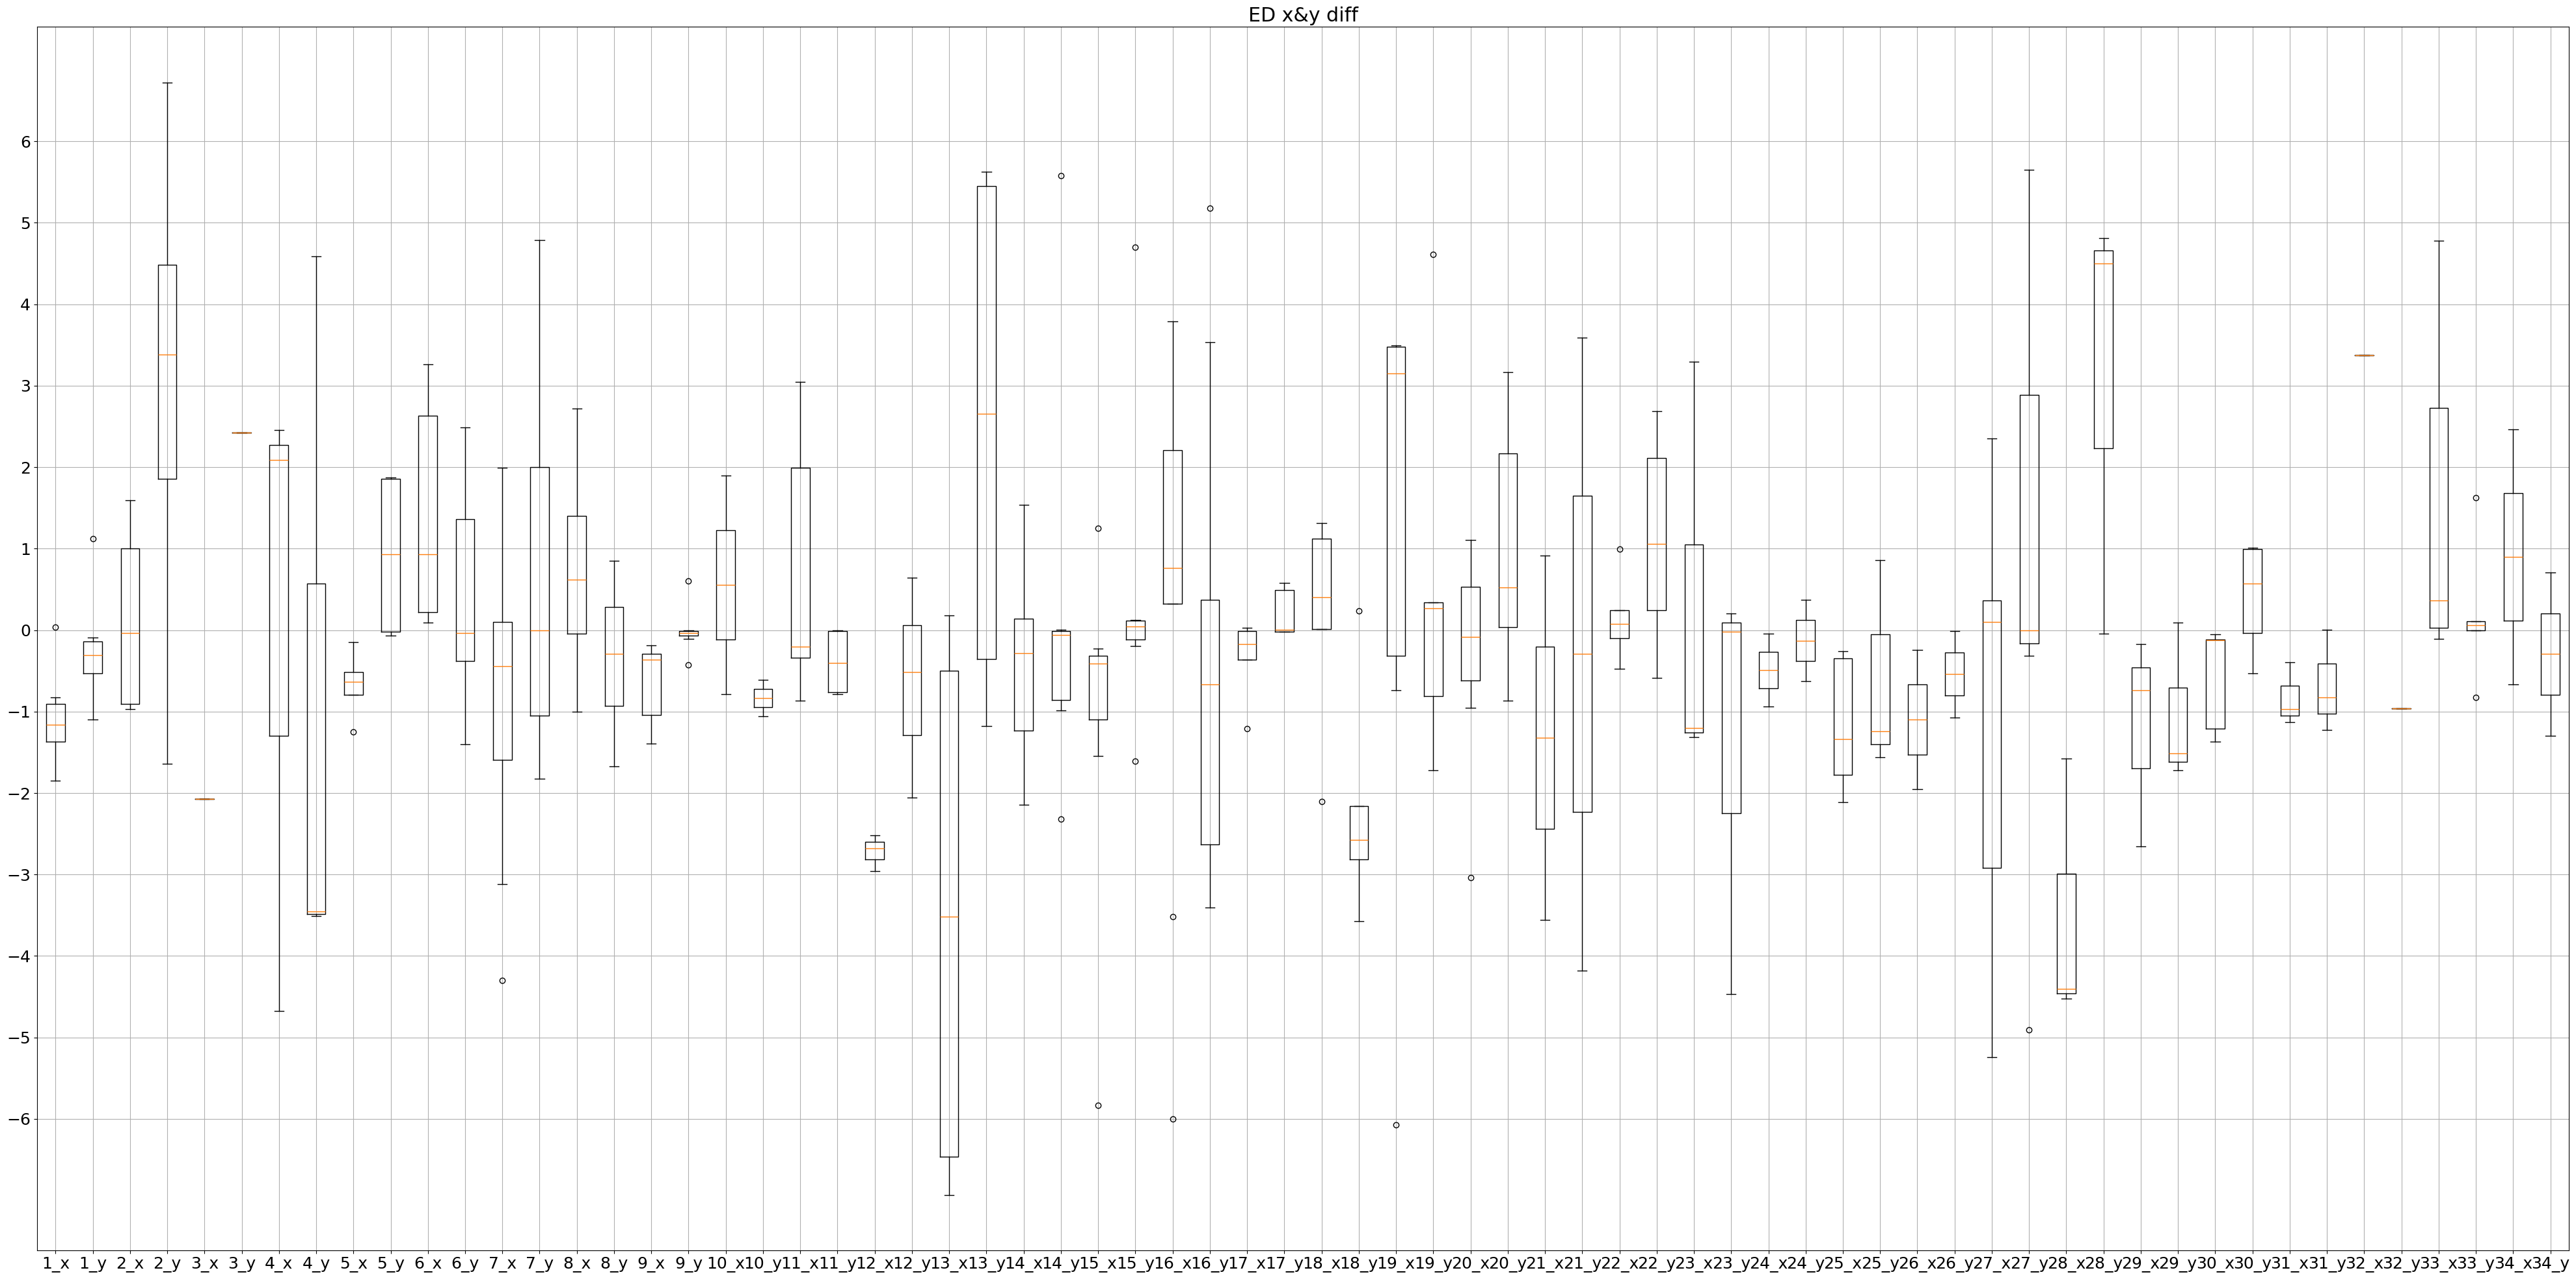

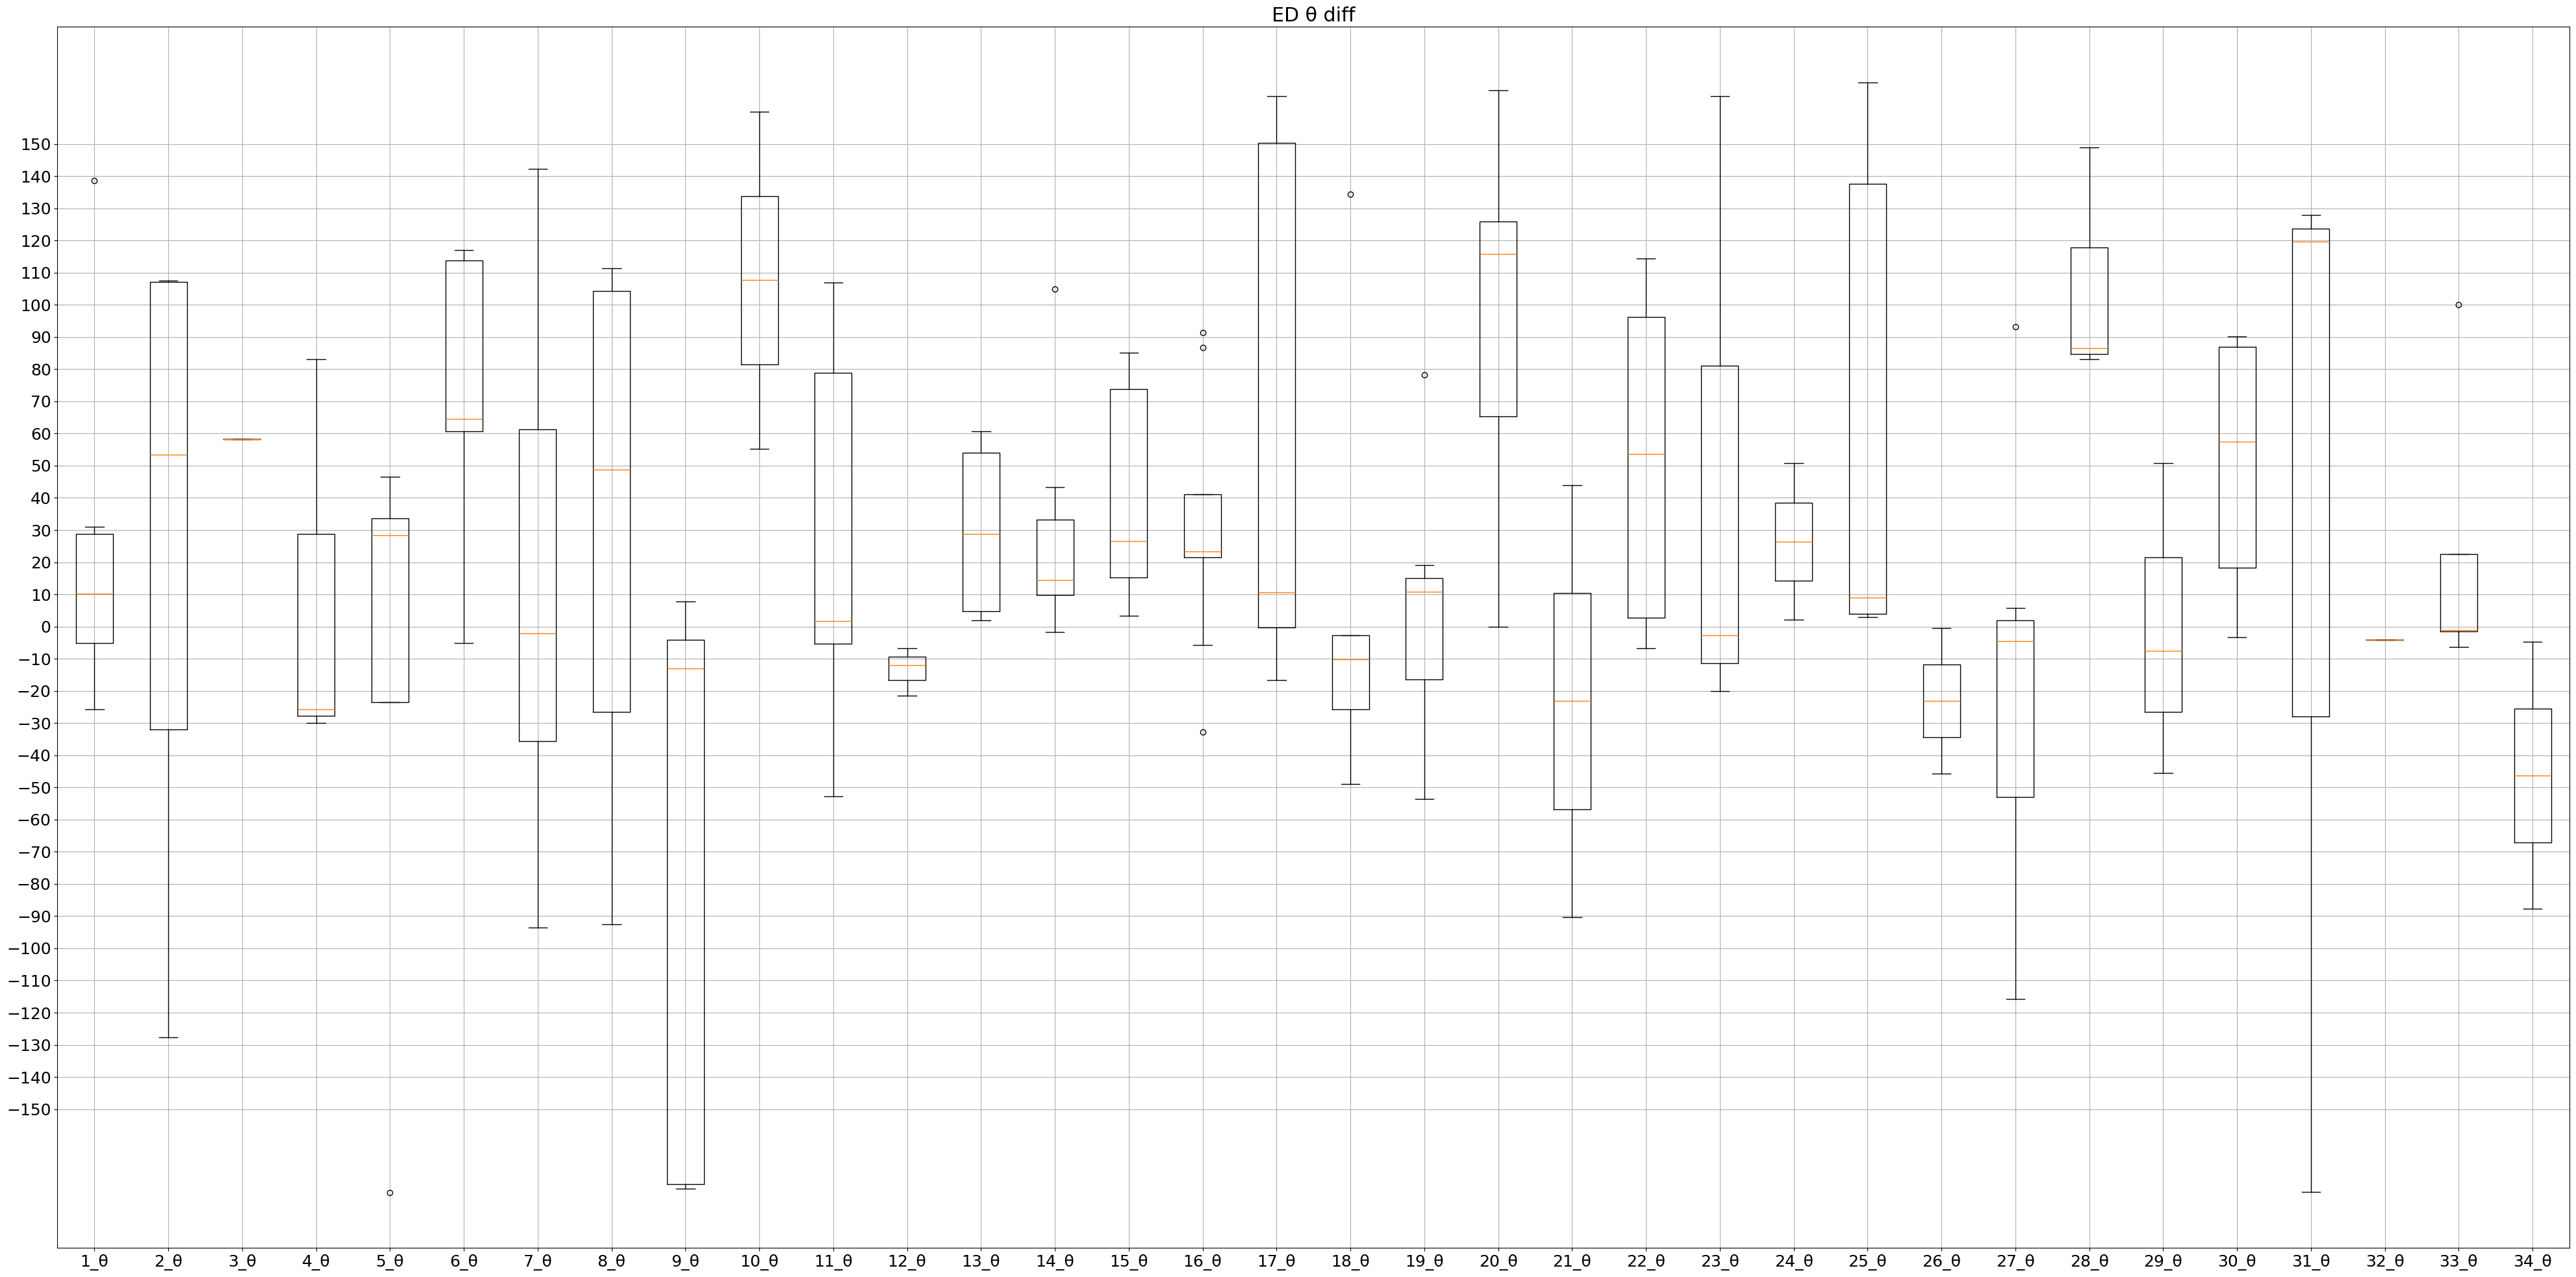

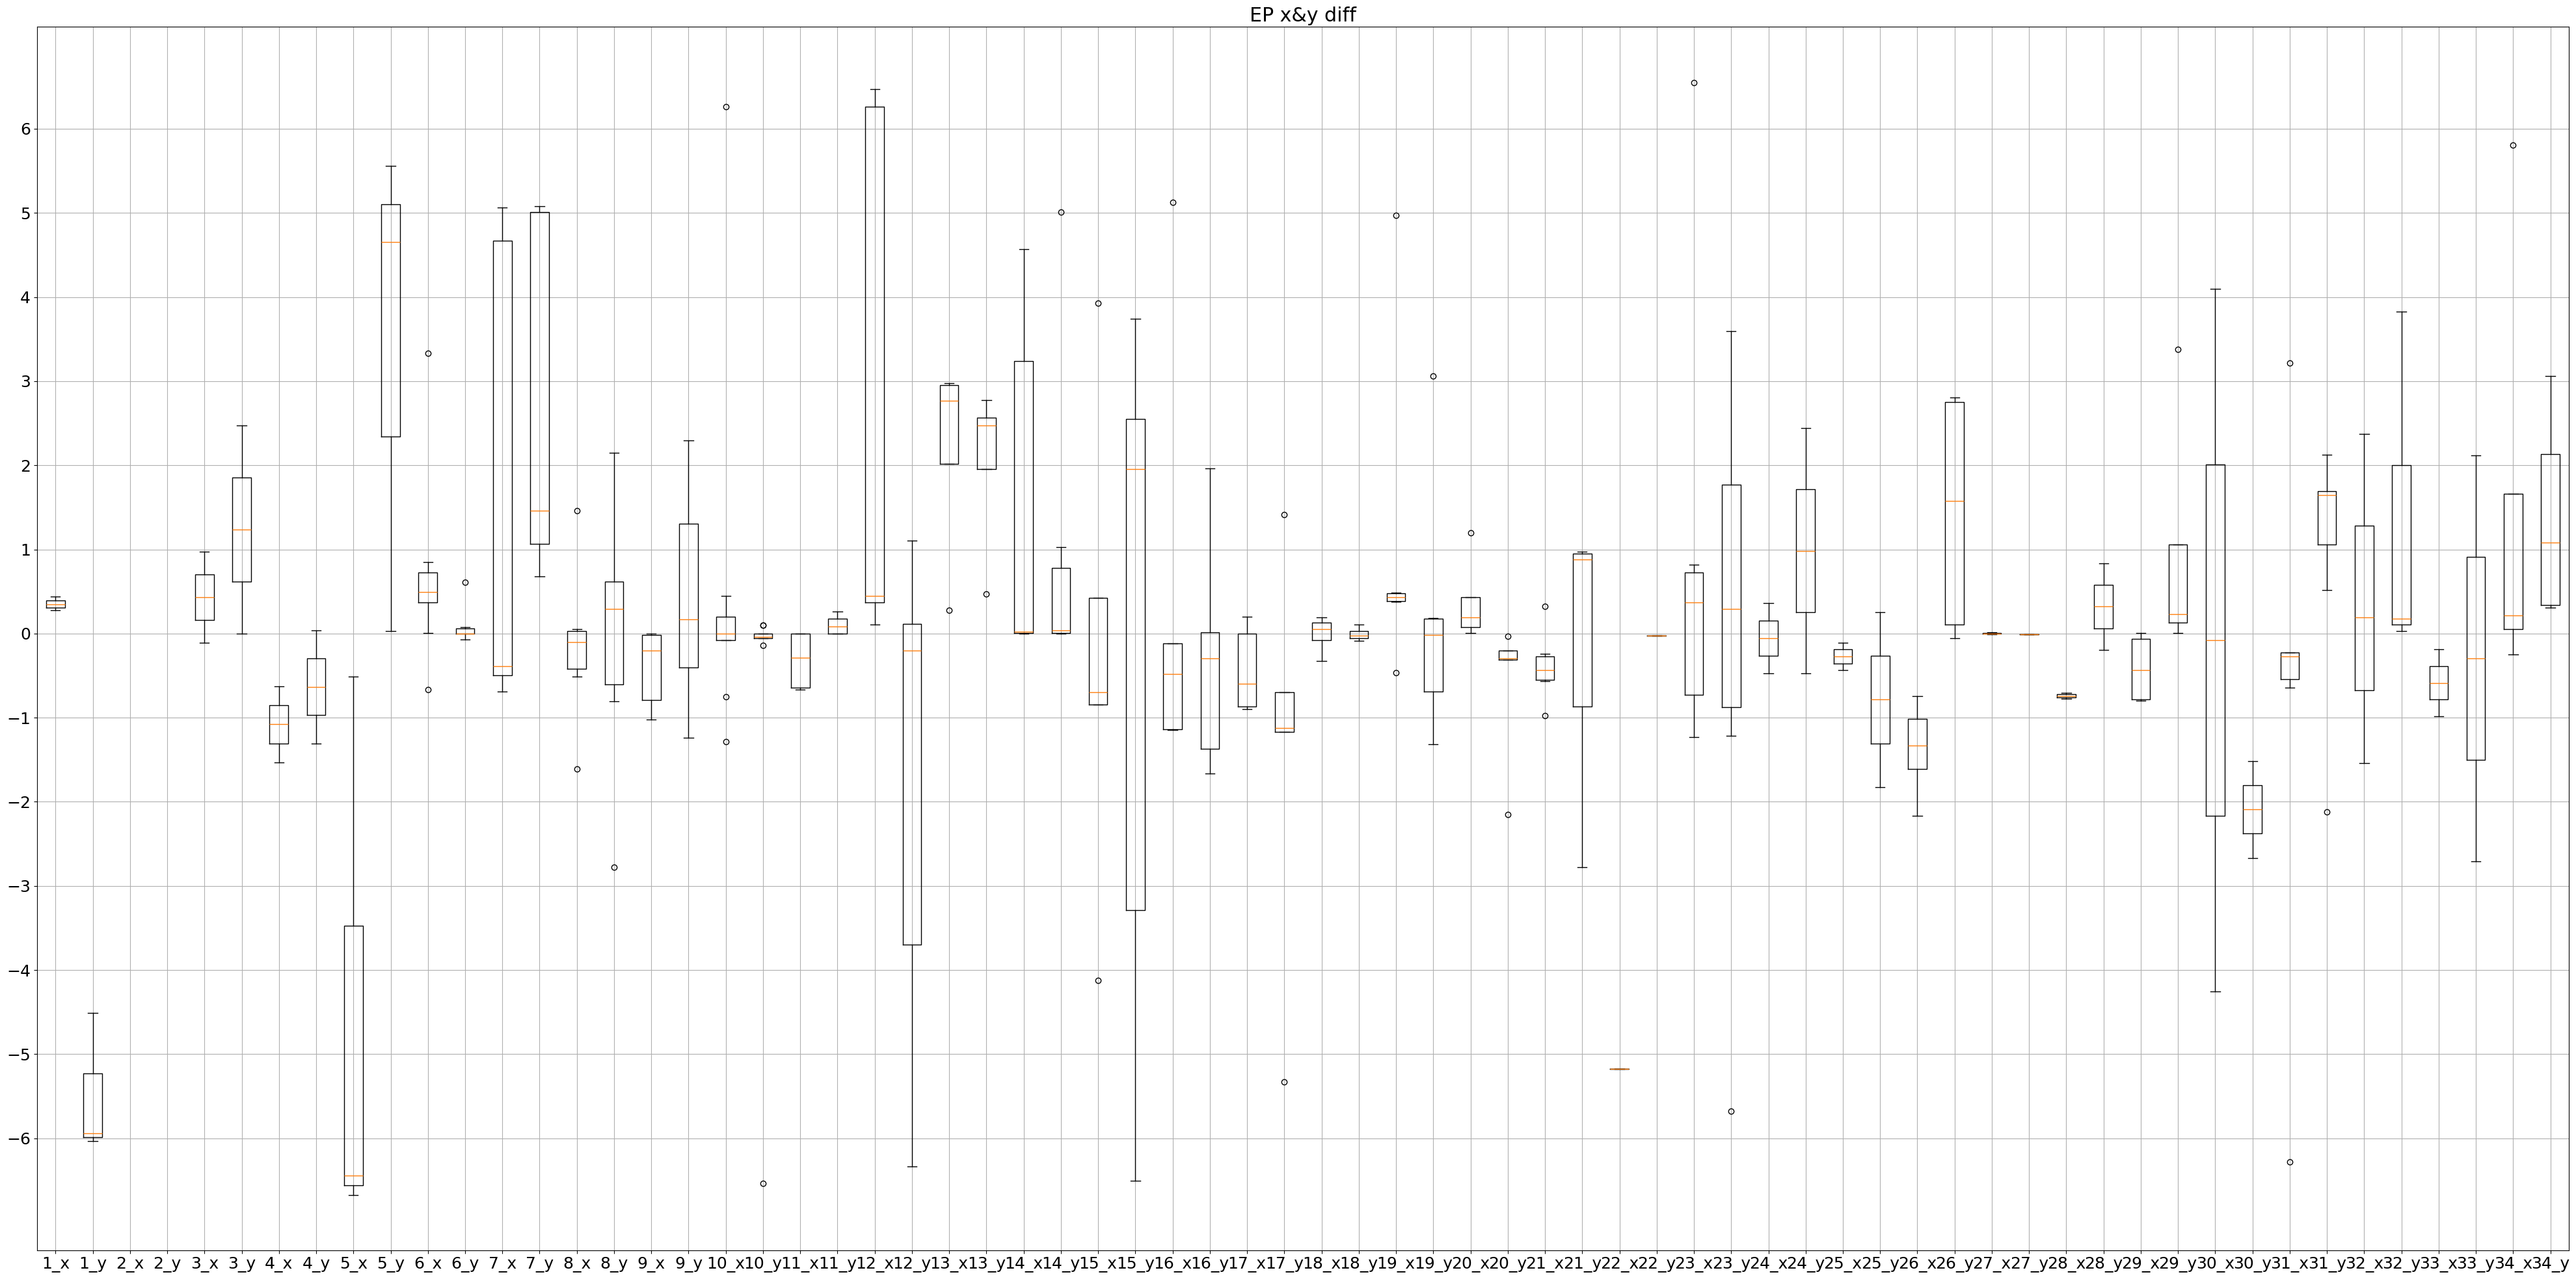

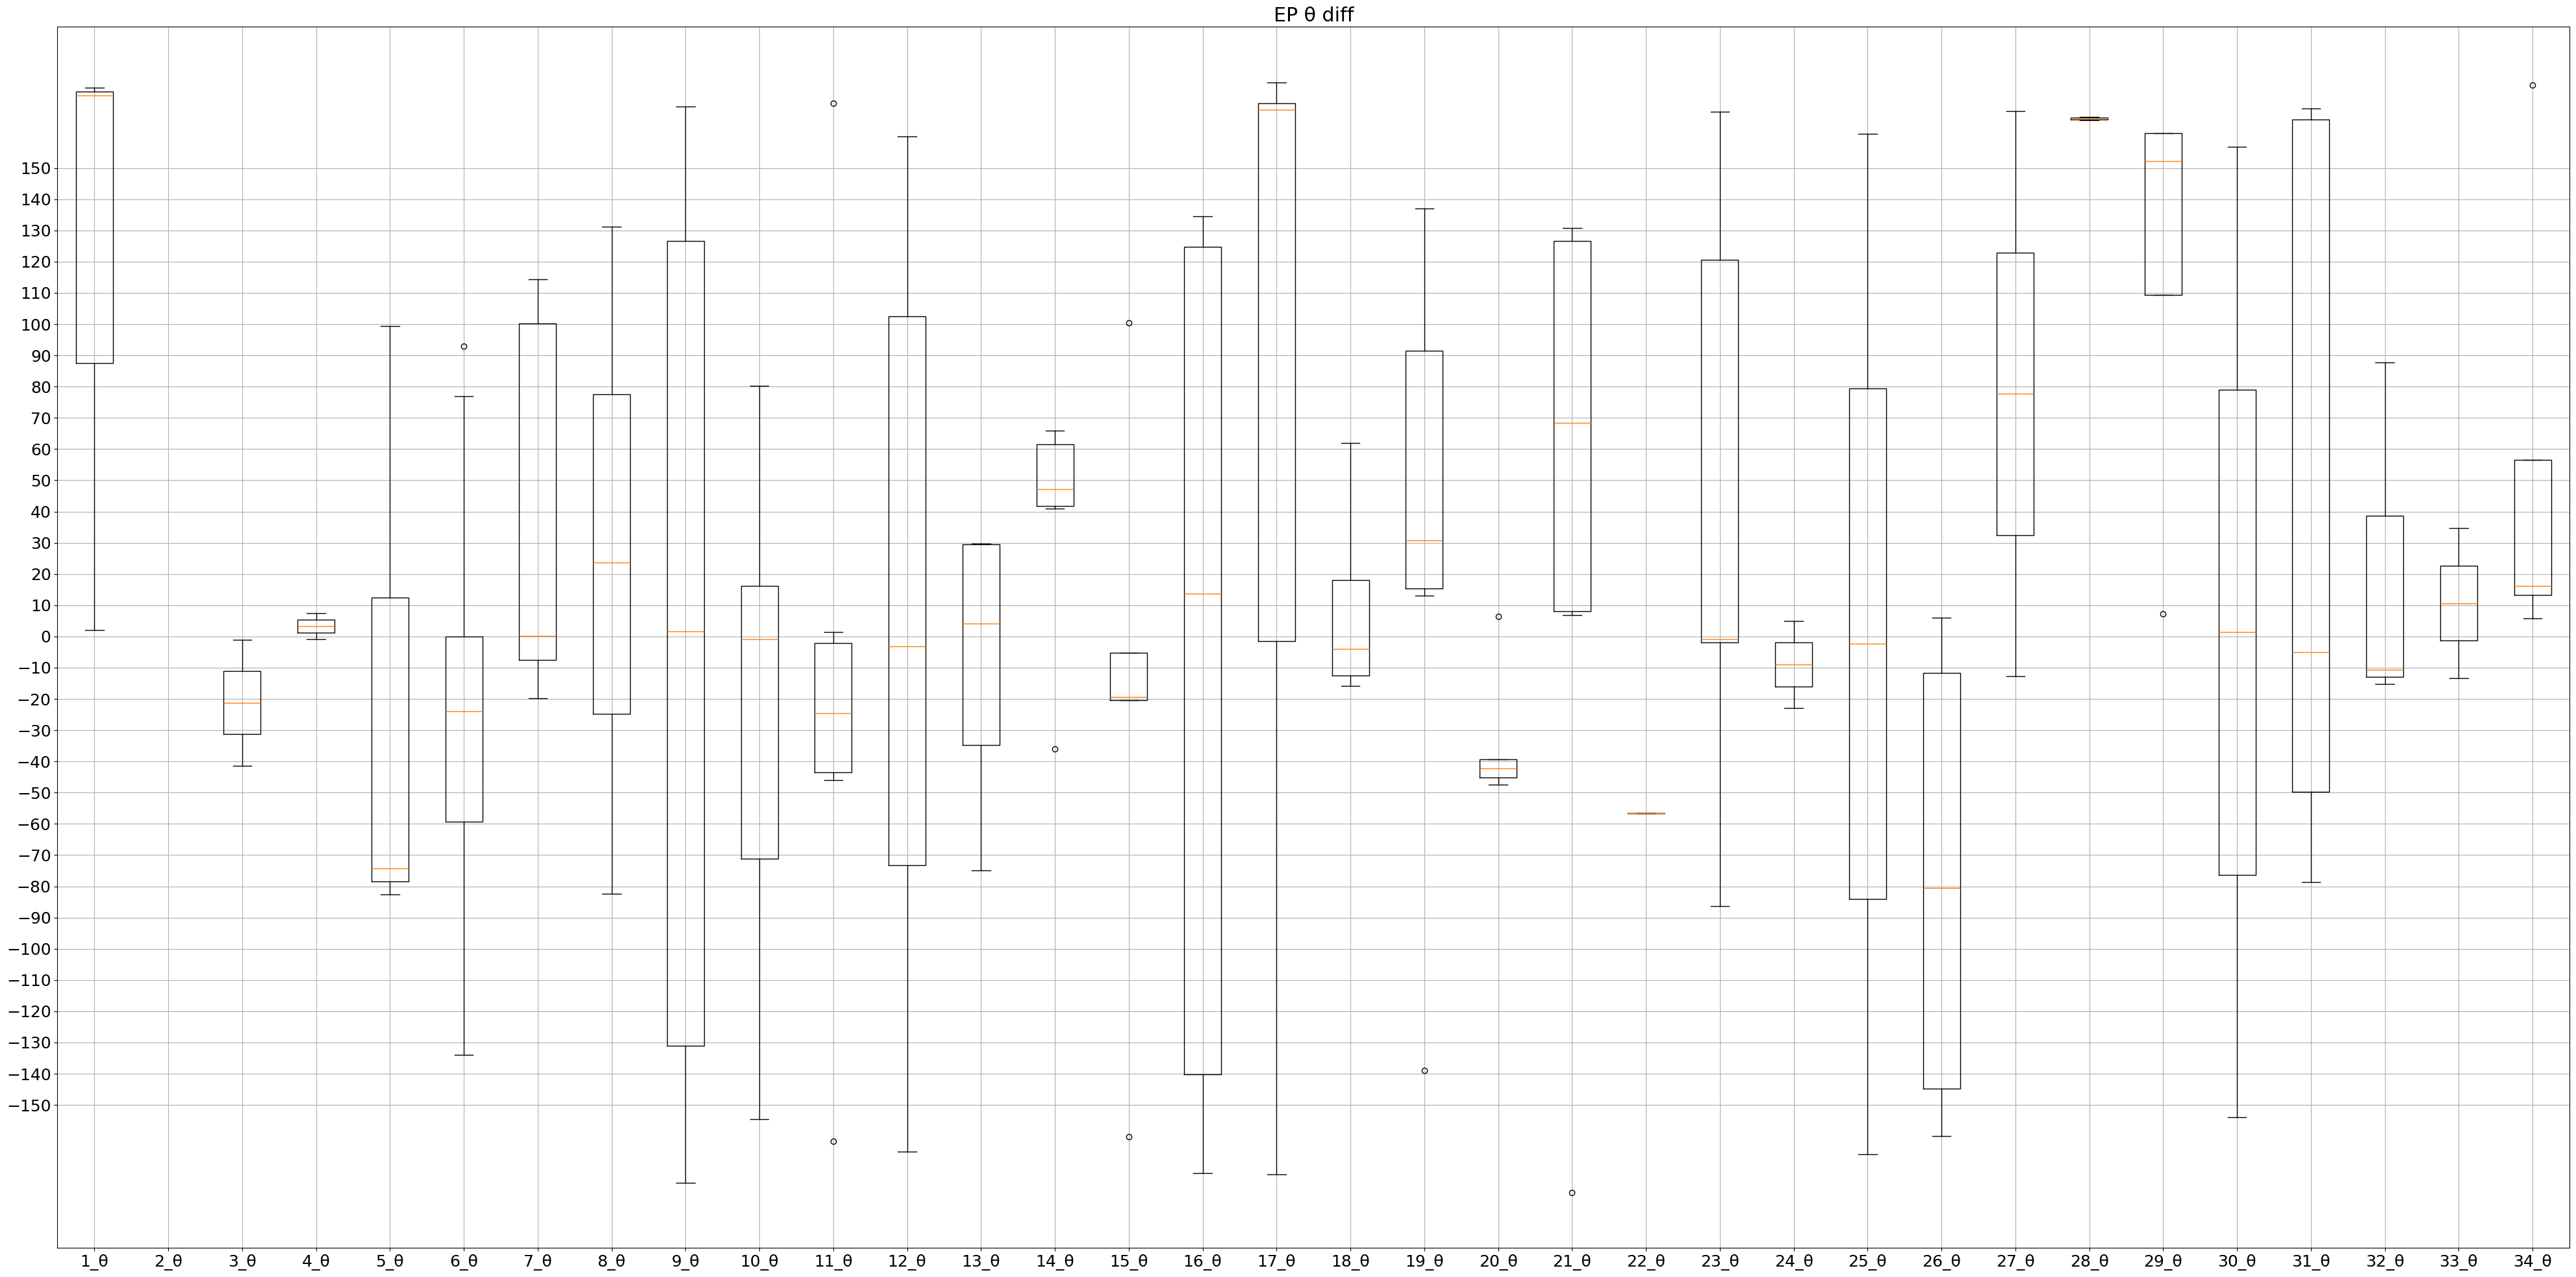

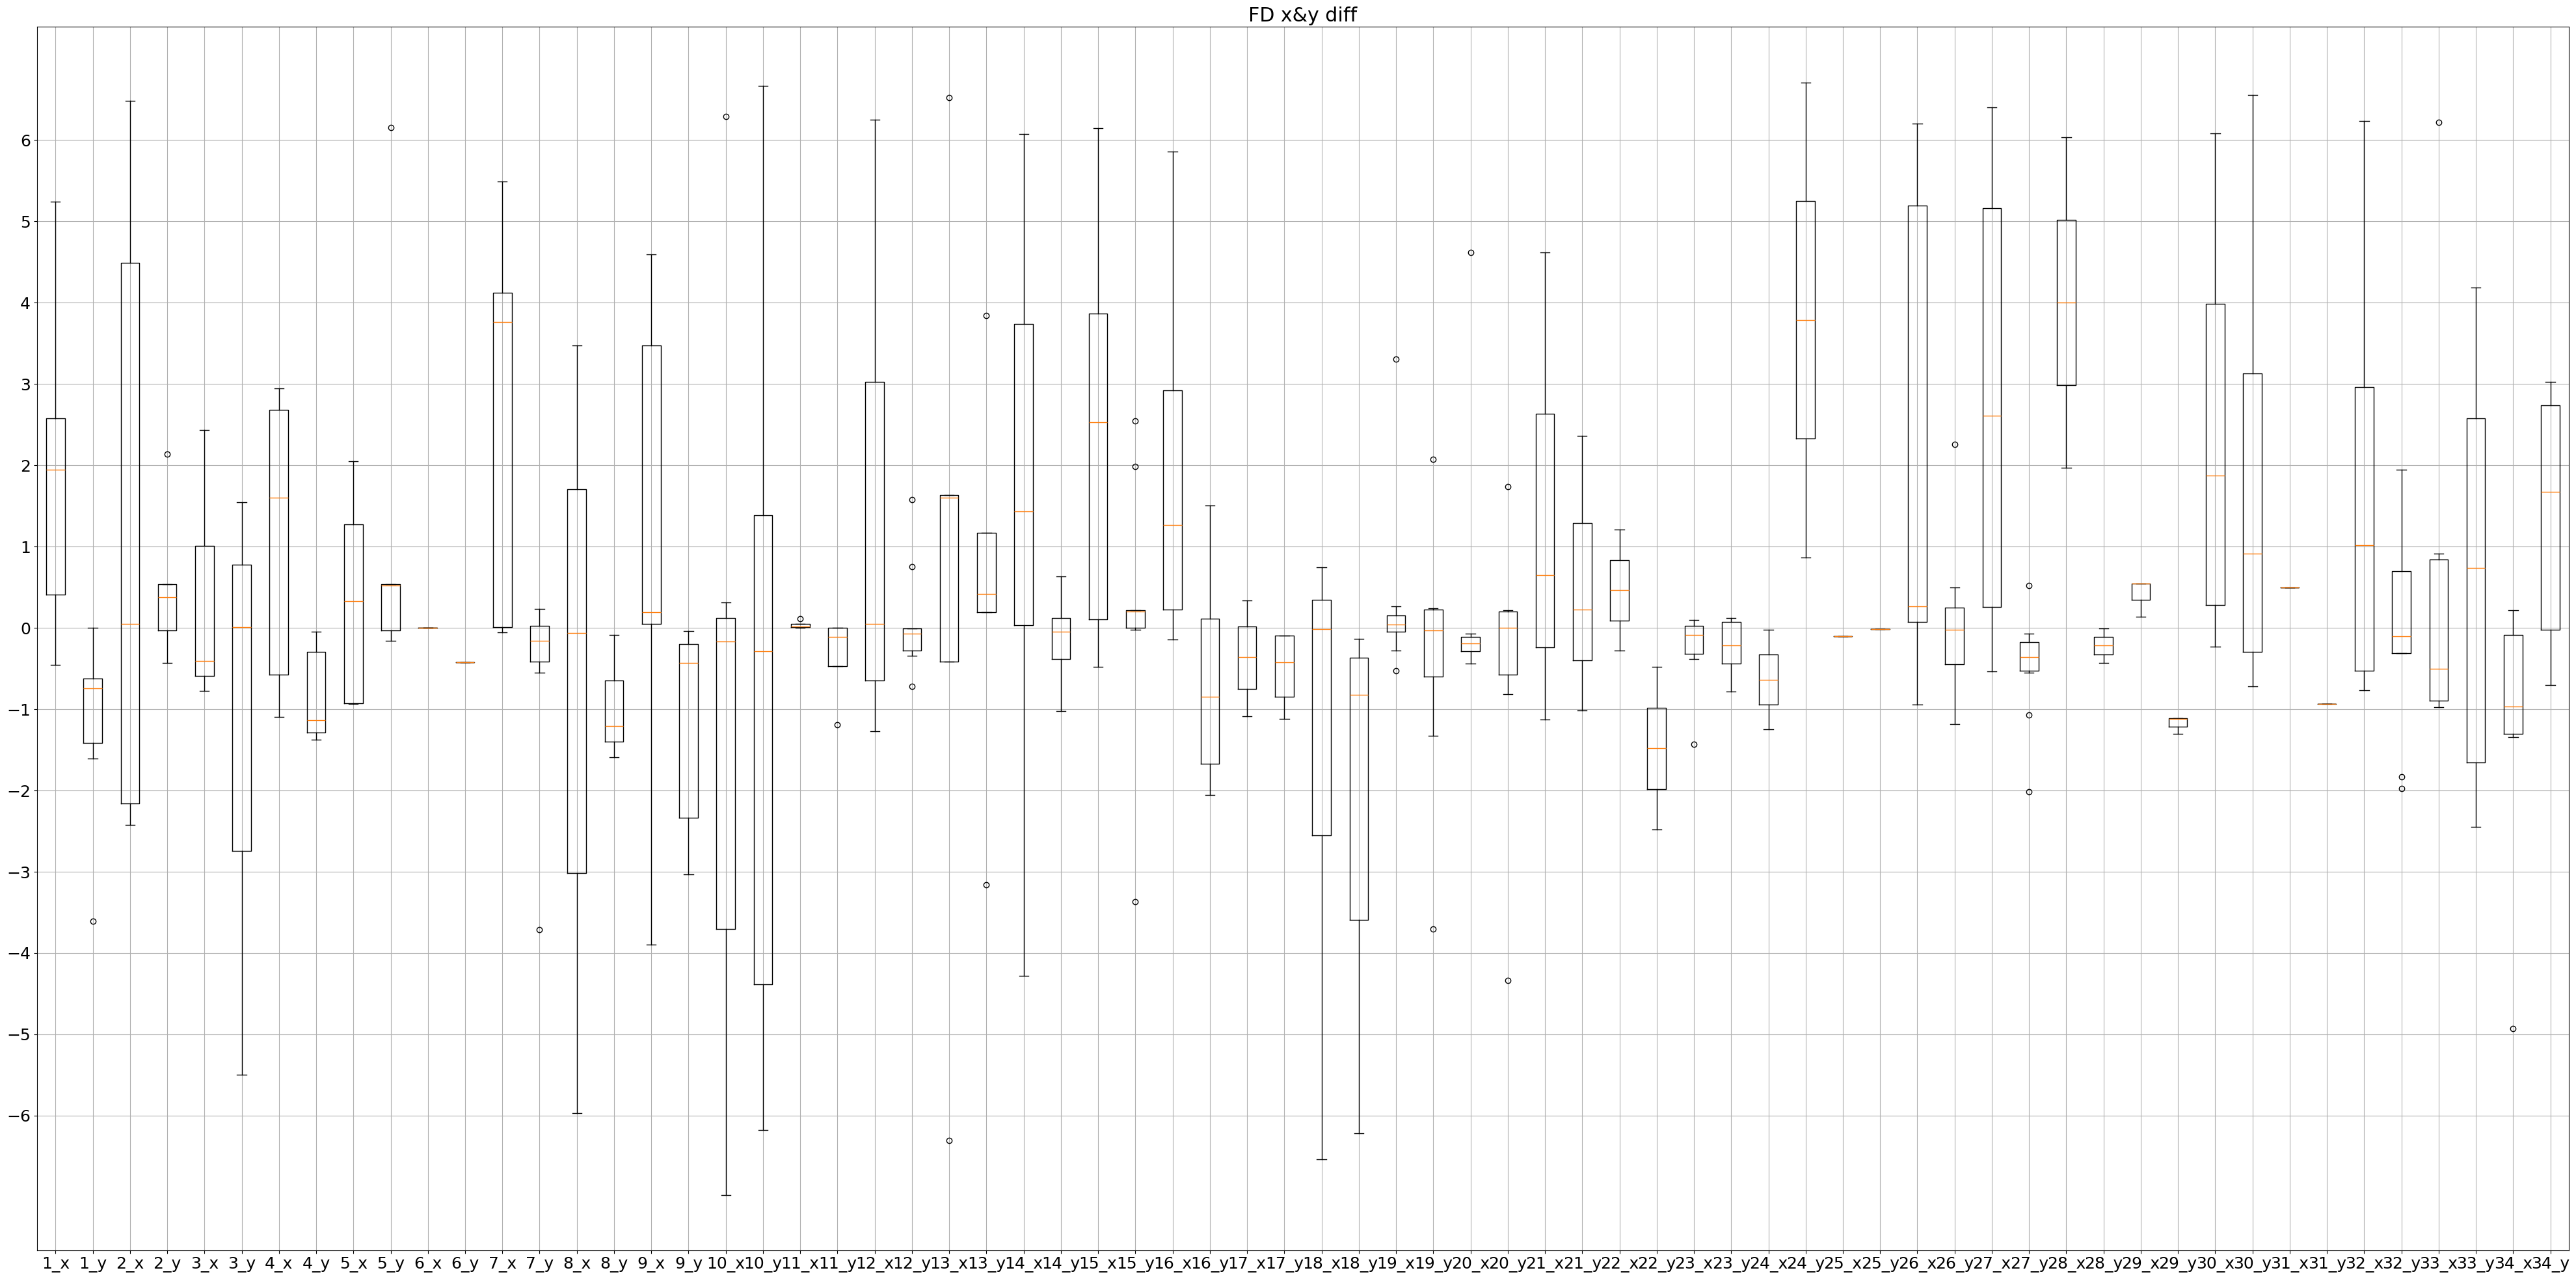

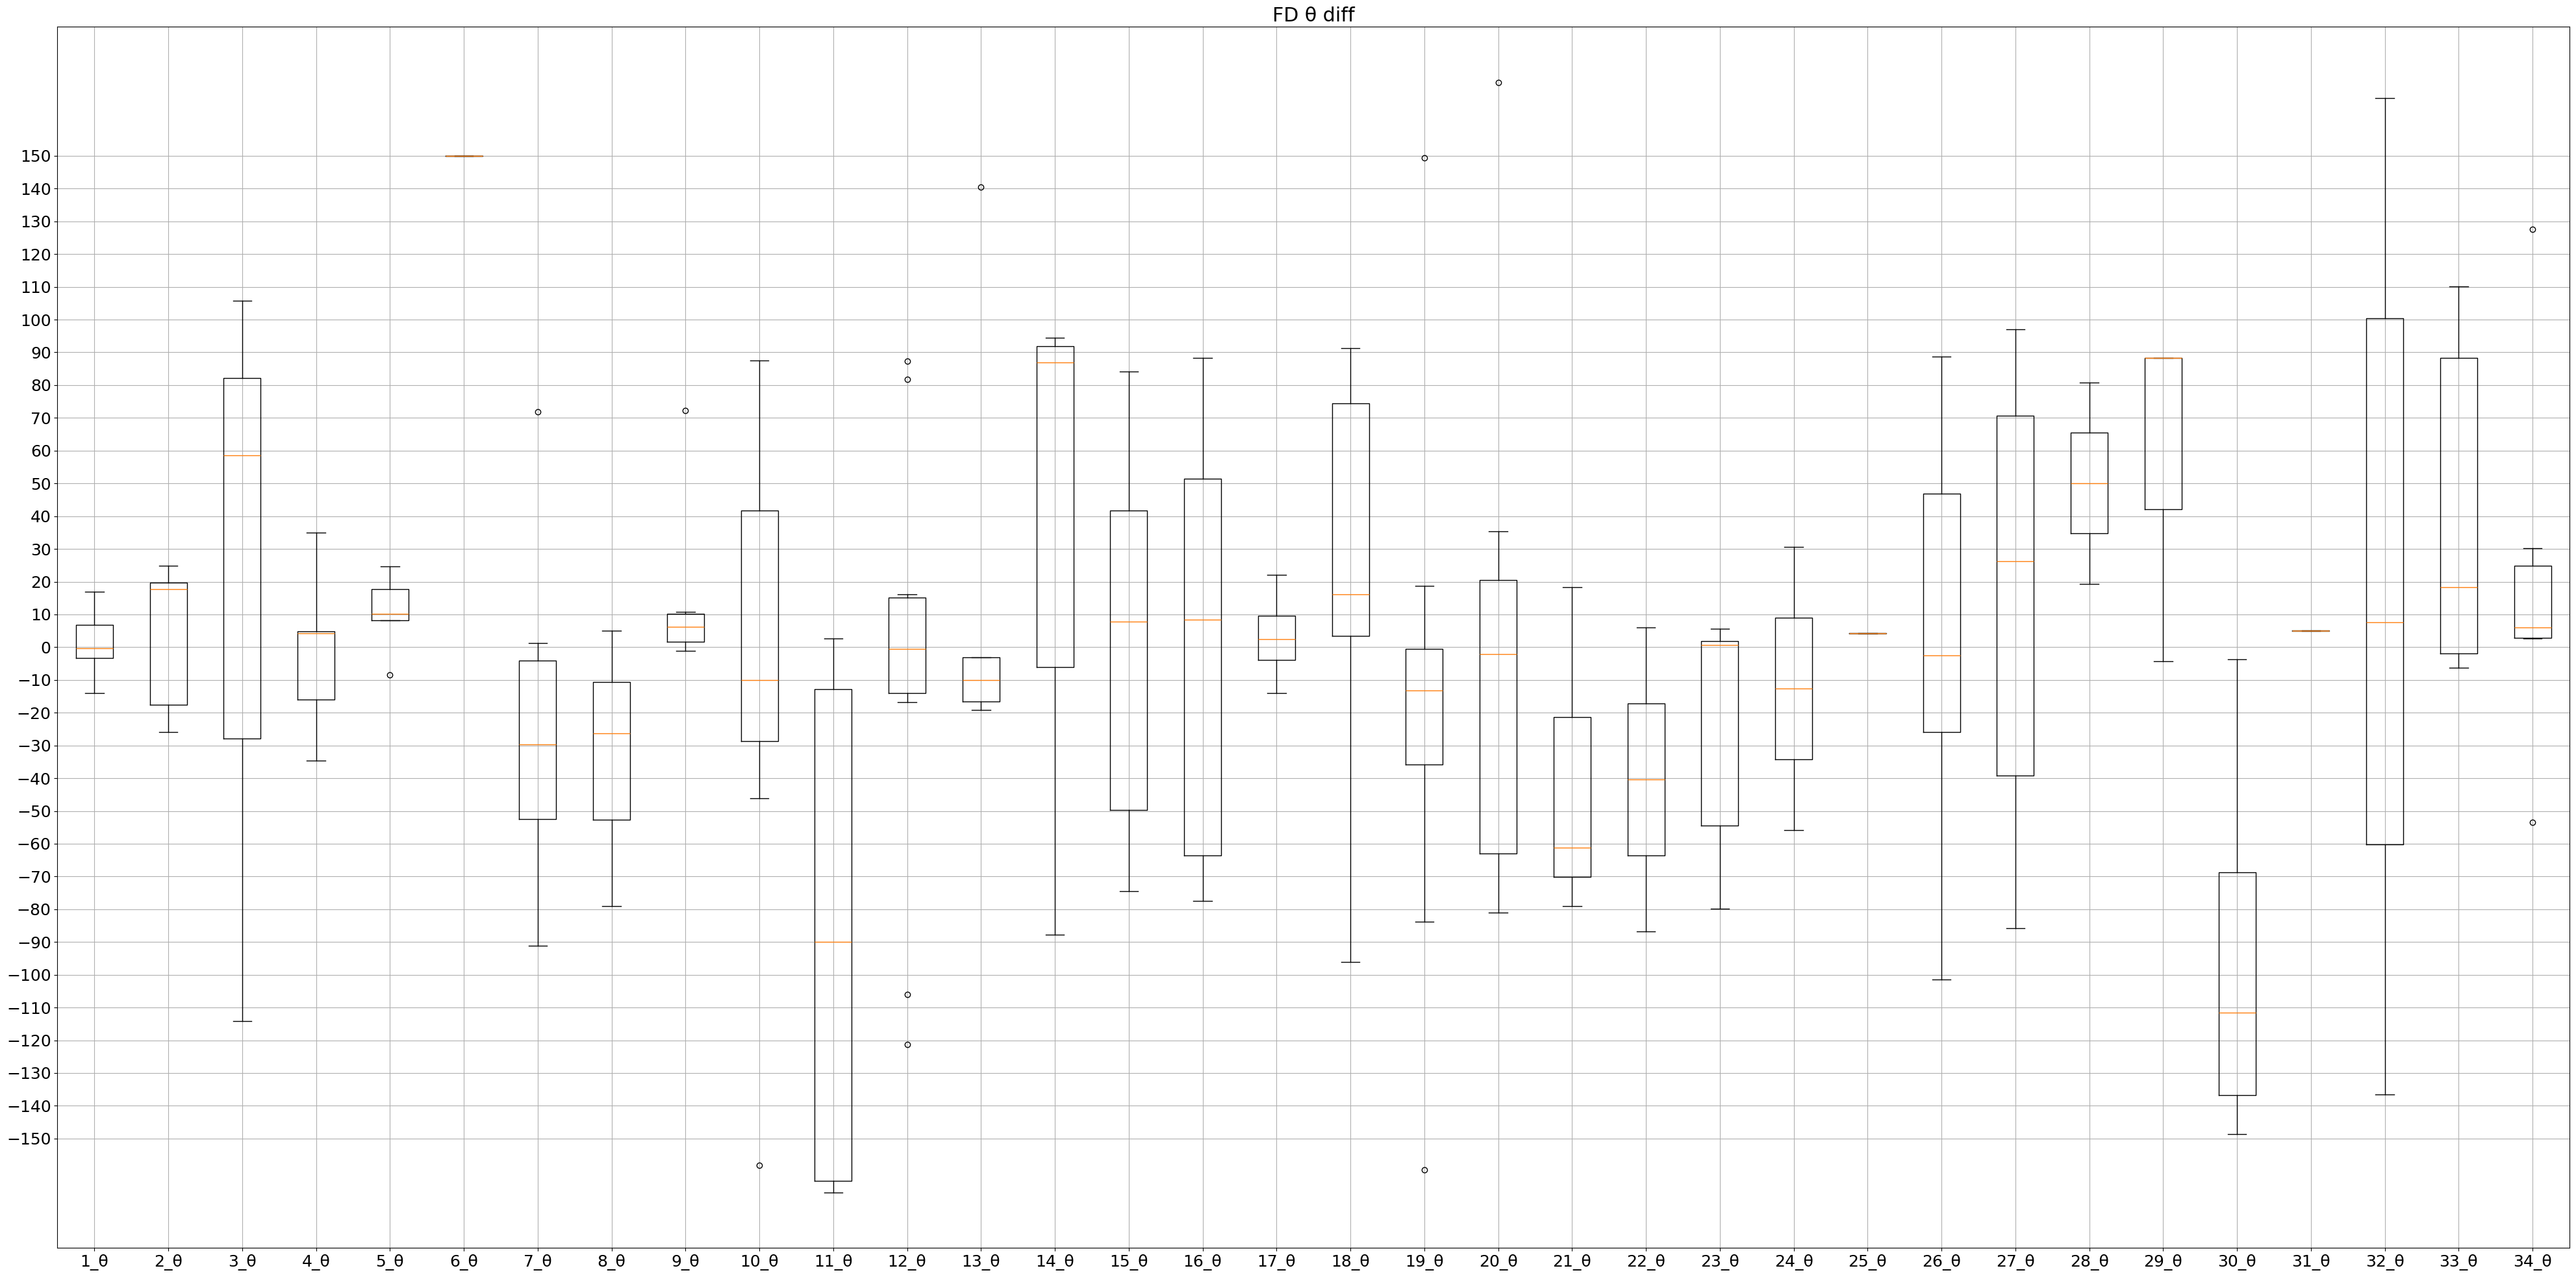

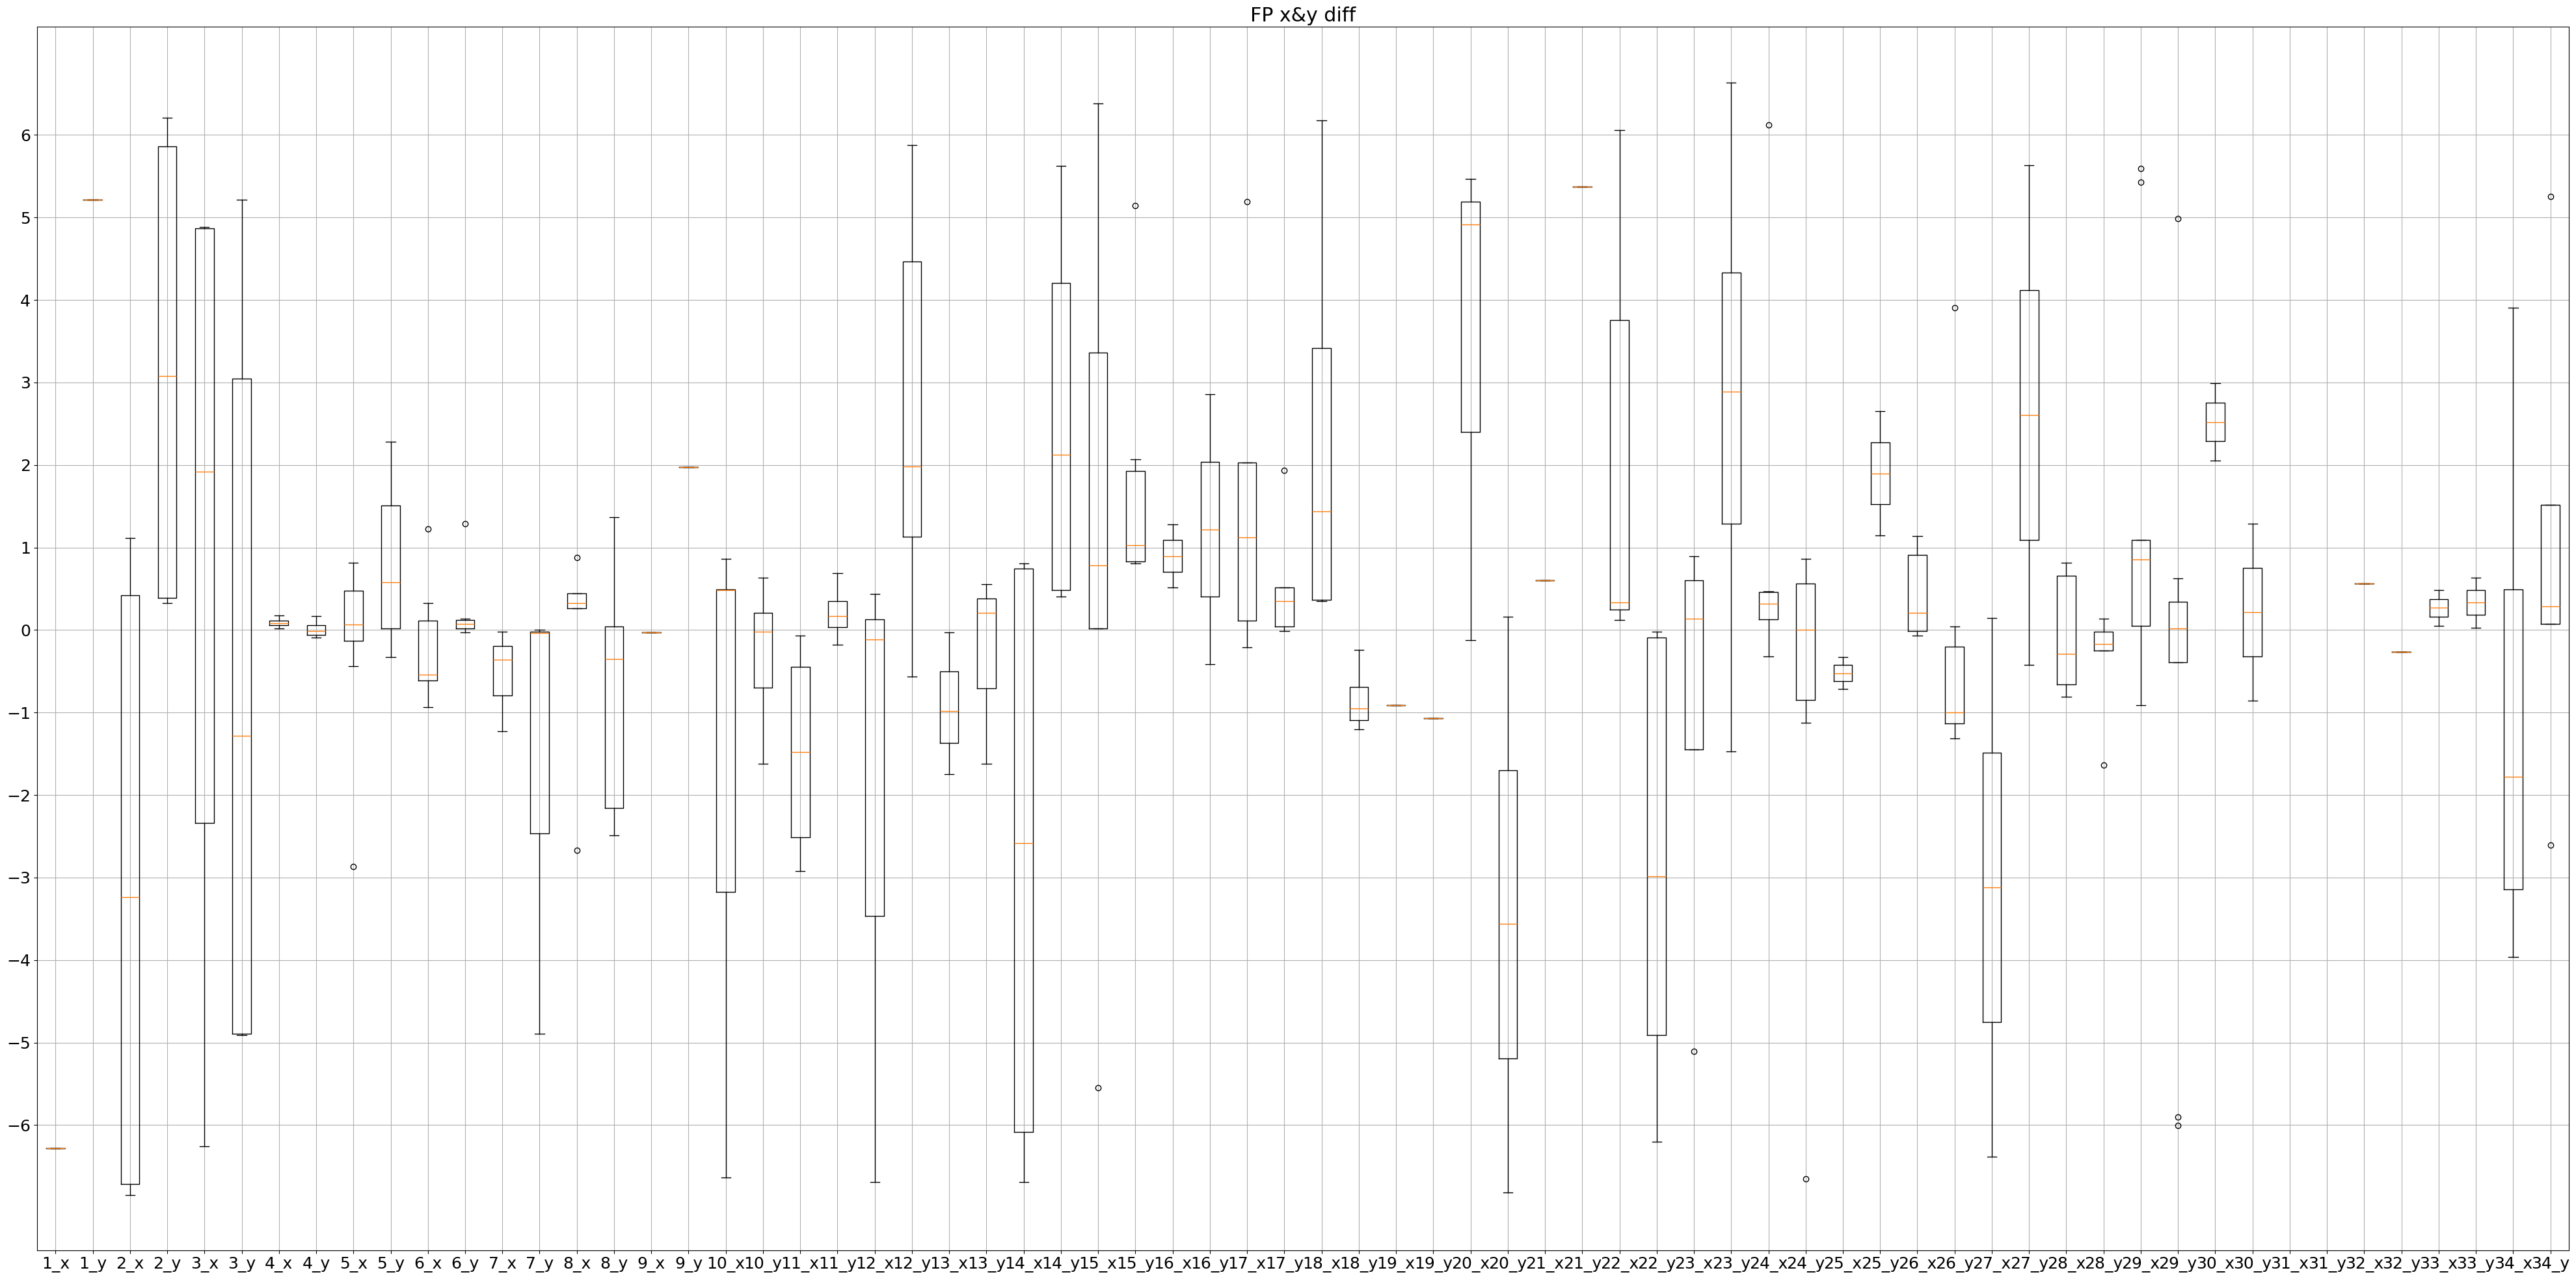

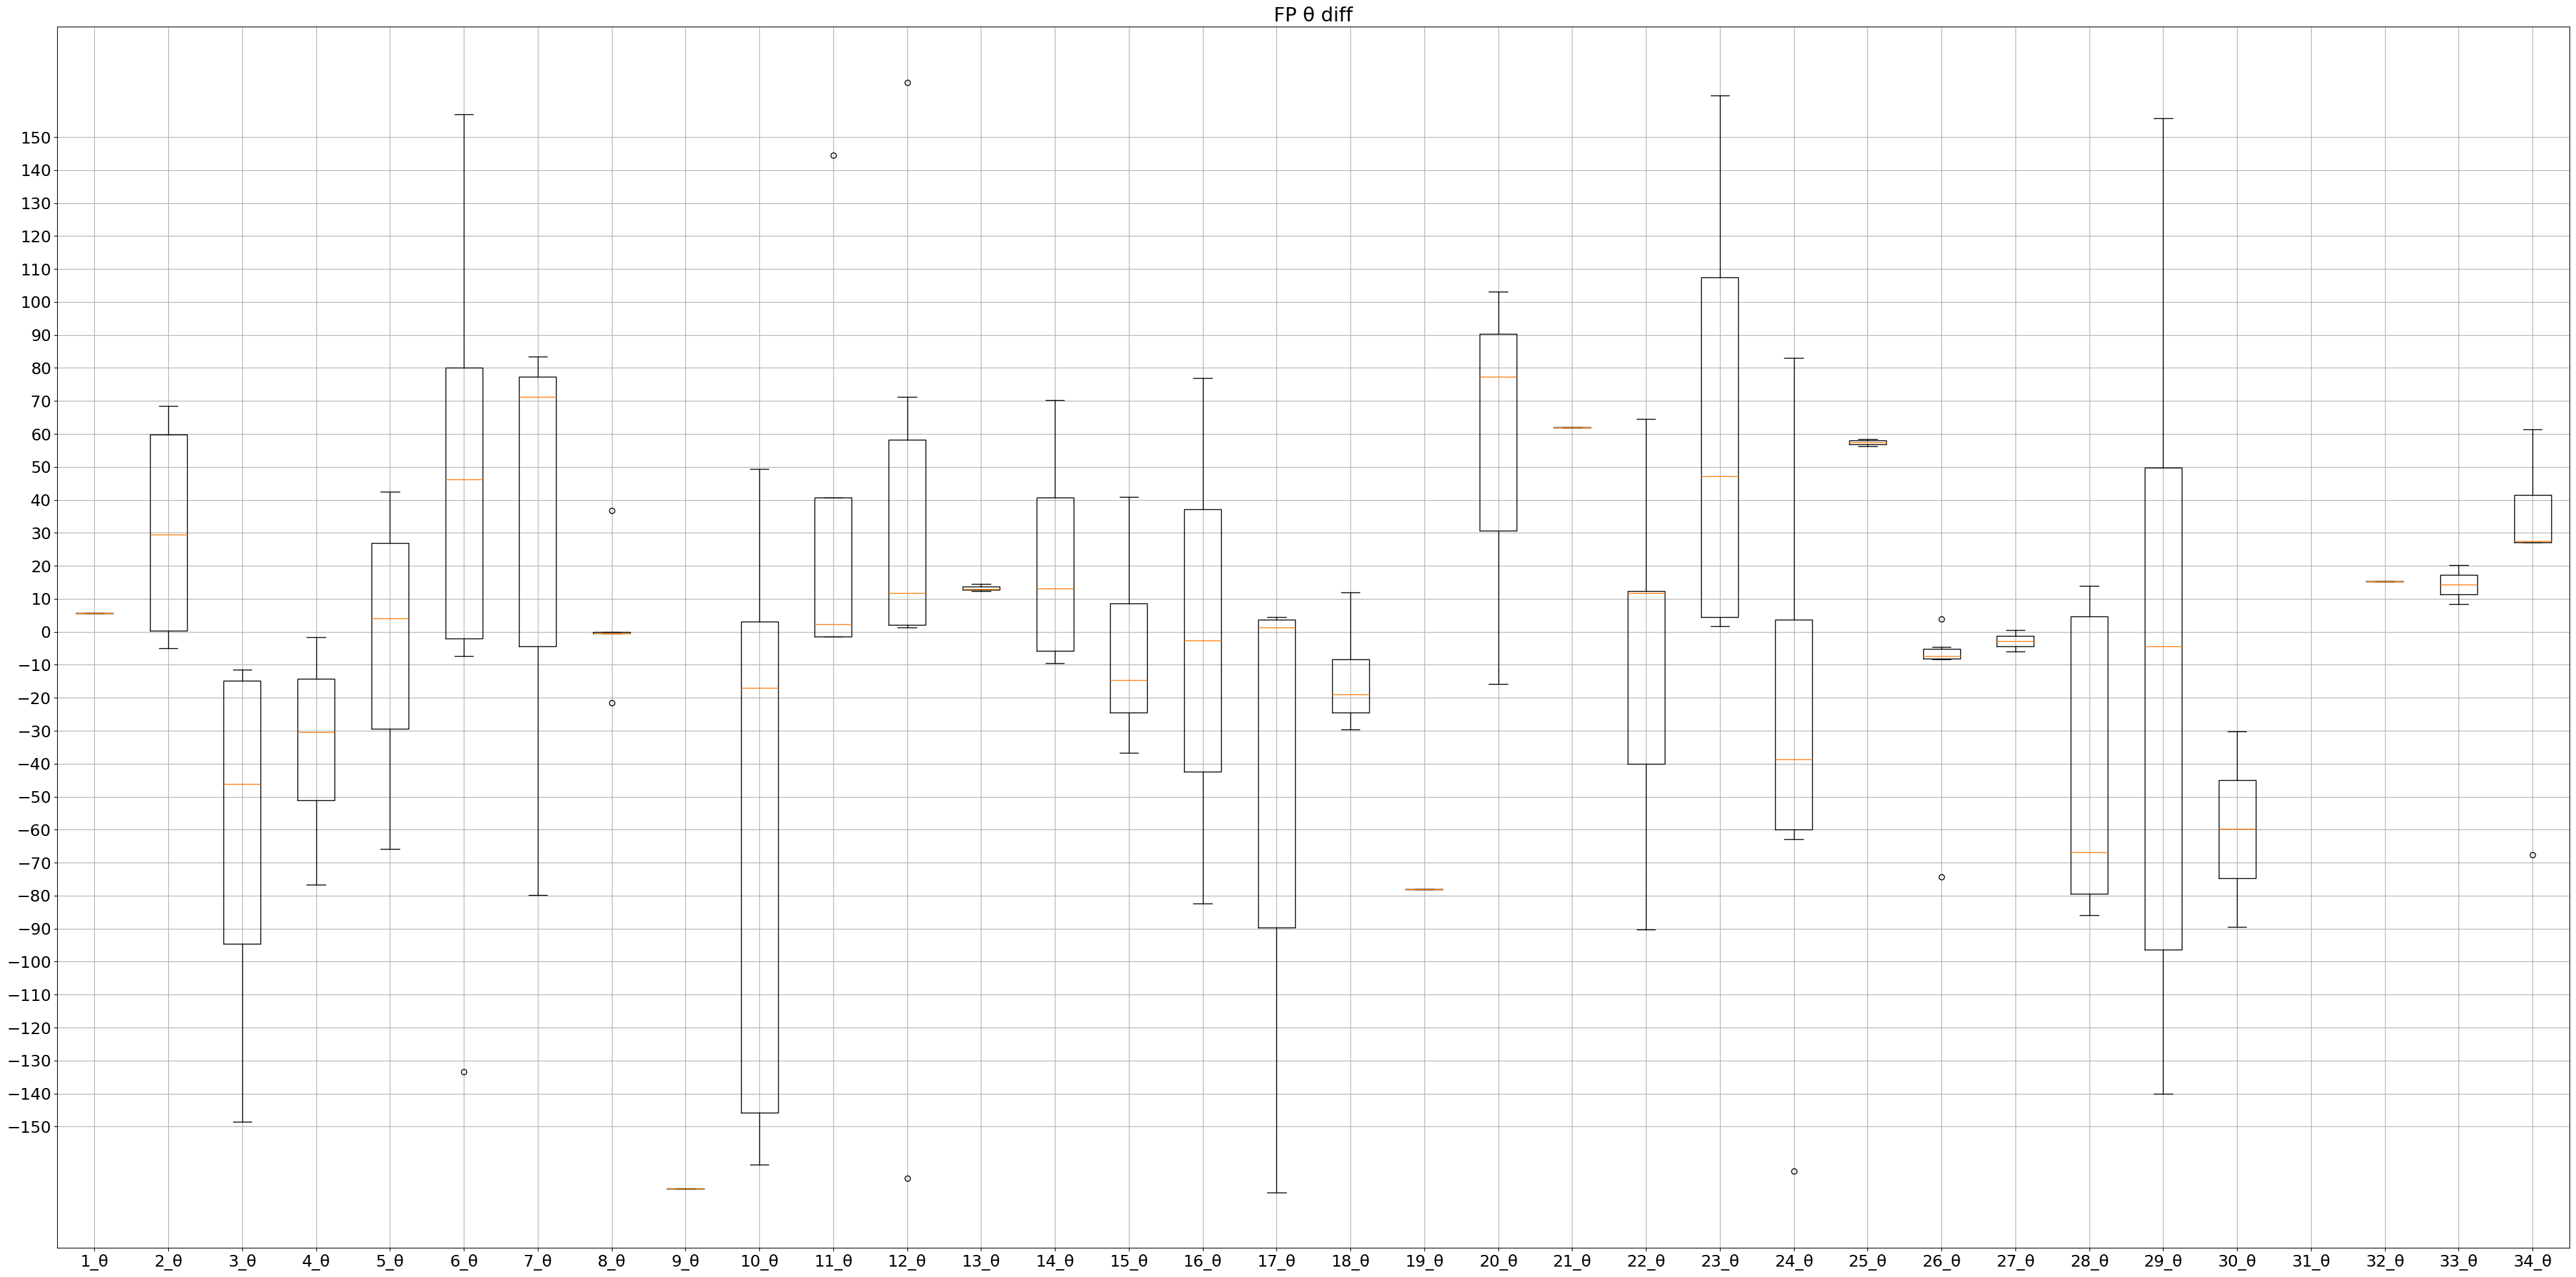

In [77]:
fig, ax = plt.subplots(figsize=(40,20), tight_layout=True)
ax.boxplot(ED_xy_list)
ax.set_xticklabels(['1_x','1_y','2_x','2_y','3_x','3_y','4_x','4_y','5_x','5_y','6_x','6_y','7_x','7_y','8_x','8_y','9_x','9_y','10_x','10_y','11_x','11_y','12_x','12_y','13_x','13_y','14_x','14_y','15_x','15_y','16_x','16_y','17_x','17_y','18_x','18_y','19_x','19_y','20_x','20_y','21_x','21_y','22_x','22_y','23_x','23_y','24_x','24_y','25_x','25_y','26_x','26_y','27_x','27_y','28_x','28_y','29_x','29_y','30_x','30_y','31_x','31_y','32_x','32_y','33_x','33_y','34_x','34_y'])
plt.title('ED x&y diff')
plt.rcParams['font.size'] = 18
plt.grid()
plt.yticks(range(-6, 7, 1))
plt.show()

fig, ax = plt.subplots(figsize=(40,20), tight_layout=True)
bp = ax.boxplot(ED_theta_list)
ax.set_xticklabels(['1_θ','2_θ','3_θ','4_θ','5_θ','6_θ','7_θ','8_θ','9_θ','10_θ','11_θ','12_θ','13_θ','14_θ','15_θ','16_θ','17_θ','18_θ','19_θ','20_θ','21_θ','22_θ','23_θ','24_θ','25_θ','26_θ','27_θ','28_θ','29_θ','30_θ','31_θ','32_θ','33_θ','34_θ'])
plt.title('ED θ diff')
plt.rcParams['font.size'] = 18
plt.grid()
plt.yticks(range(-150, 151, 10))
plt.show()

fig, ax = plt.subplots(figsize=(40,20), tight_layout=True)
bp = ax.boxplot(EP_xy_list)
ax.set_xticklabels(['1_x','1_y','2_x','2_y','3_x','3_y','4_x','4_y','5_x','5_y','6_x','6_y','7_x','7_y','8_x','8_y','9_x','9_y','10_x','10_y','11_x','11_y','12_x','12_y','13_x','13_y','14_x','14_y','15_x','15_y','16_x','16_y','17_x','17_y','18_x','18_y','19_x','19_y','20_x','20_y','21_x','21_y','22_x','22_y','23_x','23_y','24_x','24_y','25_x','25_y','26_x','26_y','27_x','27_y','28_x','28_y','29_x','29_y','30_x','30_y','31_x','31_y','32_x','32_y','33_x','33_y','34_x','34_y'])
plt.title('EP x&y diff')
plt.rcParams['font.size'] = 18
plt.grid()
plt.yticks(range(-6, 7, 1))
plt.show()

fig, ax = plt.subplots(figsize=(40,20), tight_layout=True)
bp = ax.boxplot(EP_theta_list)
ax.set_xticklabels(['1_θ','2_θ','3_θ','4_θ','5_θ','6_θ','7_θ','8_θ','9_θ','10_θ','11_θ','12_θ','13_θ','14_θ','15_θ','16_θ','17_θ','18_θ','19_θ','20_θ','21_θ','22_θ','23_θ','24_θ','25_θ','26_θ','27_θ','28_θ','29_θ','30_θ','31_θ','32_θ','33_θ','34_θ'])
plt.title('EP θ diff')
plt.rcParams['font.size'] = 18
plt.grid()
plt.yticks(range(-150, 151, 10))
plt.show()

fig, ax = plt.subplots(figsize=(40,20), tight_layout=True)
bp = ax.boxplot(FD_xy_list)
ax.set_xticklabels(['1_x','1_y','2_x','2_y','3_x','3_y','4_x','4_y','5_x','5_y','6_x','6_y','7_x','7_y','8_x','8_y','9_x','9_y','10_x','10_y','11_x','11_y','12_x','12_y','13_x','13_y','14_x','14_y','15_x','15_y','16_x','16_y','17_x','17_y','18_x','18_y','19_x','19_y','20_x','20_y','21_x','21_y','22_x','22_y','23_x','23_y','24_x','24_y','25_x','25_y','26_x','26_y','27_x','27_y','28_x','28_y','29_x','29_y','30_x','30_y','31_x','31_y','32_x','32_y','33_x','33_y','34_x','34_y'])
plt.title('FD x&y diff')
plt.rcParams['font.size'] = 18
plt.grid()
plt.yticks(range(-6, 7, 1))
plt.show()

fig, ax = plt.subplots(figsize=(40,20), tight_layout=True)
bp = ax.boxplot(FD_theta_list)
ax.set_xticklabels(['1_θ','2_θ','3_θ','4_θ','5_θ','6_θ','7_θ','8_θ','9_θ','10_θ','11_θ','12_θ','13_θ','14_θ','15_θ','16_θ','17_θ','18_θ','19_θ','20_θ','21_θ','22_θ','23_θ','24_θ','25_θ','26_θ','27_θ','28_θ','29_θ','30_θ','31_θ','32_θ','33_θ','34_θ'])
plt.title('FD θ diff')
plt.rcParams['font.size'] = 18
plt.grid()
plt.yticks(range(-150, 151, 10))
plt.show()

fig, ax = plt.subplots(figsize=(40,20), tight_layout=True)
bp = ax.boxplot(FP_xy_list)
ax.set_xticklabels(['1_x','1_y','2_x','2_y','3_x','3_y','4_x','4_y','5_x','5_y','6_x','6_y','7_x','7_y','8_x','8_y','9_x','9_y','10_x','10_y','11_x','11_y','12_x','12_y','13_x','13_y','14_x','14_y','15_x','15_y','16_x','16_y','17_x','17_y','18_x','18_y','19_x','19_y','20_x','20_y','21_x','21_y','22_x','22_y','23_x','23_y','24_x','24_y','25_x','25_y','26_x','26_y','27_x','27_y','28_x','28_y','29_x','29_y','30_x','30_y','31_x','31_y','32_x','32_y','33_x','33_y','34_x','34_y'])
plt.title('FP x&y diff')
plt.rcParams['font.size'] = 18
plt.grid()
plt.yticks(range(-6, 7, 1))
plt.show()

fig, ax = plt.subplots(figsize=(40,20), tight_layout=True)
bp = ax.boxplot(FP_theta_list)
ax.set_xticklabels(['1_θ','2_θ','3_θ','4_θ','5_θ','6_θ','7_θ','8_θ','9_θ','10_θ','11_θ','12_θ','13_θ','14_θ','15_θ','16_θ','17_θ','18_θ','19_θ','20_θ','21_θ','22_θ','23_θ','24_θ','25_θ','26_θ','27_θ','28_θ','29_θ','30_θ','31_θ','32_θ','33_θ','34_θ'])
plt.title('FP θ diff')
plt.rcParams['font.size'] = 18
plt.grid()
plt.yticks(range(-150, 151, 10))
plt.show()

# テスト

In [66]:
x_ED_gesture = {}
y_ED_gesture = {}
theta_ED_gesture = {}
x_EP_gesture = {}
y_EP_gesture = {}
theta_EP_gesture = {}
x_FD_gesture = {}
y_FD_gesture = {}
theta_FD_gesture = {}
x_FP_gesture = {}
y_FP_gesture = {}
theta_FP_gesture = {}
n_gestures = 34
for i in range(n_gestures):
    x_ED_gesture[i+1] = []
    y_ED_gesture[i+1] = []
    theta_ED_gesture[i+1] = []
    x_EP_gesture[i+1] = []
    y_EP_gesture[i+1] = []
    theta_EP_gesture[i+1] = []
    x_FD_gesture[i+1] = []
    y_FD_gesture[i+1] = []
    theta_FD_gesture[i+1] = []
    x_FP_gesture[i+1] = []
    y_FP_gesture[i+1] = []
    theta_FP_gesture[i+1] = []

In [67]:
for diff_list in distances:
    print(diff_list)
    if diff_list['result_distance'] != [None]:
        gesture = diff_list['gesture']
        electrode_place = diff_list['electrode_place']
        if electrode_place == 'ED':
            for diff in diff_list['result_distance']:
                x_ED_gesture[gesture].append(diff['x_distance'])
                y_ED_gesture[gesture].append(diff['y_distance'])
                theta_ED_gesture[gesture].append(diff['theta_distance'])
        elif electrode_place == 'EP':
            for diff in diff_list['result_distance']:
                x_EP_gesture[gesture].append(diff['x_distance'])
                y_EP_gesture[gesture].append(diff['y_distance'])
                theta_EP_gesture[gesture].append(diff['theta_distance'])
        elif electrode_place == 'FD':
            for diff in diff_list['result_distance']:
                x_FD_gesture[gesture].append(diff['x_distance'])
                y_FD_gesture[gesture].append(diff['y_distance'])
                theta_FD_gesture[gesture].append(diff['theta_distance'])
        elif electrode_place == 'FP':
            for diff in diff_list['result_distance']:
                x_FP_gesture[gesture].append(diff['x_distance'])
                y_FP_gesture[gesture].append(diff['y_distance'])
                theta_FP_gesture[gesture].append(diff['theta_distance'])

{'subject': 1, 'gesture': 1, 'trial': 1, 'electrode_place': 'ED', 'result_distance': [{'session1_cluster': 0, 'session2_cluster': 20, 'x_distance': 0.6355043368060231, 'y_distance': 0.2968244295037339, 'theta_distance': 126.80880311567324}, {'session1_cluster': 1, 'session2_cluster': 20, 'x_distance': 0.8046718794426484, 'y_distance': 0.20238527097442738, 'theta_distance': 6.995579169369314}, {'session1_cluster': 2, 'session2_cluster': 20, 'x_distance': 0.34048013321548076, 'y_distance': 0.3659353932278293, 'theta_distance': -18.365583335385004}, {'session1_cluster': 30, 'session2_cluster': 10, 'x_distance': -0.02485568984674824, 'y_distance': -0.05747863767190342, 'theta_distance': 9.093665741959128}]}
{'subject': 1, 'gesture': 1, 'trial': 1, 'electrode_place': 'EP', 'result_distance': [{'session1_cluster': 20, 'session2_cluster': 31, 'x_distance': 1.3986981499463313, 'y_distance': -3.0642257542032985, 'theta_distance': -72.11244356834571}, {'session1_cluster': 30, 'session2_cluster':

In [68]:
ED_xy_list = []
EP_xy_list = []
FD_xy_list = []
FP_xy_list = []
for i in range(n_gestures):
    ED_xy_list.append(x_ED_gesture[i+1])
    ED_xy_list.append(y_ED_gesture[i+1])
    # ED_list.append(theta_ED_gesture[i+1])
for i in range(n_gestures):
    EP_xy_list.append(x_EP_gesture[i+1])
    EP_xy_list.append(y_EP_gesture[i+1])
    # EP_list.append(theta_EP_gesture[i+1])
for i in range(n_gestures):
    FD_xy_list.append(x_FD_gesture[i+1])
    FD_xy_list.append(y_FD_gesture[i+1])
    # FD_list.append(theta_FD_gesture[i+1])
for i in range(n_gestures):
    FP_xy_list.append(x_FP_gesture[i+1])
    FP_xy_list.append(y_FP_gesture[i+1])
    # FP_list.append(theta_FP_gesture[i+1])

ED_theta_list = []
EP_theta_list = []
FD_theta_list = []
FP_theta_list = []
for i in range(n_gestures):
    ED_theta_list.append(theta_ED_gesture[i+1])
for i in range(n_gestures):
    EP_theta_list.append(theta_EP_gesture[i+1])
for i in range(n_gestures):
    FD_theta_list.append(theta_FD_gesture[i+1])
for i in range(n_gestures):
    FP_theta_list.append(theta_FP_gesture[i+1])


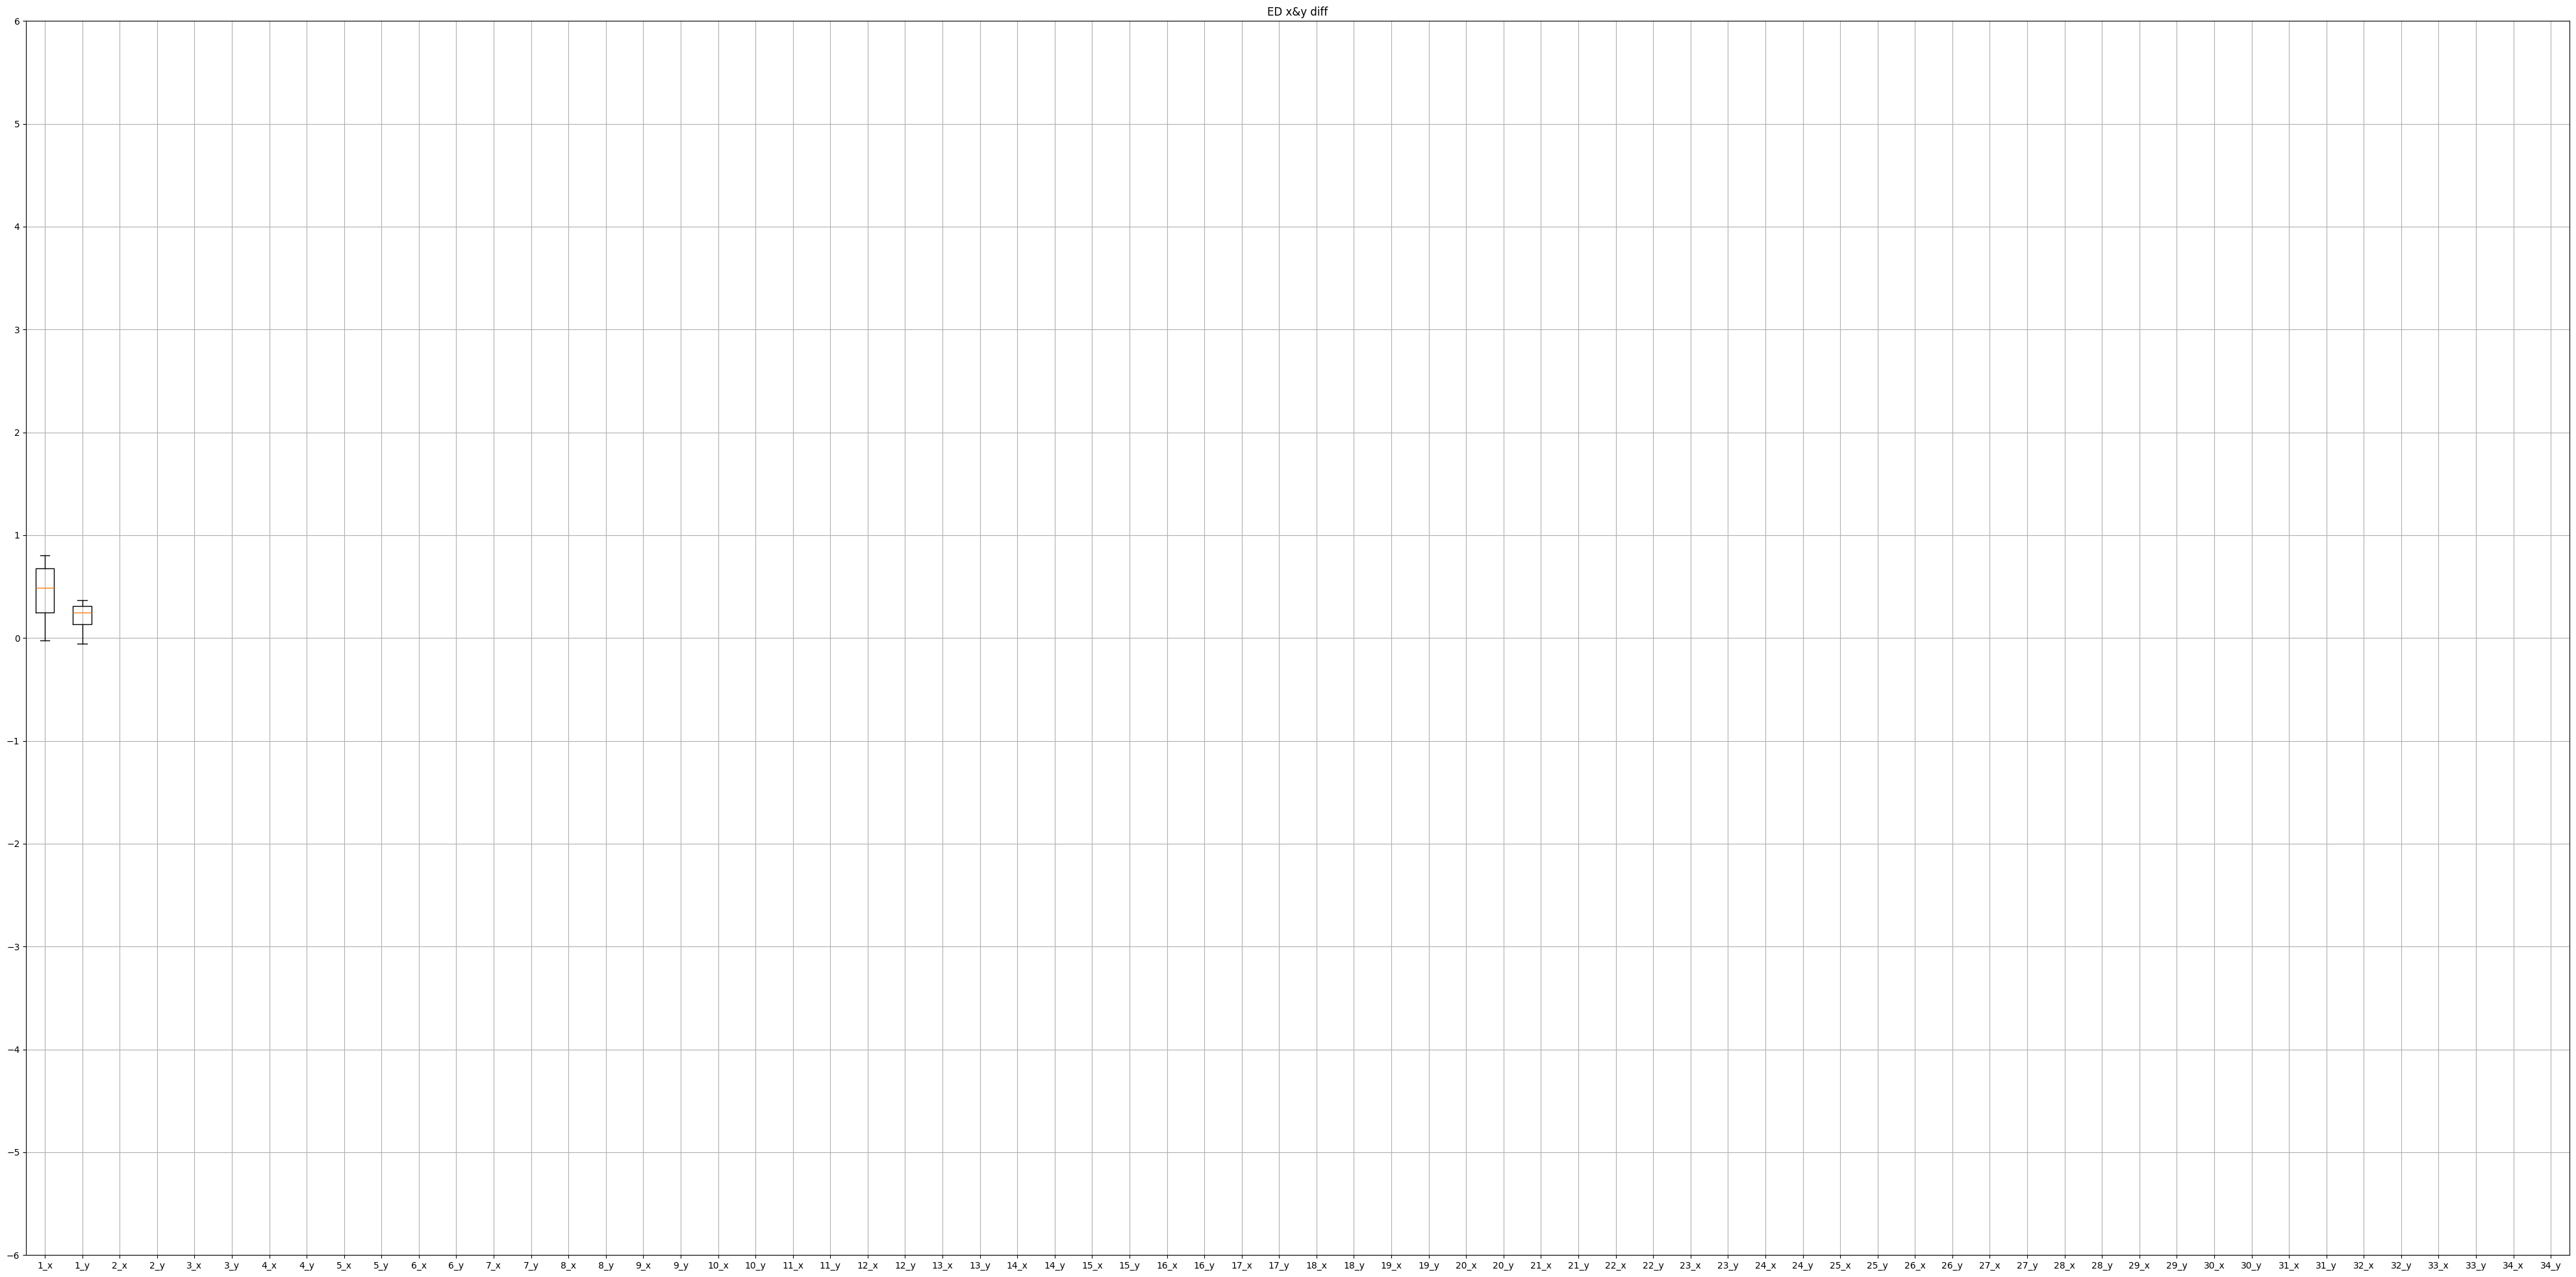

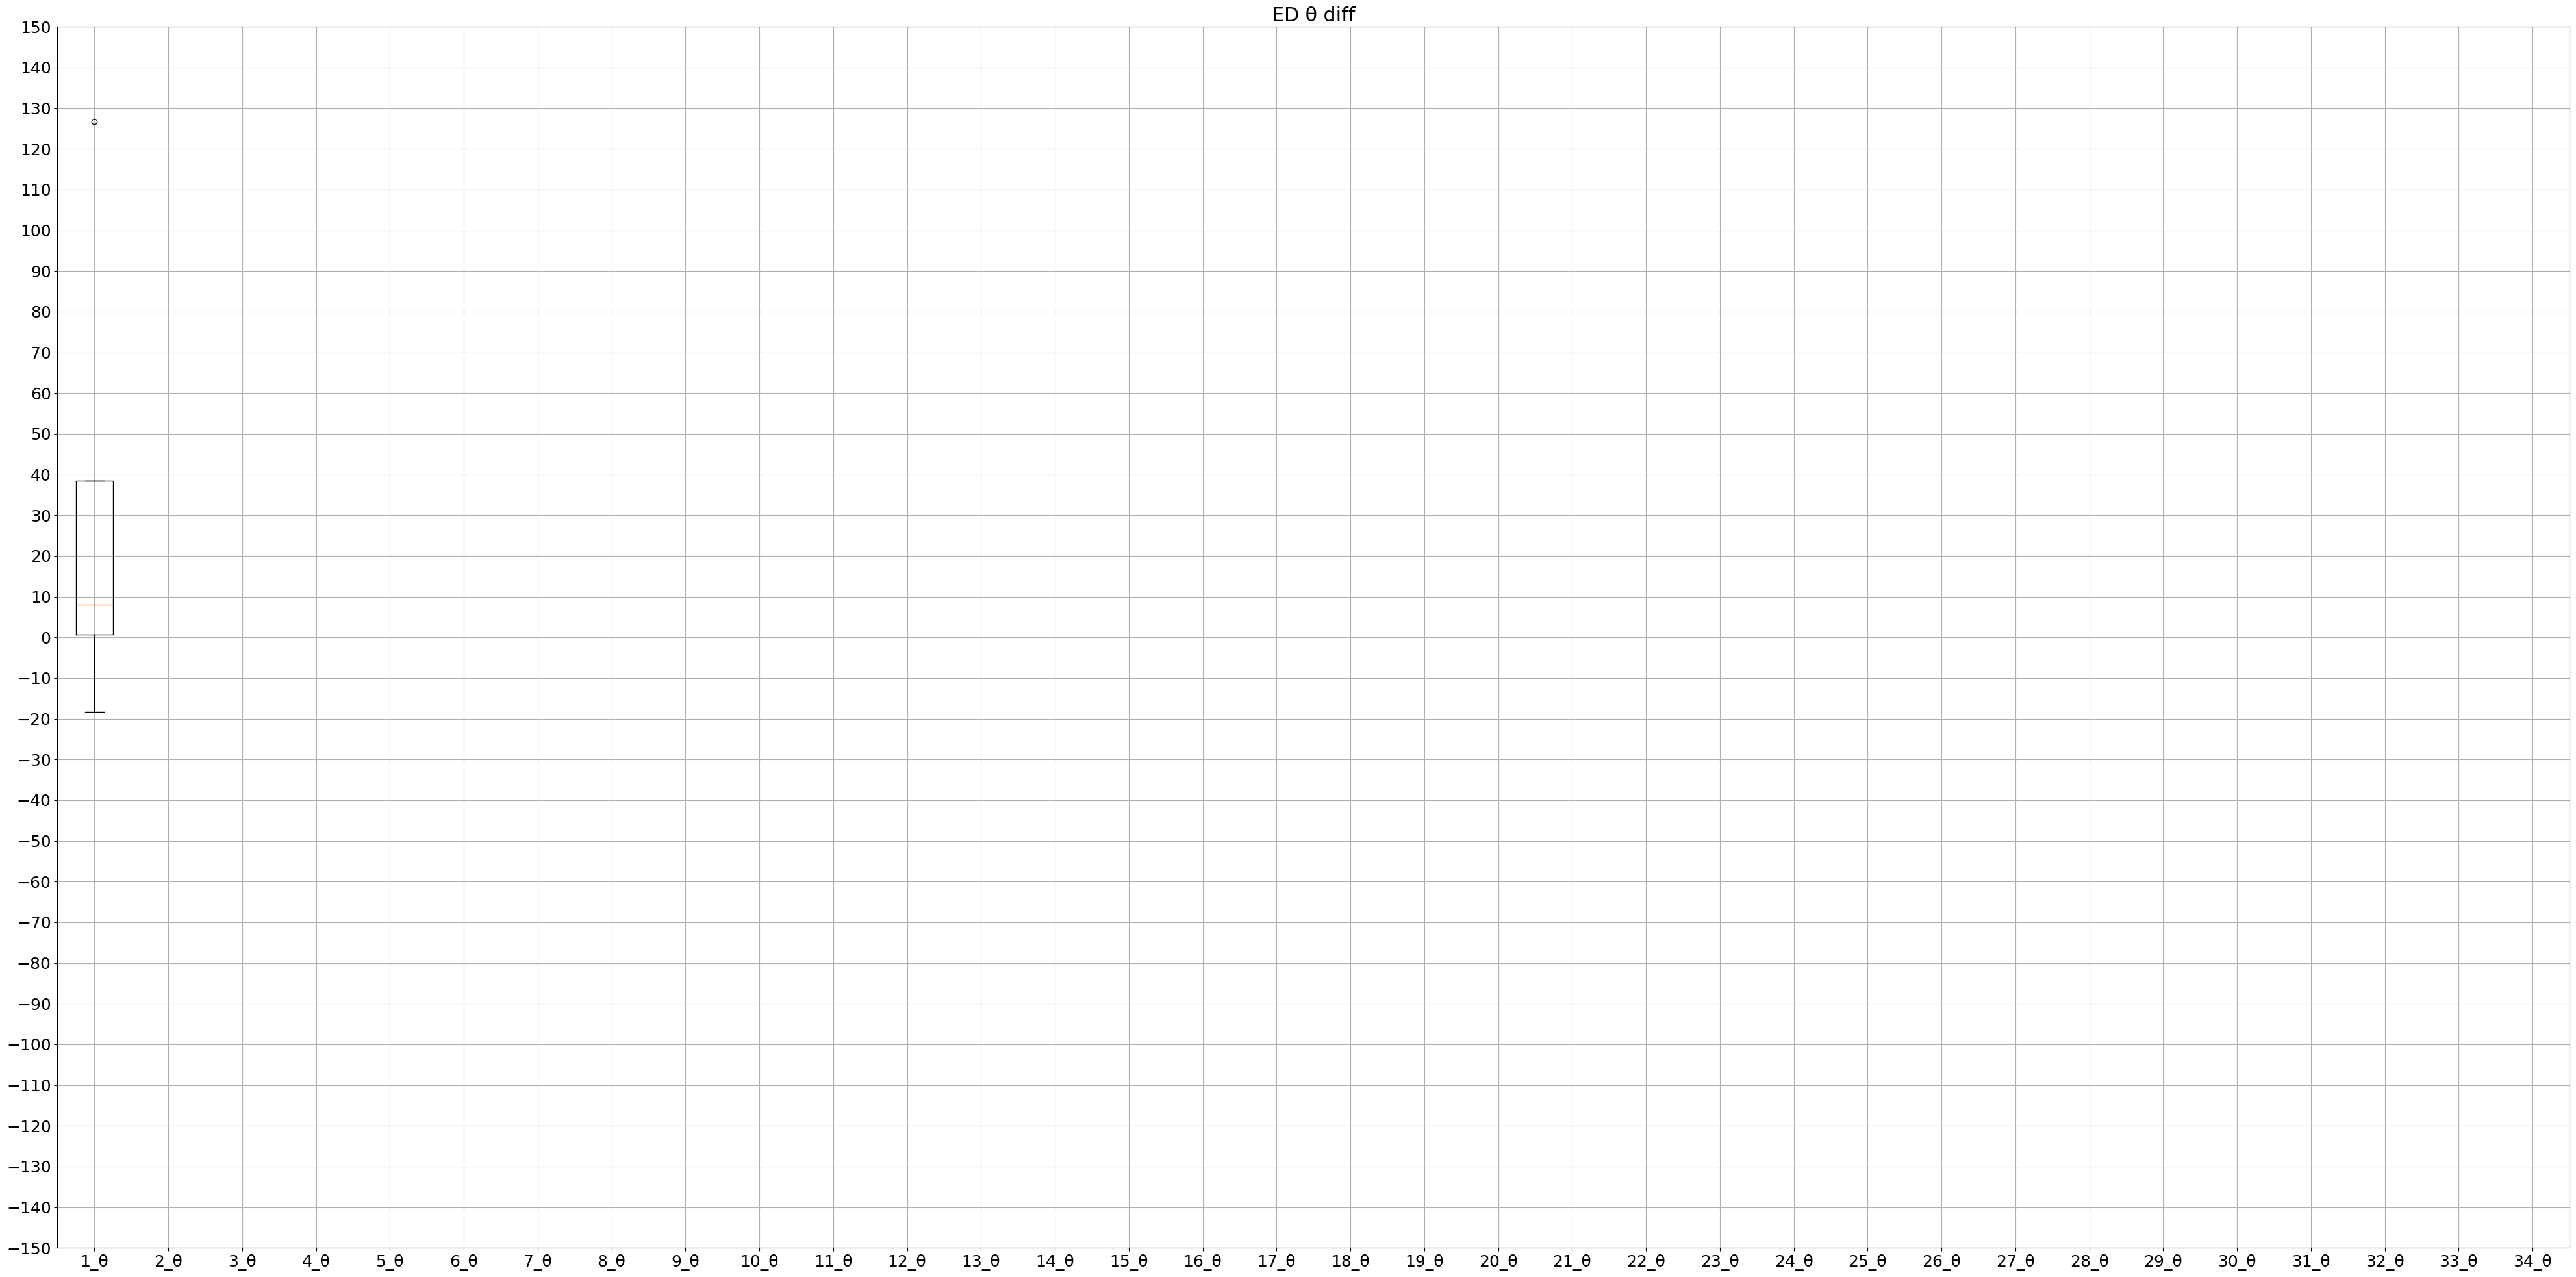

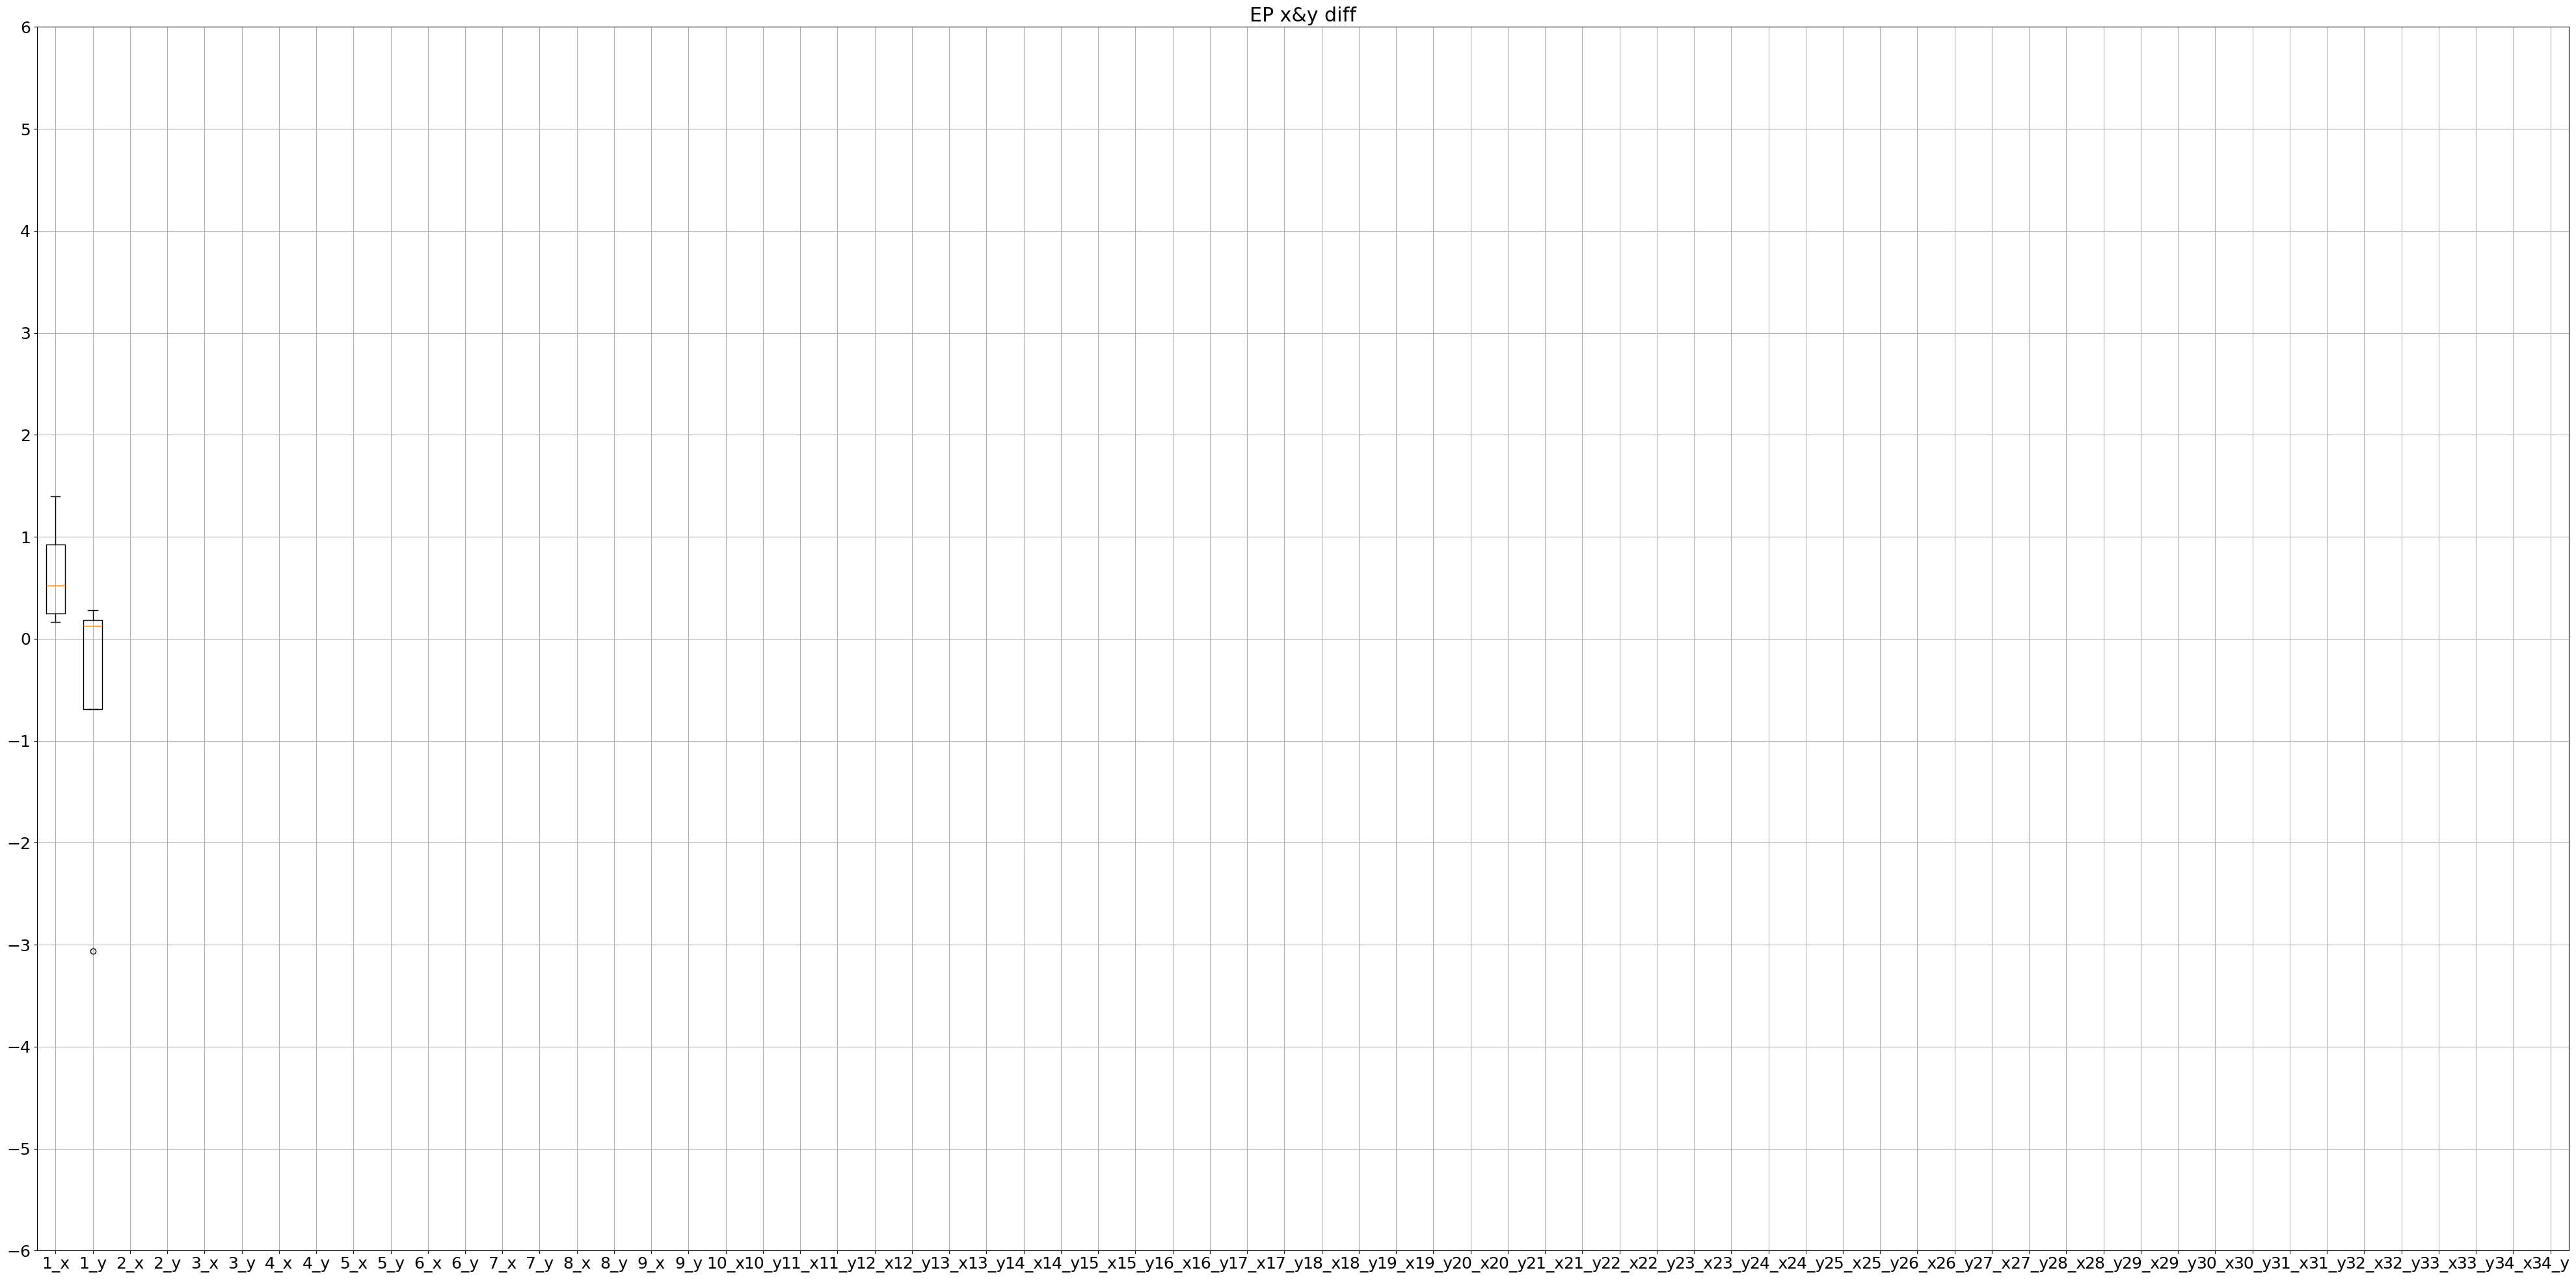

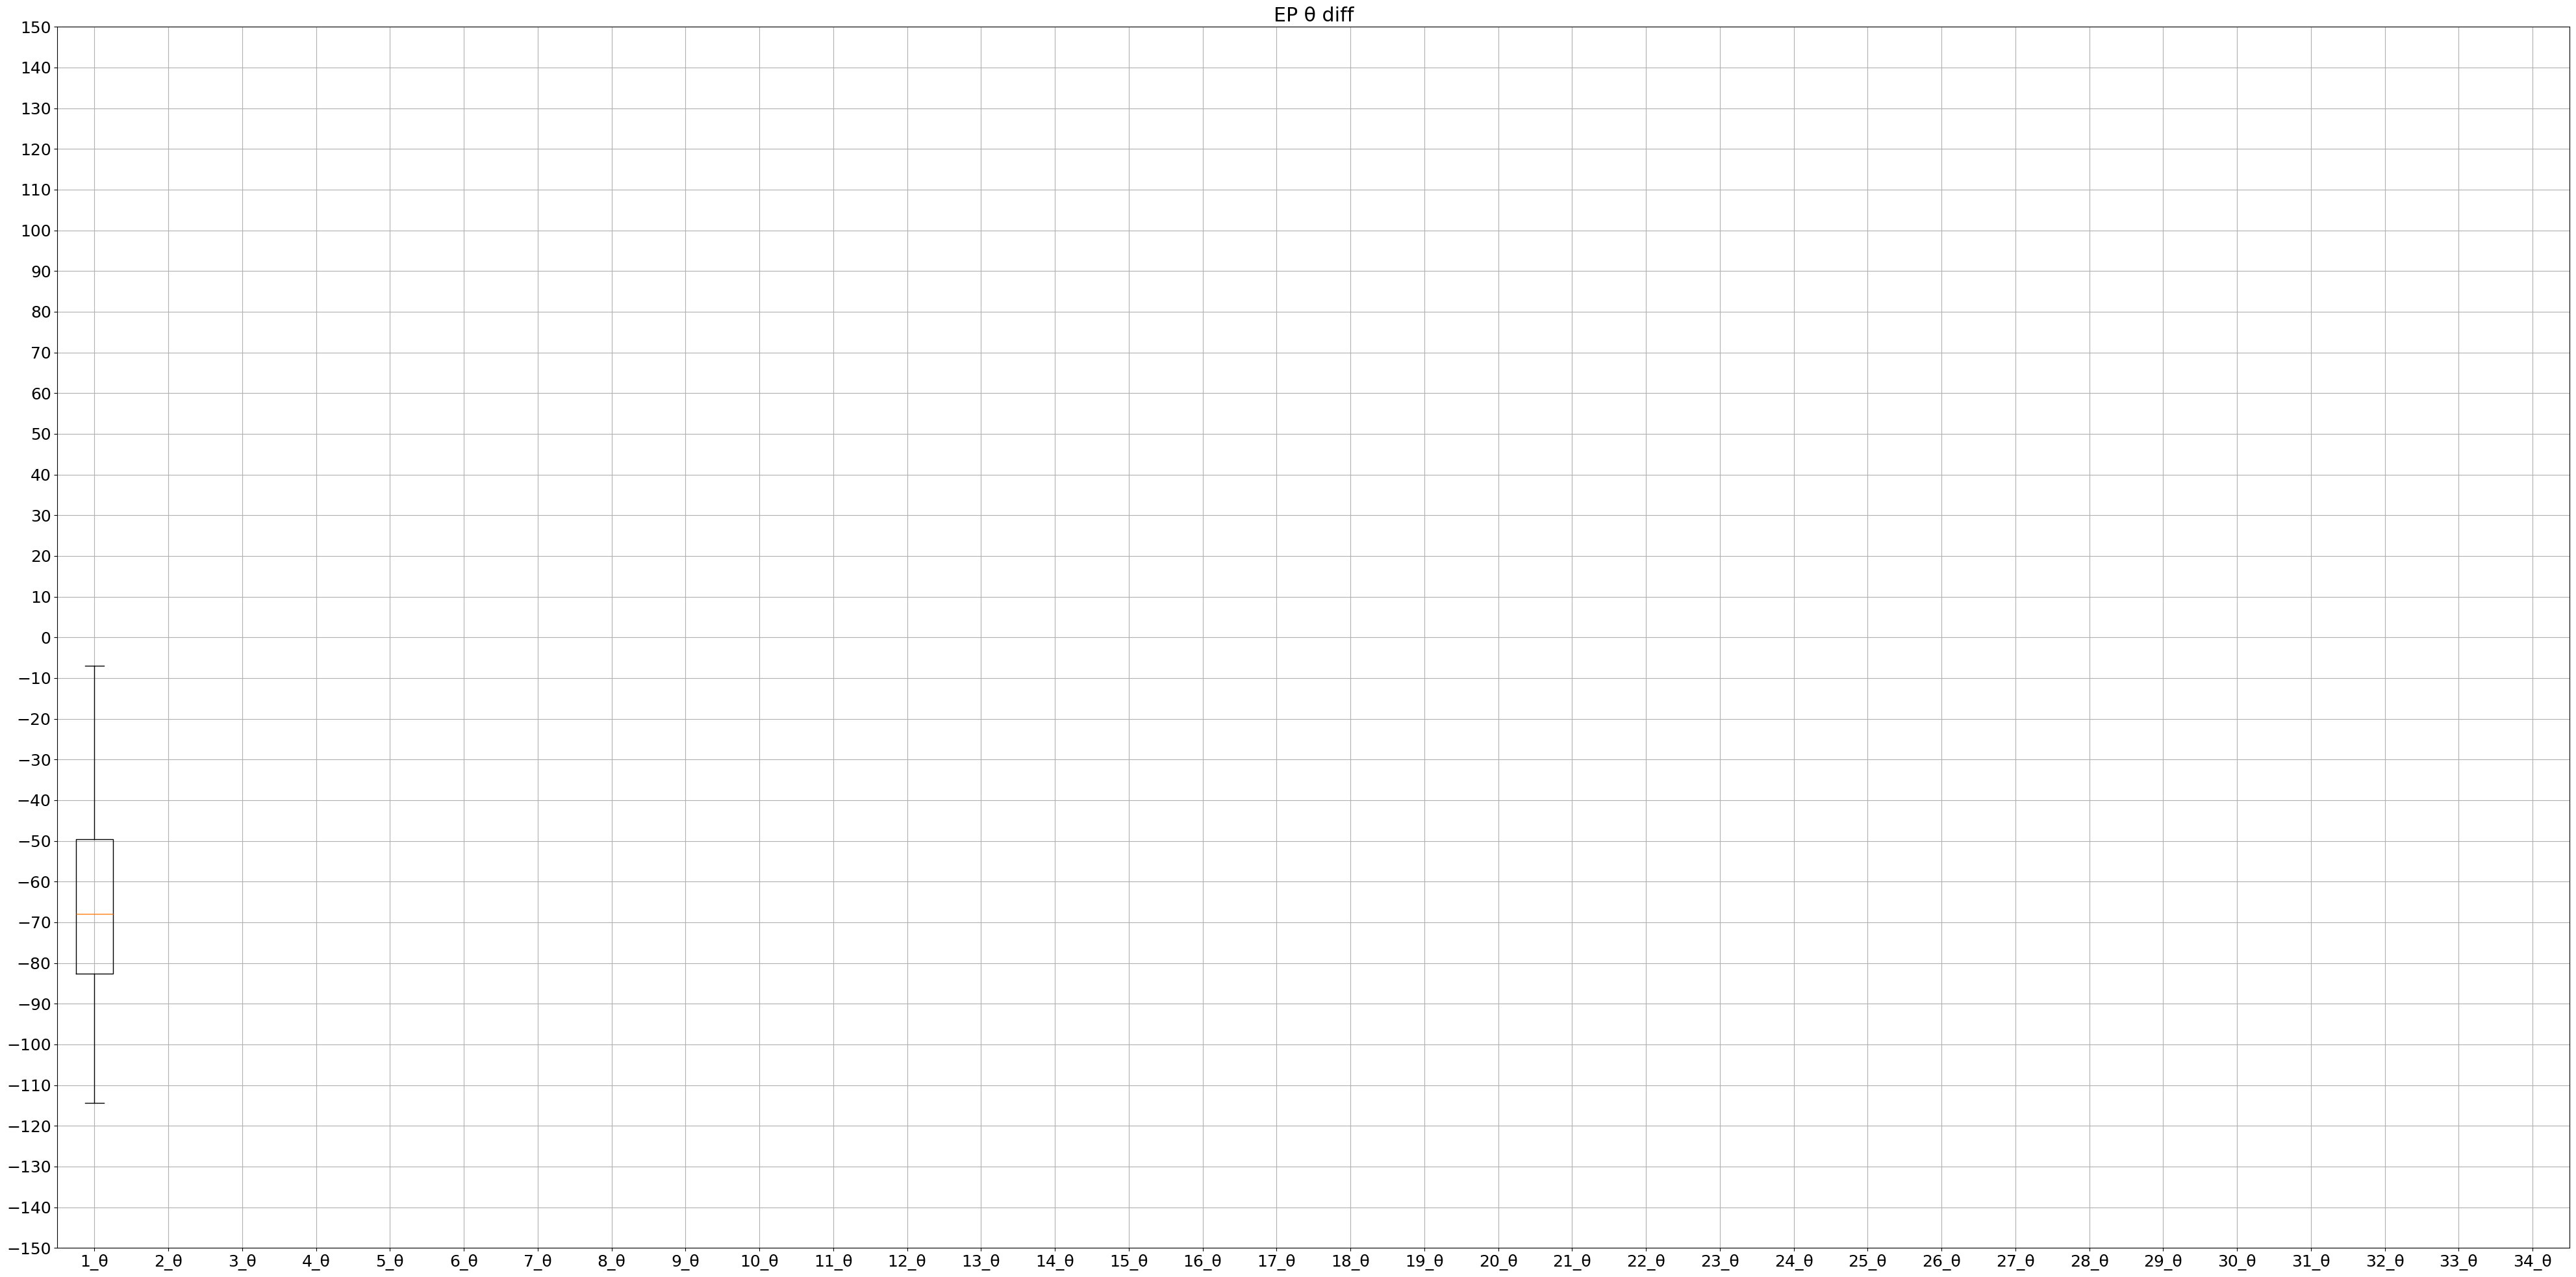

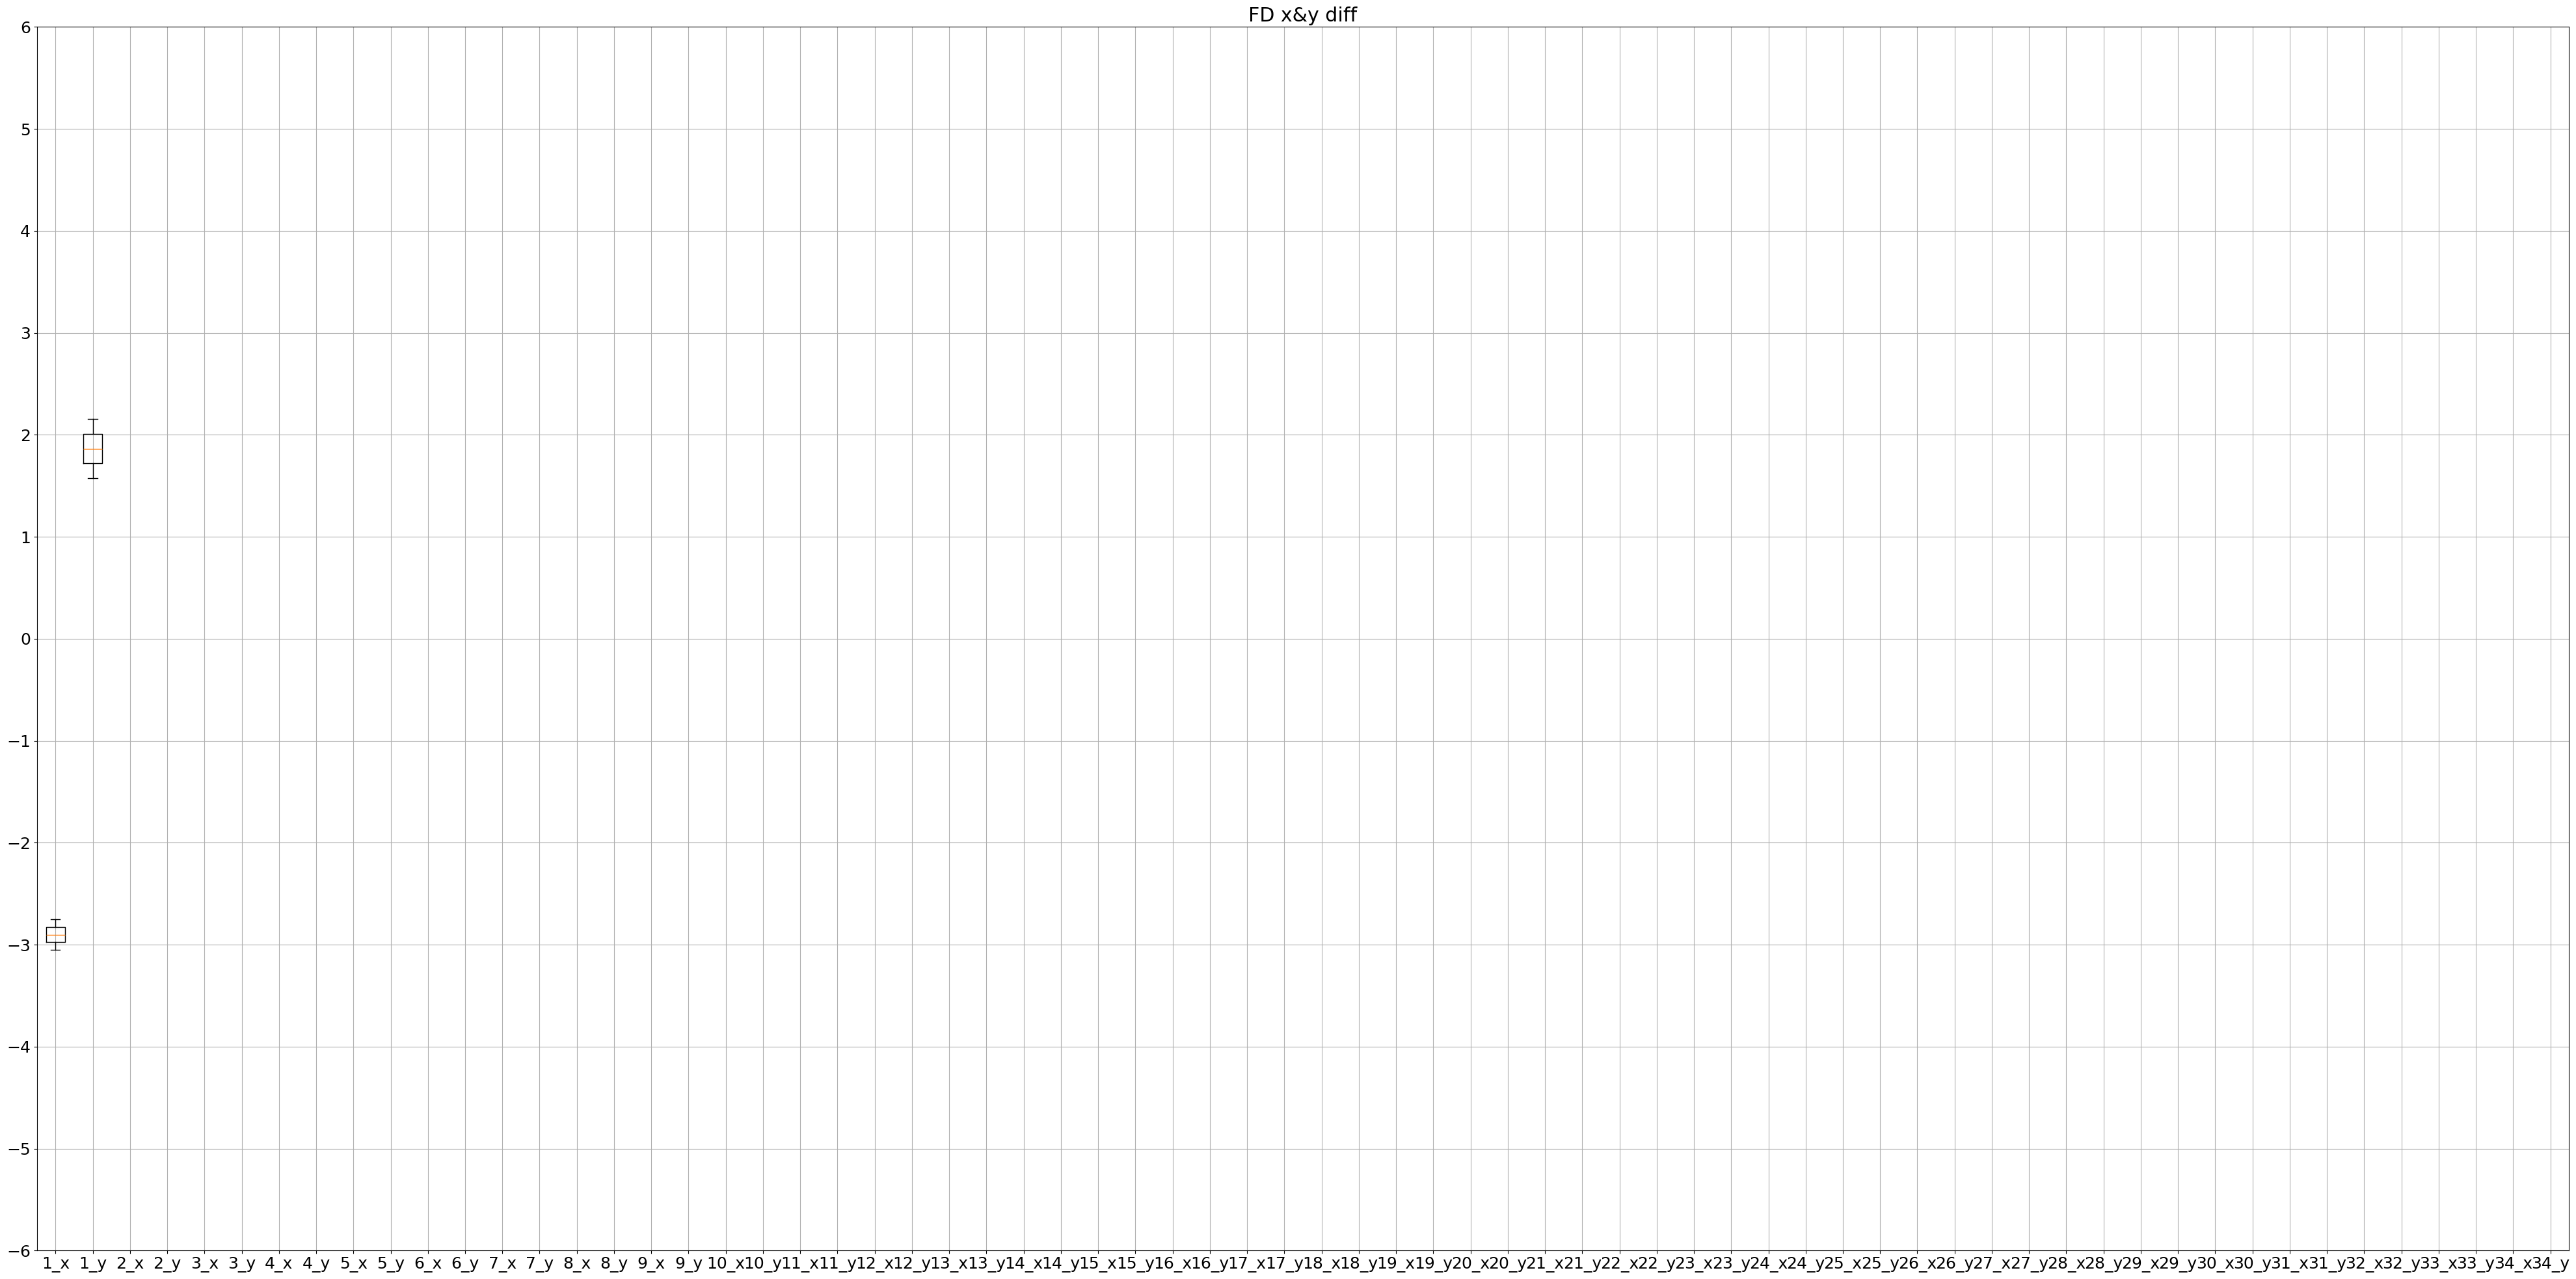

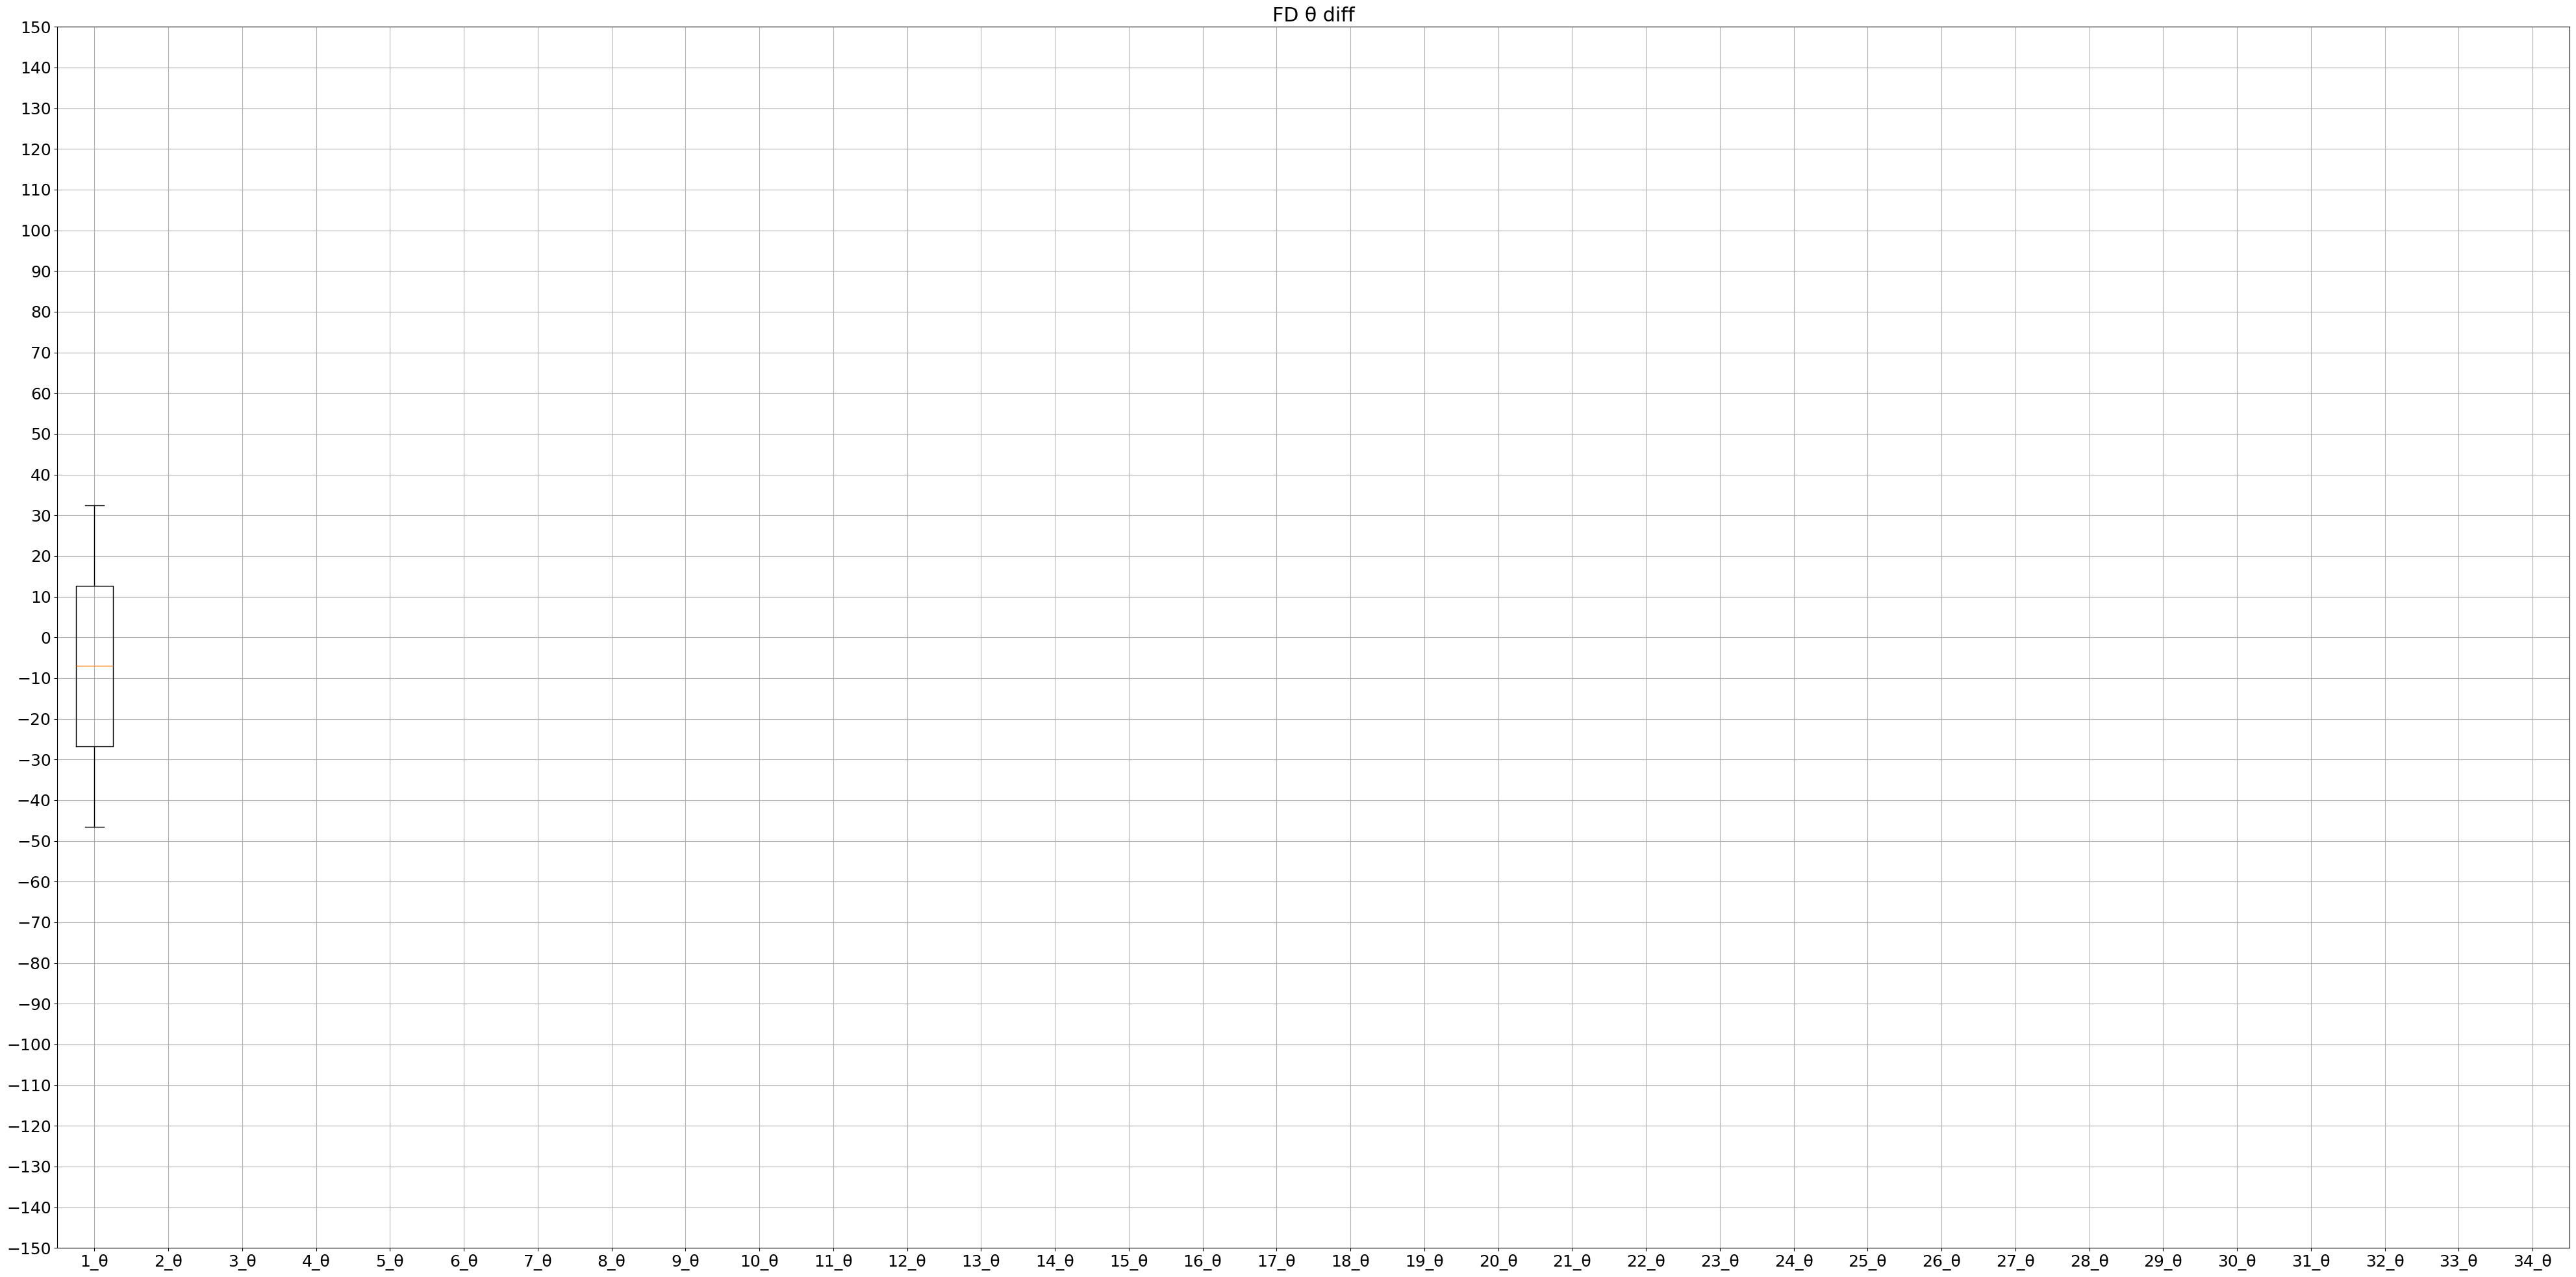

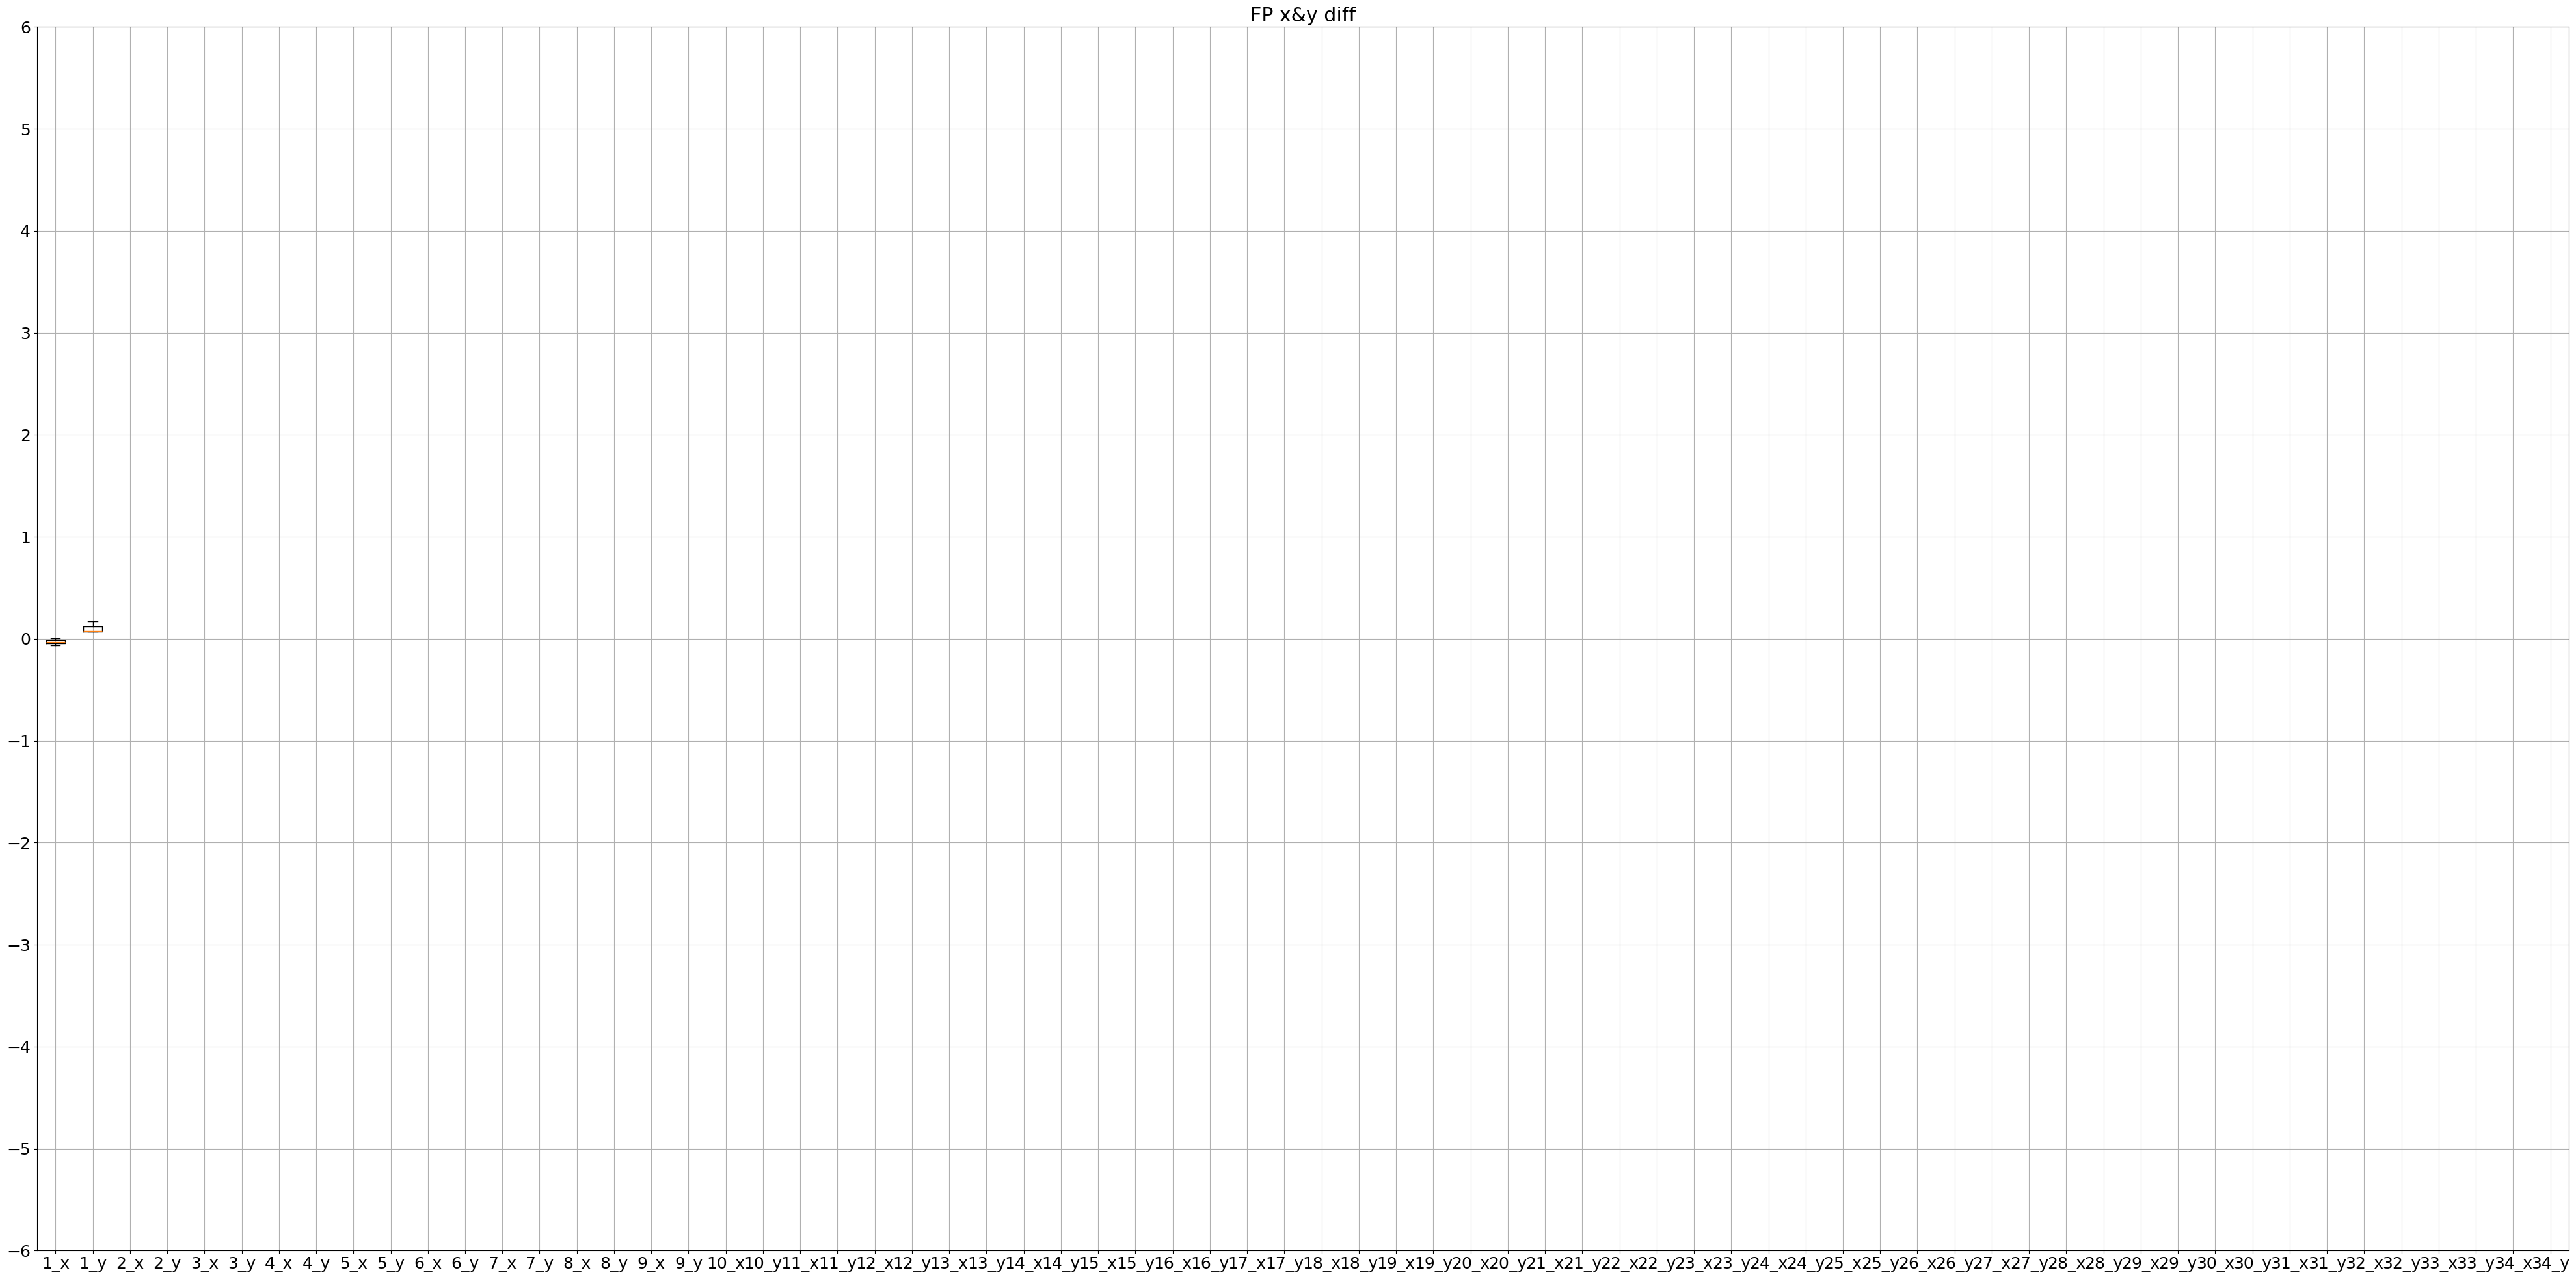

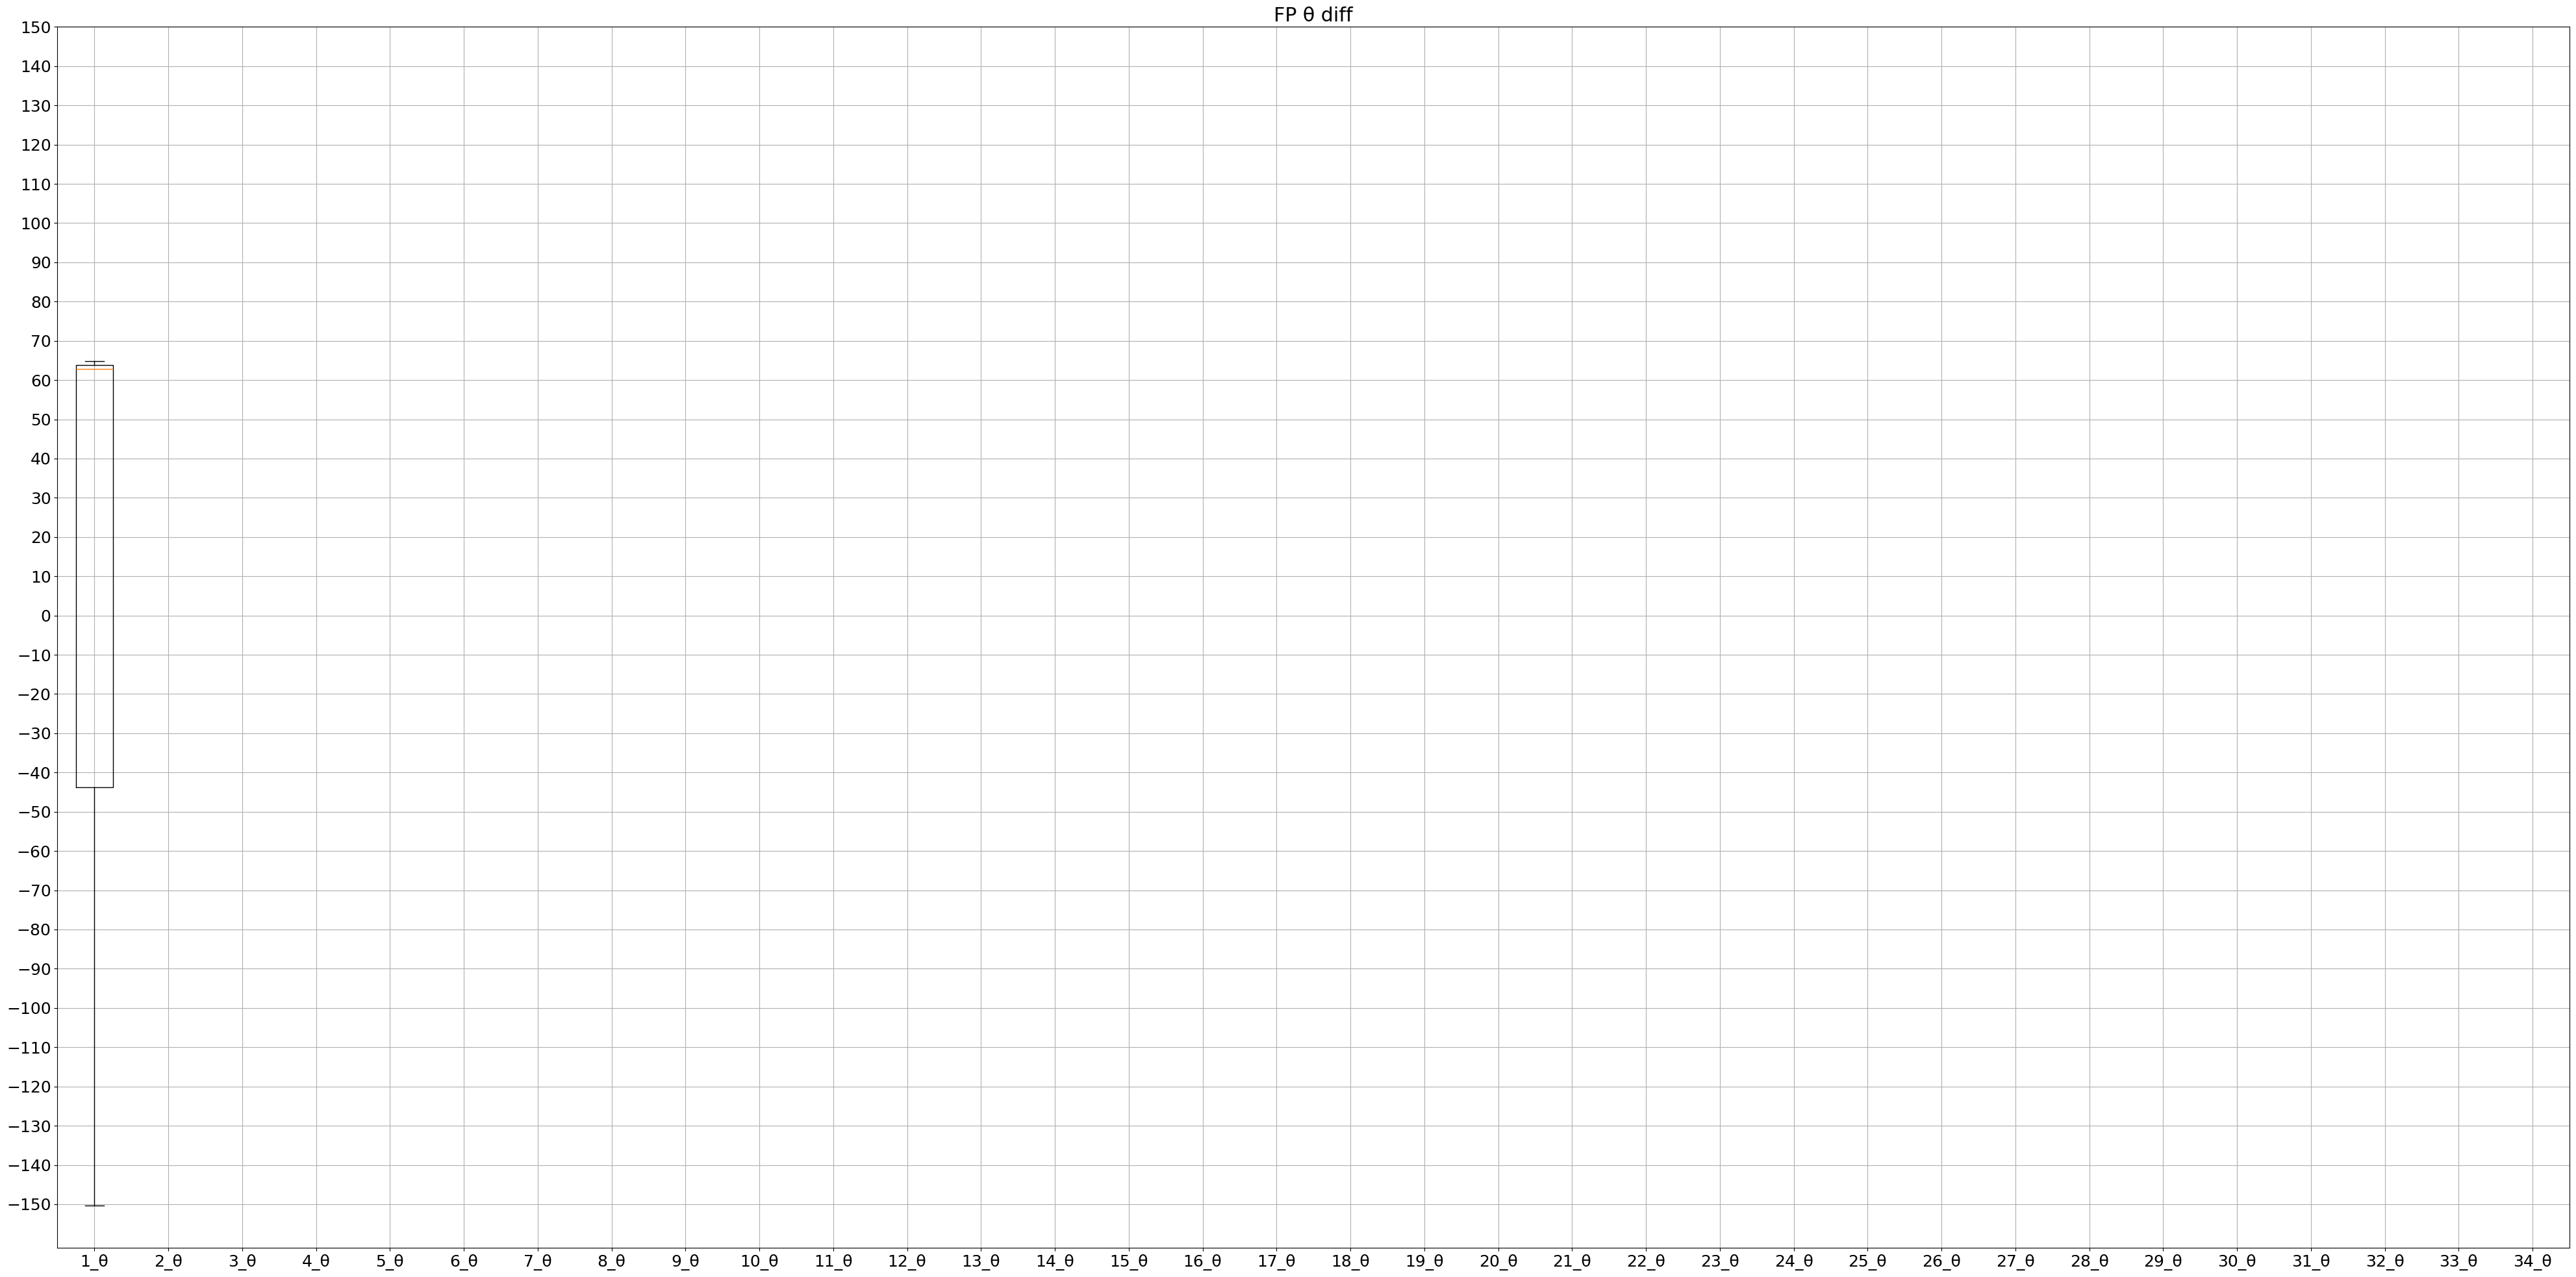

In [69]:
fig, ax = plt.subplots(figsize=(40,20), tight_layout=True)
ax.boxplot(ED_xy_list)
ax.set_xticklabels(['1_x','1_y','2_x','2_y','3_x','3_y','4_x','4_y','5_x','5_y','6_x','6_y','7_x','7_y','8_x','8_y','9_x','9_y','10_x','10_y','11_x','11_y','12_x','12_y','13_x','13_y','14_x','14_y','15_x','15_y','16_x','16_y','17_x','17_y','18_x','18_y','19_x','19_y','20_x','20_y','21_x','21_y','22_x','22_y','23_x','23_y','24_x','24_y','25_x','25_y','26_x','26_y','27_x','27_y','28_x','28_y','29_x','29_y','30_x','30_y','31_x','31_y','32_x','32_y','33_x','33_y','34_x','34_y'])
plt.title('ED x&y diff')
plt.rcParams['font.size'] = 18
plt.grid()
plt.yticks(range(-6, 7, 1))
plt.show()

fig, ax = plt.subplots(figsize=(40,20), tight_layout=True)
bp = ax.boxplot(ED_theta_list)
ax.set_xticklabels(['1_θ','2_θ','3_θ','4_θ','5_θ','6_θ','7_θ','8_θ','9_θ','10_θ','11_θ','12_θ','13_θ','14_θ','15_θ','16_θ','17_θ','18_θ','19_θ','20_θ','21_θ','22_θ','23_θ','24_θ','25_θ','26_θ','27_θ','28_θ','29_θ','30_θ','31_θ','32_θ','33_θ','34_θ'])
plt.title('ED θ diff')
plt.rcParams['font.size'] = 18
plt.grid()
plt.yticks(range(-150, 151, 10))
plt.show()

fig, ax = plt.subplots(figsize=(40,20), tight_layout=True)
bp = ax.boxplot(EP_xy_list)
ax.set_xticklabels(['1_x','1_y','2_x','2_y','3_x','3_y','4_x','4_y','5_x','5_y','6_x','6_y','7_x','7_y','8_x','8_y','9_x','9_y','10_x','10_y','11_x','11_y','12_x','12_y','13_x','13_y','14_x','14_y','15_x','15_y','16_x','16_y','17_x','17_y','18_x','18_y','19_x','19_y','20_x','20_y','21_x','21_y','22_x','22_y','23_x','23_y','24_x','24_y','25_x','25_y','26_x','26_y','27_x','27_y','28_x','28_y','29_x','29_y','30_x','30_y','31_x','31_y','32_x','32_y','33_x','33_y','34_x','34_y'])
plt.title('EP x&y diff')
plt.rcParams['font.size'] = 18
plt.grid()
plt.yticks(range(-6, 7, 1))
plt.show()

fig, ax = plt.subplots(figsize=(40,20), tight_layout=True)
bp = ax.boxplot(EP_theta_list)
ax.set_xticklabels(['1_θ','2_θ','3_θ','4_θ','5_θ','6_θ','7_θ','8_θ','9_θ','10_θ','11_θ','12_θ','13_θ','14_θ','15_θ','16_θ','17_θ','18_θ','19_θ','20_θ','21_θ','22_θ','23_θ','24_θ','25_θ','26_θ','27_θ','28_θ','29_θ','30_θ','31_θ','32_θ','33_θ','34_θ'])
plt.title('EP θ diff')
plt.rcParams['font.size'] = 18
plt.grid()
plt.yticks(range(-150, 151, 10))
plt.show()

fig, ax = plt.subplots(figsize=(40,20), tight_layout=True)
bp = ax.boxplot(FD_xy_list)
ax.set_xticklabels(['1_x','1_y','2_x','2_y','3_x','3_y','4_x','4_y','5_x','5_y','6_x','6_y','7_x','7_y','8_x','8_y','9_x','9_y','10_x','10_y','11_x','11_y','12_x','12_y','13_x','13_y','14_x','14_y','15_x','15_y','16_x','16_y','17_x','17_y','18_x','18_y','19_x','19_y','20_x','20_y','21_x','21_y','22_x','22_y','23_x','23_y','24_x','24_y','25_x','25_y','26_x','26_y','27_x','27_y','28_x','28_y','29_x','29_y','30_x','30_y','31_x','31_y','32_x','32_y','33_x','33_y','34_x','34_y'])
plt.title('FD x&y diff')
plt.rcParams['font.size'] = 18
plt.grid()
plt.yticks(range(-6, 7, 1))
plt.show()

fig, ax = plt.subplots(figsize=(40,20), tight_layout=True)
bp = ax.boxplot(FD_theta_list)
ax.set_xticklabels(['1_θ','2_θ','3_θ','4_θ','5_θ','6_θ','7_θ','8_θ','9_θ','10_θ','11_θ','12_θ','13_θ','14_θ','15_θ','16_θ','17_θ','18_θ','19_θ','20_θ','21_θ','22_θ','23_θ','24_θ','25_θ','26_θ','27_θ','28_θ','29_θ','30_θ','31_θ','32_θ','33_θ','34_θ'])
plt.title('FD θ diff')
plt.rcParams['font.size'] = 18
plt.grid()
plt.yticks(range(-150, 151, 10))
plt.show()

fig, ax = plt.subplots(figsize=(40,20), tight_layout=True)
bp = ax.boxplot(FP_xy_list)
ax.set_xticklabels(['1_x','1_y','2_x','2_y','3_x','3_y','4_x','4_y','5_x','5_y','6_x','6_y','7_x','7_y','8_x','8_y','9_x','9_y','10_x','10_y','11_x','11_y','12_x','12_y','13_x','13_y','14_x','14_y','15_x','15_y','16_x','16_y','17_x','17_y','18_x','18_y','19_x','19_y','20_x','20_y','21_x','21_y','22_x','22_y','23_x','23_y','24_x','24_y','25_x','25_y','26_x','26_y','27_x','27_y','28_x','28_y','29_x','29_y','30_x','30_y','31_x','31_y','32_x','32_y','33_x','33_y','34_x','34_y'])
plt.title('FP x&y diff')
plt.rcParams['font.size'] = 18
plt.grid()
plt.yticks(range(-6, 7, 1))
plt.show()

fig, ax = plt.subplots(figsize=(40,20), tight_layout=True)
bp = ax.boxplot(FP_theta_list)
ax.set_xticklabels(['1_θ','2_θ','3_θ','4_θ','5_θ','6_θ','7_θ','8_θ','9_θ','10_θ','11_θ','12_θ','13_θ','14_θ','15_θ','16_θ','17_θ','18_θ','19_θ','20_θ','21_θ','22_θ','23_θ','24_θ','25_θ','26_θ','27_θ','28_θ','29_θ','30_θ','31_θ','32_θ','33_θ','34_θ'])
plt.title('FP θ diff')
plt.rcParams['font.size'] = 18
plt.grid()
plt.yticks(range(-150, 151, 10))
plt.show()

In [430]:
x_EP_gesture

{1: [3.9834823697861856,
  0.7655725323054208,
  3.10617847342346,
  4.05349287187996,
  0.02115415804537779,
  4.334289507071547,
  -2.0264028596544827,
  0.4968693264360893,
  -5.847779801428611,
  -3.4256882912377815,
  5.088462625187774,
  -2.815297700907411,
  -0.6464783735621789,
  -0.1856303651496478],
 2: [-4.383692196949831,
  4.804497197418508,
  0.7248619611685081,
  -3.791830325561055,
  -0.04234048237382115,
  0.09624850053188716,
  4.345596361753619,
  -2.9286777577151706,
  -5.986402567666984,
  -0.1973619220428227],
 3: [-4.272417083576745,
  -1.4333028944917685,
  -1.710188106816556,
  -3.6334575541587704,
  -1.1952906307007805,
  0.46390829100145536,
  0.6186796978131253,
  0.0863139874856862,
  0.3164866657704213,
  0.2793831342879537,
  -3.0361482531842716,
  -2.659884482496575,
  0.40483640553411027,
  -2.5013905247837376,
  -2.717533002360726],
 4: [-3.44605547402925,
  0.004803654453026773,
  0.22843289959930946,
  0.4934622049706885,
  -3.1976287312558105,
  -3.

In [35]:
record_session1 = wfdb.rdrecord('pr_dataset/subject01_session1/maintenance_preprocess_sample1')
record_session2 = wfdb.rdrecord('pr_dataset/subject01_session2/maintenance_preprocess_sample1')

In [36]:
filtered_emg_ED_session1 = record_session1.p_signal[:,:64] #Extensor Distal
filtered_emg_EP_session1 = record_session1.p_signal[:,64:128] #Extensor Proximal
filtered_emg_FD_session1 = record_session1.p_signal[:,128:192] #Flexor Distal
filtered_emg_FP_session1 = record_session1.p_signal[:,192:256] #Flexor Proximal

filtered_emg_ED_session2 = record_session2.p_signal[:,:64] #Extensor Distal
filtered_emg_EP_session2 = record_session2.p_signal[:,64:128] #Extensor Proximal
filtered_emg_FD_session2 = record_session2.p_signal[:,128:192] #Flexor Distal
filtered_emg_FP_session2 = record_session2.p_signal[:,192:256] #Flexor Proximal

In [37]:
def waveform_length(signal):
    return np.sum(np.abs(np.diff(signal, axis=0)), axis=0)

In [38]:
# ---------- パラメータ設定 ----------
window_size = 50 # ウィンドウの長さ（例: 50サンプル）
threshold = 0   # PTPの最大 - 平均がこの値以上なら採用
half_win = window_size // 2

# ---------- EMG信号（例：num_samples × 64） ----------
# num_samples = 5000
emg_data = emg_data

# ---------- 出力先 ----------
valid_indices = []

# ---------- 64チャネルすべてに対してピーク検出 ----------
peak_mask = np.zeros(emg_data.shape[0], dtype=bool)

for ch in range(64):
    rms_signal = np.sqrt(emg_data[:,ch]**2)
    peaks, _ = find_peaks(rms_signal, distance=50,
                    height=np.mean(rms_signal) + np.std(rms_signal))
    # peaks, _ = find_peaks(emg_data[:, ch], distance=window_size//2, height=np.std(emg_data[:,ch]) * 1)
    peak_mask[peaks] = True  # どこか1チャネルでもピークがあればTrue

# ---------- 全体でのピーク位置で条件を評価 ----------
for t in np.where(peak_mask)[0]:
    if t - half_win < 0 or t + half_win >= emg_data.shape[0]:
        continue  # ウィンドウが境界を超えるならスキップ

    snippet = emg_data[t - half_win : t + half_win, :]  # shape: [window_size, 64]
    ptp_per_ch = snippet.max(axis=0) - snippet.min(axis=0)  # 各チャネルのPTP
    ptp_mean = np.mean(ptp_per_ch)
    ptp_max = np.max(ptp_per_ch)

    if ptp_max - ptp_mean >= threshold:
        valid_indices.append(t)

print(f"検出されたピーク数（条件を満たすもの）: {len(valid_indices)}")

# ----- MUAP波形の切り出し -----
snippets = []
valid_peaks = []
for peak in valid_indices:
    if peak - window_size//2 >= 0 and peak + window_size//2 < emg_data.shape[0]:
        snippet = emg_data[peak - window_size//2 : peak + window_size//2, :]
        snippets.append(snippet)
        valid_peaks.append(peak)

snippets = np.array(snippets)
valid_peaks = np.array(valid_peaks)

print(f'snippets.shape: {snippets.shape}')  # shape: (num_snippets, window_size, 64)


# 座標グリッド
x = np.arange(8)
y = np.arange(8)
xv, yv = np.meshgrid(x, y)
coords = np.vstack((xv.ravel(), yv.ravel()))



centers = []
directions = []
theta_1s = []
features = []
for snippet in snippets[:]:
    print(f'snippet.shape: {snippet.shape}')  # shape: (window_size, 64)
    segment = snippet
    #ピーク間振幅
    ptp = np.ptp(segment,axis=0) #shape:(64,)
    map_2d = ptp.reshape(8, 8)
    print(f'ptp.shape: {ptp.shape}')  # shape: (64,)
    print(f'map_2d.shape: {map_2d.shape}')  # shape: (8, 8)

    # フィッティング
    max_ptp_index = np.unravel_index(np.argmax(map_2d), map_2d.shape)
    # print(f'max_ptp_index:({max_ptp_index[0]},{max_ptp_index[1]})')
    initial = [np.max(ptp)-np.min(ptp), max_ptp_index[0], max_ptp_index[1], 1, 1, 0, np.min(ptp)]
    bounds = ([0, 0, 0, 0.1, 0.1, -np.pi/2, -np.inf],
                [np.inf, 7, 7, 5, 5, np.pi/2, np.inf])
    popt, _ = curve_fit(gaussian_2d, coords, ptp, p0=initial, bounds=bounds, maxfev=10000)
    A, x0, y0, sigma_x, sigma_y, theta, offset = popt #パラメータ取得
    center = (x0, y0)
    if sigma_x > sigma_y:
        theta_1 = theta
        # print('σx > σy')
    else:
        if theta >= 0:
            theta_1 = theta - np.pi/2
        else:
            theta_1 = theta + np.pi/2
            # print('σy >= σx')
    direction = (np.cos(theta_1), np.sin(theta_1))

    centers.append(center)
    directions.append(direction)
    theta_1s.append(np.degrees(theta_1))

    feature = []
    feature.append(center[0])
    feature.append(center[1])
    feature.append(np.degrees(theta_1))
    features.append(feature)

    # print(centers)
    # print(directions)
    # print(theta_1s)
    # print(f'all centers:: ave:{np.mean(centers, axis=0)}, std:{np.std(centers, axis=0)}')
    # print(f'all theta_1:: ave:{np.mean(theta_1s, axis=0)}, std:{np.std(theta_1s, axis=0)}')

features

検出されたピーク数（条件を満たすもの）: 349
snippets.shape: (349, 50, 64)
snippet.shape: (50, 64)
ptp.shape: (64,)
map_2d.shape: (8, 8)
snippet.shape: (50, 64)
ptp.shape: (64,)
map_2d.shape: (8, 8)
snippet.shape: (50, 64)
ptp.shape: (64,)
map_2d.shape: (8, 8)
snippet.shape: (50, 64)
ptp.shape: (64,)
map_2d.shape: (8, 8)
snippet.shape: (50, 64)
ptp.shape: (64,)
map_2d.shape: (8, 8)
snippet.shape: (50, 64)
ptp.shape: (64,)
map_2d.shape: (8, 8)
snippet.shape: (50, 64)
ptp.shape: (64,)
map_2d.shape: (8, 8)
snippet.shape: (50, 64)
ptp.shape: (64,)
map_2d.shape: (8, 8)
snippet.shape: (50, 64)
ptp.shape: (64,)
map_2d.shape: (8, 8)
snippet.shape: (50, 64)
ptp.shape: (64,)
map_2d.shape: (8, 8)
snippet.shape: (50, 64)
ptp.shape: (64,)
map_2d.shape: (8, 8)
snippet.shape: (50, 64)
ptp.shape: (64,)
map_2d.shape: (8, 8)
snippet.shape: (50, 64)
ptp.shape: (64,)
map_2d.shape: (8, 8)
snippet.shape: (50, 64)
ptp.shape: (64,)
map_2d.shape: (8, 8)
snippet.shape: (50, 64)
ptp.shape: (64,)
map_2d.shape: (8, 8)
snippet.shape: 

[[1.200056181681506, 3.1502936619879134, 39.989373659060476],
 [1.5579190762791288, 3.545471400660805, -36.78252416425361],
 [4.1315956657376995, 1.1653492278059587, -24.384341435249073],
 [3.9508334119813293, 1.4177683319259595, 74.44053443869595],
 [3.8633984508831274, 2.7595875908178003, 66.27092889937089],
 [3.8633984508831274, 2.7595875908178003, 66.27092889937089],
 [2.784189808214113, 1.4159034256738694, 0.7569603635749748],
 [2.784189808214113, 1.4159034256738694, 0.7569603635749748],
 [2.7895389332928033, 1.4301067323490964, 0.8129485616216111],
 [3.1854069985130256, 3.040968193784574, 46.96240325503049],
 [3.1854069985130256, 3.040968193784574, 46.96240325503049],
 [3.1854069985130256, 3.040968193784574, 46.96240325503049],
 [3.0995552141907026, 2.9977226429391863, 46.51495615066581],
 [6.334203195811498, 0.2954419156611751, 67.44322462565316],
 [1.831307686464441e-22, 2.9478917791711936, 71.79041442060642],
 [6.129092604192591, 0.4382138439952127, 40.014474185591155],
 [3.87

In [48]:
np.array(features).shape

(645, 3)

In [54]:
emg_data= filtered_emg_EP_session1
curve=gaussian_2d
fs=2000
window_ms=200
stride_ms=50
feature_func = waveform_length
# --- データ読み込み例（ここではダミーデータ） ---
fs = fs  # サンプリング周波数
window_ms = window_ms    # ウィンドウ幅 [ms]
stride_ms = stride_ms    # スライド幅 [ms]
window_size = int(fs * (window_ms / 1000))  # サンプル数に変換
stride_size = int(fs * stride_ms / 1000)  # スライド数
n_samples = emg_data.shape[0]
# 座標グリッド
x = np.arange(8)
y = np.arange(8)
xv, yv = np.meshgrid(x, y)
coords = np.vstack((xv.ravel(), yv.ravel()))

centers = []
directions = []
theta_1s = []
mucle_activity_information_list = []
for start in range(0, n_samples - window_size + 1, stride_size):
    end = start + window_size
    window_emg = emg_data[start:end, :]
    print(f'window_emg shape: {window_emg.shape}')
    #特徴量抽出
    print(np.diff(window_emg, axis=0).shape)
    print(np.abs(np.diff(window_emg, axis=0)).shape)
    print(np.sum(np.abs(np.diff(window_emg, axis=0)), axis=0).shape)
    feature = feature_func(window_emg) # shape: (n_channels,)
    print(f'feature shape: {feature.shape}')
    map_2d = feature.reshape(8, 8)  # 8x8のマップに変形
    print(f'map_2d shape: {map_2d.shape}')  # shape: (8, 8)
    # フィッティング
    max_index = np.unravel_index(np.argmax(map_2d), map_2d.shape)
    # print(f'max_ptp_index:({max_ptp_index[0]},{max_ptp_index[1]})')
    initial = [np.max(feature)-np.min(feature), max_index[0], max_index[1], 1, 1, 0, np.min(feature)]
    bounds = ([0, 0, 0, 0.1, 0.1, -np.pi/2, -np.inf],
            [np.inf, 7, 7, 5, 5, np.pi/2, np.inf])
    popt, _ = curve_fit(curve, coords, feature, p0=initial, bounds=bounds, maxfev=10000)
    A, x0, y0, sigma_x, sigma_y, theta, offset = popt #パラメータ取得
    center = (x0, y0)
    if sigma_x > sigma_y:
        theta_1 = theta
        # print('σx > σy')
    else:
        if theta >= 0:
            theta_1 = theta - np.pi/2
        else:
            theta_1 = theta + np.pi/2
        # print('σy >= σx')
    direction = (np.cos(theta_1), np.sin(theta_1))

    centers.append(center)
    directions.append(direction)
    theta_1s.append(np.degrees(theta_1))

    mucle_activity_information = []
    mucle_activity_information.append(center[0])
    mucle_activity_information.append(center[1])
    mucle_activity_information.append(np.degrees(theta_1))
    mucle_activity_information_list.append(mucle_activity_information)

# print(centers)
# print(directions)
# print(theta_1s)
# print(f'all centers:: ave:{np.mean(centers, axis=0)}, std:{np.std(centers, axis=0)}')
# print(f'all theta_1:: ave:{np.mean(theta_1s, axis=0)}, std:{np.std(theta_1s, axis=0)}')

mucle_activity_information_list

window_emg shape: (400, 64)
(399, 64)
(399, 64)
(64,)
feature shape: (64,)
map_2d shape: (8, 8)
window_emg shape: (400, 64)
(399, 64)
(399, 64)
(64,)
feature shape: (64,)
map_2d shape: (8, 8)
window_emg shape: (400, 64)
(399, 64)
(399, 64)
(64,)
feature shape: (64,)
map_2d shape: (8, 8)
window_emg shape: (400, 64)
(399, 64)
(399, 64)
(64,)
feature shape: (64,)
map_2d shape: (8, 8)
window_emg shape: (400, 64)
(399, 64)
(399, 64)
(64,)
feature shape: (64,)
map_2d shape: (8, 8)
window_emg shape: (400, 64)
(399, 64)
(399, 64)
(64,)
feature shape: (64,)
map_2d shape: (8, 8)
window_emg shape: (400, 64)
(399, 64)
(399, 64)
(64,)
feature shape: (64,)
map_2d shape: (8, 8)
window_emg shape: (400, 64)
(399, 64)
(399, 64)
(64,)
feature shape: (64,)
map_2d shape: (8, 8)
window_emg shape: (400, 64)
(399, 64)
(399, 64)
(64,)
feature shape: (64,)
map_2d shape: (8, 8)
window_emg shape: (400, 64)
(399, 64)
(399, 64)
(64,)
feature shape: (64,)
map_2d shape: (8, 8)
window_emg shape: (400, 64)
(399, 64)
(3

[[1.1573336542680421, 0.6117760081697281, 9.682880552926957],
 [0.8038004420176678, 0.5020487853383633, 0.1327149861772337],
 [2.1593079231546937, 0.446428347513967, 12.72927415663151],
 [5.730288270625237, 0.44153151171161137, 0.3922099052353644],
 [3.5051987551291, 1.4465663872182206, 18.03310119359767],
 [6.510116368426422, 0.8768204037346855, 79.79986400457443],
 [3.1175481216350844, 6.9651238268313245, -64.51810140974112],
 [5.496013308782474, 1.5079510193018184, 87.69033836322316],
 [5.475794510737026, 1.5045582148835706, 70.91185428475684],
 [4.398417337604989, 6.999999999999998, -50.62929654289814],
 [4.440213086934218, 6.9999999999965885, -51.660926477643464],
 [3.03868044776082, 5.291849108509711, -59.28368410815046],
 [2.4114024020829317, 4.427913837070378, -64.02515628924594],
 [2.3371681414241636, 4.271564249510845, -76.11163759615206],
 [5.885680803798834, 0.5150860502032295, 0.01478552604494222],
 [5.13404691868666, 0.5122112285219559, -10.064292588848476],
 [0.837935309

In [55]:
np.array(mucle_activity_information_list).shape

(78, 3)

In [ ]:
ied = 2
results_df = results_df_session1
#仮想双極電極の電極間距離（cm）
a = ied

n_clusters = results_df['direction_cluster'].nunique()
cluster_colors = get_cluster_colors(n_clusters)

virtual_bipolars = []
labels = []
center_direction = []
for n, direction_cluster in enumerate(sorted(results_df['direction_cluster'].unique())):
  sub_df = results_df[results_df['direction_cluster'] == direction_cluster]
  if sub_df['center_cluster'].count() >= 20 and sub_df['center_x'].std() < 1 and sub_df['center_y'].std() < 1 and sub_df['theta_deg'].std() < 20:
    x, y = sub_df['center_x'].mean(), sub_df['center_y'].mean()
    theta = sub_df['theta_deg'].mean()
    dx, dy = np.cos(np.radians(theta)) * arrow_scale, np.sin(np.radians(theta)) * arrow_scale
    print(f'cluster:{direction_cluster}, x={x}, y={y}, θ={theta}')
    x1 = x - a/2*np.cos(np.radians(theta))
    y1 = y - a/2*np.sin(np.radians(theta))
    x2 = x + a/2*np.cos(np.radians(theta))
    y2 = y + a/2*np.sin(np.radians(theta))
    virtual_bipolars.append([x1, y1, x2, y2])
    labels.append(direction_cluster)
    center_direction.append([x, y, theta])
    # 色で中心クラスタを、マーカーサイズで方向クラスタを示す
    color = cluster_colors[n]
    plt.arrow(x, y, dx, dy, head_width=0.15, color=color, alpha=0.8)
    plt.plot(x, y, 'o', color=color,
              label=f"Center Cl {direction_cluster}" if f"Center Cl {direction_cluster}" not in plt.gca().get_legend_handles_labels()[1] else "")
# ラベル・軸
plt.xlabel("center_x")
plt.ylabel("center_y")
plt.title("2-Stage Clustering of Muscle Fiber Direction")
plt.grid(True)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.axis('equal')
plt.tight_layout()
plt.xlim(0, 7)
plt.ylim(0, 7)
plt.show()

print(len(virtual_bipolars))
# return virtual_bipolars, labels, center_direction

In [ ]:
#分類器
# from sklearn.model_selection import train_test_split
# from sklearn.svm import SVC
# from sklearn.metrics import classification_report, confusion_matrix

X_train = np.array(X_session1).reshape(-1,1)
y_train = np.array(y_session1).reshape(-1,1)
X_test = np.array(X_session2).reshape(-1,1)
y_test = np.array(y_session2).reshape(-1,1)

# データ分割
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# SVMモデル学習
model = SVC(kernel='rbf', probability=True, random_state=0)
model.fit(X_train, y_train)

prob_matrix = model.predict_proba(X_test) # shape: (n_test_samples, n_train_classes)
# === 各テストラベルごとに学習クラスへの平均確率を出力 ===
class_labels = model.classes_  # 学習クラス（例: [0, 1, 2]）

result = []

for test_label in np.unique(y_test):
    idx = y_test.reshape(-1) == test_label
    mean_prob = np.mean(prob_matrix[idx], axis=0)  # 学習クラスへの平均確率
    result.append([test_label] + list(mean_prob))

# === 表形式で表示 ===
columns = ['Test Label'] + [f"P(Train={cls})" for cls in class_labels]
df_result = pd.DataFrame(result, columns=columns)

# import seaborn as sns
# import matplotlib.pyplot as plt

print(df_result)

In [ ]:
max_train_idx = []
for i in range(np.array(result).shape[0]):
j = np.argmax(np.array(result)[i,1:])
max_train_idx.append(j)
# print(max_train_idx)
for k in set(max_train_idx):
if max_train_idx.count(k) >=2:
    idx = max_train_idx == k
    l = np.argmax(np.array(result)[idx, k+1], axis=0)
    max_test_idx = [i for i, j in enumerate(idx) if j == True]
    print(f'result[{max_test_idx[l]},{k+1}], train:{np.unique(y_train)[k]}, test:{np.unique(y_test)[max_test_idx[l]]}')
    center_x_diff, center_y_diff, theta_diff = calc_diff(k, max_test_idx[l], center_direction_session1, center_direction_session2)
    print(f'x_diff={center_x_diff}, y_diff={center_y_diff}, theta_diff={theta_diff}')
else:
    print(f'result[{max_train_idx.index(k)},{k+1}], train:{np.unique(y_train)[k]}, test:{np.unique(y_test)[max_train_idx.index(k)]}')
    center_x_diff, center_y_diff, theta_diff = calc_diff(k, max_train_idx.index(k), center_direction_session1, center_direction_session2)
    print(f'x_diff={center_x_diff}, y_diff={center_y_diff}, theta_diff={theta_diff}')

In [343]:
n_subjects = 20
n_gestures = 34
n_trials = 2

for i in range(n_subjects):
    for j in range(n_gestures):
        print('pr_dataset/subject{:02}'.format(i+1) + '_session1/maintenance_preprocess_sample'+str((j+1)*2-1))
        print('pr_dataset/subject{:02}'.format(i+1) + '_session1/maintenance_preprocess_sample'+str((j+1)*2))
        print('pr_dataset/subject{:02}'.format(i+1) + '_session2/maintenance_preprocess_sample'+str((j+1)*2-1))
        print('pr_dataset/subject{:02}'.format(i+1) + '_session2/maintenance_preprocess_sample'+str((j+1)*2))

pr_dataset/subject01_session1/maintenance_preprocess_sample1
pr_dataset/subject01_session1/maintenance_preprocess_sample2
pr_dataset/subject01_session2/maintenance_preprocess_sample1
pr_dataset/subject01_session2/maintenance_preprocess_sample2
pr_dataset/subject01_session1/maintenance_preprocess_sample3
pr_dataset/subject01_session1/maintenance_preprocess_sample4
pr_dataset/subject01_session2/maintenance_preprocess_sample3
pr_dataset/subject01_session2/maintenance_preprocess_sample4
pr_dataset/subject01_session1/maintenance_preprocess_sample5
pr_dataset/subject01_session1/maintenance_preprocess_sample6
pr_dataset/subject01_session2/maintenance_preprocess_sample5
pr_dataset/subject01_session2/maintenance_preprocess_sample6
pr_dataset/subject01_session1/maintenance_preprocess_sample7
pr_dataset/subject01_session1/maintenance_preprocess_sample8
pr_dataset/subject01_session2/maintenance_preprocess_sample7
pr_dataset/subject01_session2/maintenance_preprocess_sample8
pr_dataset/subject01_ses

In [ ]:
n_subjects = 20
n_gestures = 34
n_trials = 2

for i in range(n_subjects):
    for j in range(n_gestures):
        for k in range(n_trials):
            print('pr_dataset/subject{:02}'.format(i+1) + '_session1/maintenance_preprocess_sample'+str((j+1)*2+(k-1)))
            print('pr_dataset/subject{:02}'.format(i+1) + '_session2/maintenance_preprocess_sample'+str((j+1)*2+(k-1)))

pr_dataset/subject01_session1/maintenance_preprocess_sample1
pr_dataset/subject01_session2/maintenance_preprocess_sample1
pr_dataset/subject01_session1/maintenance_preprocess_sample2
pr_dataset/subject01_session2/maintenance_preprocess_sample2
pr_dataset/subject01_session1/maintenance_preprocess_sample3
pr_dataset/subject01_session2/maintenance_preprocess_sample3
pr_dataset/subject01_session1/maintenance_preprocess_sample4
pr_dataset/subject01_session2/maintenance_preprocess_sample4
pr_dataset/subject01_session1/maintenance_preprocess_sample5
pr_dataset/subject01_session2/maintenance_preprocess_sample5
pr_dataset/subject01_session1/maintenance_preprocess_sample6
pr_dataset/subject01_session2/maintenance_preprocess_sample6
pr_dataset/subject01_session1/maintenance_preprocess_sample7
pr_dataset/subject01_session2/maintenance_preprocess_sample7
pr_dataset/subject01_session1/maintenance_preprocess_sample8
pr_dataset/subject01_session2/maintenance_preprocess_sample8
pr_dataset/subject01_ses

C:\Users\takeu\AppData\Local\Temp\ipykernel_32804\175111030.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name, n_clusters)  # 'tab20', 'nipy_spectral', etc.


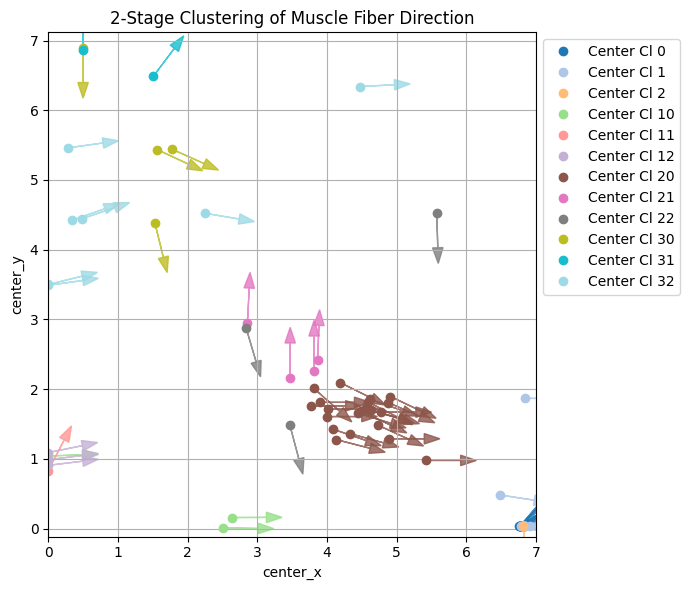

In [41]:
emg_data_session1 = filtered_emg_FD_session1
features_session1 = get_centers_directions(emg_data_session1, gaussian_2d, waveform_length, window_ms=200)
results_df_session1, summary_df_session1 = clustering(features_session1)
summary_df_session1
plot_fiber(results_df_session1)
virtual_bipolars_session1, labels_session1, center_direction_session1, n_virtual_bipolars_session1 = get_virtual_bipolars(results_df_session1)
virtual_emg_session1 = get_virtual_emg(emg_data_session1, virtual_bipolars_session1)
X_session1, y_session1 = get_features(virtual_emg_session1, labels_session1)

In [16]:
summary_df_session1

cluster  center_x_mean  center_x_std  center_y_mean  center_y_std  \
0         0       5.646943      1.229951       0.940980      0.851299   
1         1       4.896573      0.670037       0.762029      0.777889   
2         2       5.664377      1.265852       0.548066      1.092759   
3        10       0.156271      0.310457       0.240048      0.534265   
4        11       0.423330      0.424788       0.408167      0.627024   
5        12       0.281492      0.413821       0.235038      0.486817   
6        20       2.390439      1.340040       4.381913      1.071542   
7        21       2.948888      1.167173       3.793571      0.928530   
8        22       2.536257      1.629225       4.757233      1.539894   
9        30       2.165125      0.721925       0.248735      0.531442   
10       31       2.236386      0.519681       0.437845      0.671107   
11       32       2.135913      0.574366       0.229696      0.447954   

    theta_deg_mean  theta_deg_std  count  
0       -73.564912      16.155850     14  
1        70.063968      19.335590     18  
2        -2.737701      15.327538     26  
3        52.363906      12.713131    107  
4       -53.157946      20.657773     50  
5        12.639763      11.781344    196  
6        58.462809      21.906058     46  
7       -82.332147      11.692042     46  
8       -18.892597      19.469370     20  
9        63.777193      18.874557    103  
10      -71.578092      15.901389     91  
11        0.477306      16.326769    141

検出されたピーク数（条件を満たすもの）: 670


C:\Users\takeu\AppData\Local\Temp\ipykernel_8356\175111030.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name, n_clusters)  # 'tab20', 'nipy_spectral', etc.


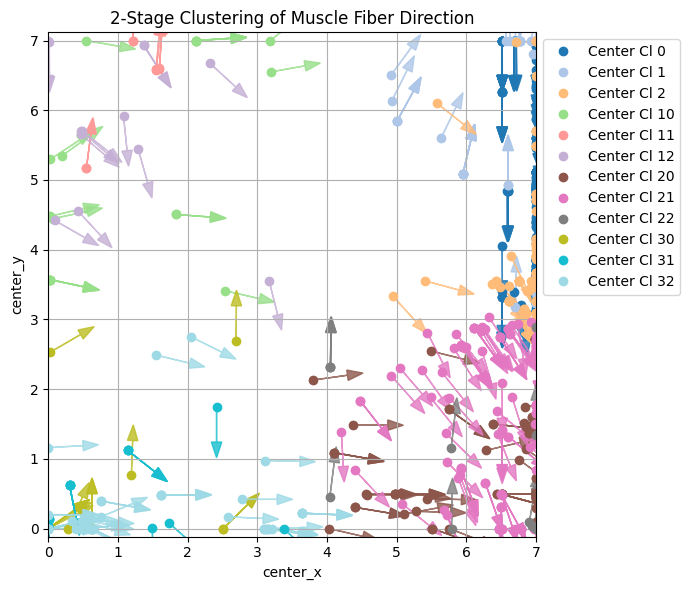

In [26]:
emg_data_session2 = filtered_emg_FD_session2
features_session2 = get_centers_directions(emg_data_session2, window_size=50, threshold=0)
results_df_session2, summary_df_session2 = clustering(features_session2)
summary_df_session2
plot_fiber(results_df_session2)
virtual_bipolars_session2, labels_session2, center_direction_session2, n_virtual_bipolars_session2 = get_virtual_bipolars(results_df_session2)
virtual_emg_session2 = get_virtual_emg(emg_data_session2, virtual_bipolars_session2)
X_session2, y_session2 = get_features(virtual_emg_session2, labels_session2)

In [18]:
summary_df_session2

cluster  center_x_mean  center_x_std  center_y_mean  center_y_std  \
0         0       1.447208      0.991705       5.278212      0.657737   
1         1       1.604446      0.865024       5.080408      1.280769   
2         2       1.078674      1.051168       5.109679      0.862641   
3        10       1.895657      1.036626       0.110035      0.265006   
4        11       2.079713      0.818067       0.316744      0.506814   
5        12       1.428540      1.009777       0.345043      0.467455   
6        20       4.538659      0.935528       3.424193      1.794956   
7        21       5.006030      1.134785       3.454777      1.646872   
8        22       5.839313      1.143316       4.003052      1.759573   
9        30       0.768018      0.754108       2.191350      0.927227   
10       31       0.742728      0.661715       2.239756      0.772510   
11       32       1.452888      1.010593       2.114192      0.618238   

    theta_deg_mean  theta_deg_std  count  
0        76.620041      15.680070     27  
1       -63.869229      15.876059     21  
2         6.724072      12.356571     32  
3        72.148228      18.112539    127  
4       -68.850123      14.605474    181  
5       -19.350123      18.120650    140  
6       -13.465207      19.750113     35  
7       -73.352762      13.262744     23  
8        56.987477      20.948718     30  
9       -11.281539      19.728473     51  
10       65.173470      20.036089     56  
11      -78.173746      14.947349     20

In [27]:
if n_virtual_bipolars_session1 >= 1 and n_virtual_bipolars_session2 >= 1:
    result, y_train, y_test = SVC_classifier(X_session1, y_session1, X_session2, y_session2)
    diff = diff_analyzer(result, y_train, y_test, center_direction_session1, center_direction_session2)
else:
    diff = [None]

In [28]:
diff

[None]

In [321]:
n_virtual_bipolars_session2

0

In [338]:
diffs

[{'diff': [{'train': 0,
    'test': 30,
    'x_diff': 3.8259491881339103,
    'y_diff': 3.593425777750928,
    'theta_diff': 132.32900987559782},
   {'train': 30,
    'test': 10,
    'x_diff': -0.02485568984674824,
    'y_diff': -0.05747863767190342,
    'theta_diff': 9.093665741959128}],
  'file_name': ['pr_dataset/subject01_session1/maintenance_preprocess_sample1',
   'pr_dataset/subject01_session2/maintenance_preprocess_sample1'],
  'electrode_place': 'ED'},
 {'diff': [{'train': 20,
    'test': 21,
    'x_diff': 3.9834823697861856,
    'y_diff': 2.5134437058997183,
    'theta_diff': -8.075040434084851},
   {'train': 30,
    'test': 31,
    'x_diff': 0.7655725323054208,
    'y_diff': 0.15258456651748098,
    'theta_diff': -6.914685794504898},
   {'train': 32,
    'test': 11,
    'x_diff': 3.10617847342346,
    'y_diff': 1.6273900614522736,
    'theta_diff': 14.760163601038961}],
  'file_name': ['pr_dataset/subject01_session1/maintenance_preprocess_sample1',
   'pr_dataset/subject01_s